In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import mplstereonet
import skimage.exposure
import harmonica as hm
import verde as vd

import micromag as mg

# Read the real data

In [2]:
data_dir = pathlib.Path("..") / "data"
data = mg.load_qdm(data_dir / "Bz_uc0.mat")
data

<xarray.Dataset>
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz       (y, x) float64 352.4 94.89 41.62 288.4 ... -4.196 -53.56 2.103
Attributes:
    file_name:  ../data/Bz_uc0.mat

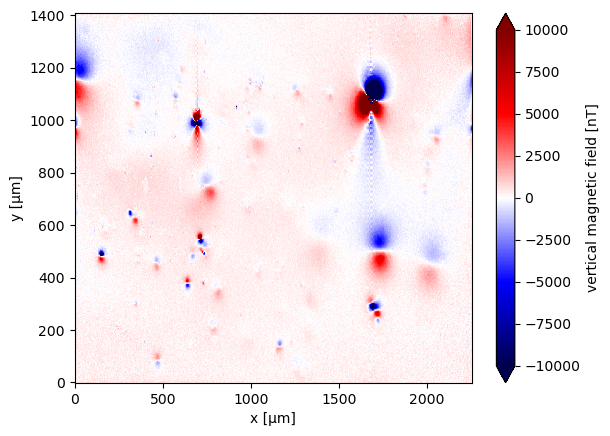

In [3]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

# Anomaly detection

First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Polynomial fitting to suppress high frequency noise
2. Upward continue the data to suppress high frequency noise
3. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
4. Contrast stretch the TGA to highlight weaker sources
5. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

## 1. Polynomial fitting to suppress low frequency noise

In [4]:
table = vd.grid_to_table(data)

In [5]:
trend = vd.Trend(degree=3).fit((table.x, table.y), table.bz)
low_frequency_noise = trend.grid(
    coordinates=(data.x, data.y),
    dims=("y", "x"),
)
data = data.assign(low_freq=low_frequency_noise.scalars)
data.low_freq.attrs = {"long_name": "low-frequency noise", "units": "nT"}
data = data.assign(residual=data.bz - data.low_freq)
data.residual.attrs = {"long_name": "residual anomaly", "units": "nT"}

data.x.attrs = {"units": "µm"}
data.y.attrs = {"units": "µm"}
data.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}

data

<xarray.Dataset>
Dimensions:   (y: 600, x: 960)
Coordinates:
  * x         (x) float64 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y         (y) float64 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z         (y, x) float64 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz        (y, x) float64 352.4 94.89 41.62 288.4 ... -4.196 -53.56 2.103
    low_freq  (y, x) float64 -158.8 -156.5 -154.1 -151.7 ... 506.6 508.7 510.8
    residual  (y, x) float64 511.2 251.3 195.7 440.1 ... -510.8 -562.2 -508.7
Attributes:
    file_name:  ../data/Bz_uc0.mat

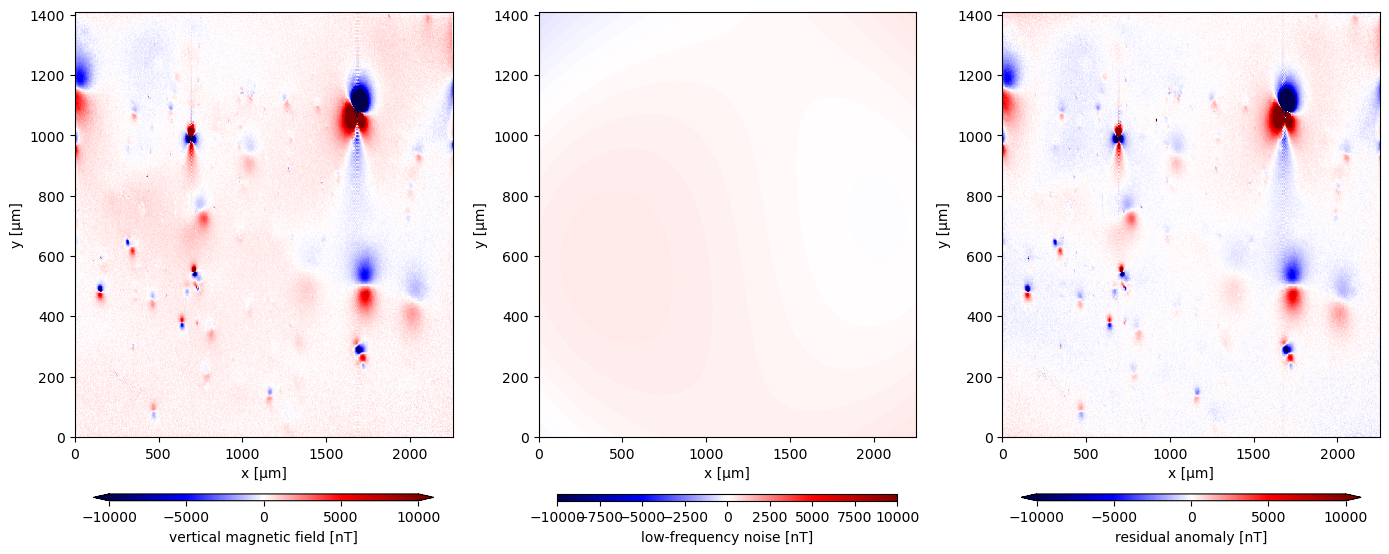

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.1, shrink=0.9)
for field, ax in zip(["bz", "low_freq", "residual"], axes.ravel()):
    vmax = +10000
    vmin = -10000
    data[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs, vmax=vmax, vmin=vmin)
for ax in axes.ravel():
    ax.set_aspect("auto")
plt.tight_layout()

## 2. Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [7]:
height_difference = 5

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.residual, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)

data_up.z.attrs = {"units": "µm"}

data_up

/home/leo/bin/conda/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 600, x: 960)
Coordinates:
  * y        (y) float64 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
  * x        (x) float64 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 179.4 272.2 330.3 374.5 ... -37.43 2.523 81.43

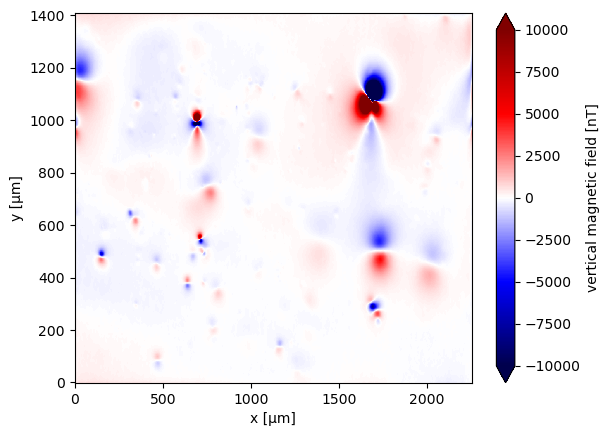

In [8]:
scale = 10000
data_up.bz.plot.pcolormesh(cmap="seismic", vmax=scale, vmin=-scale)

## 3. Calculate the TGA

We do this with finite difference derivatives to avoid amplifying noise.

In [9]:
data_up = data_up.assign(mg.data_gradients(data_up.bz))
data_up

/home/leo/bin/conda/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/leo/bin/conda/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 600, x: 960)
Coordinates:
  * y        (y) float64 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
  * x        (x) float64 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 179.4 272.2 330.3 374.5 ... -37.43 2.523 81.43
    tga      (y, x) float64 41.31 39.91 30.8 31.58 ... 47.0 48.39 53.51 45.85
    x_deriv  (y, x) float64 39.52 32.11 21.76 16.75 ... 10.44 14.16 25.29 33.58
    y_deriv  (y, x) float64 -7.62 -9.232 -12.67 -16.62 ... -20.44 -16.89 -9.813
    z_deriv  (y, x) float64 -9.317 -21.84 -17.73 -20.98 ... 41.51 44.03 29.64

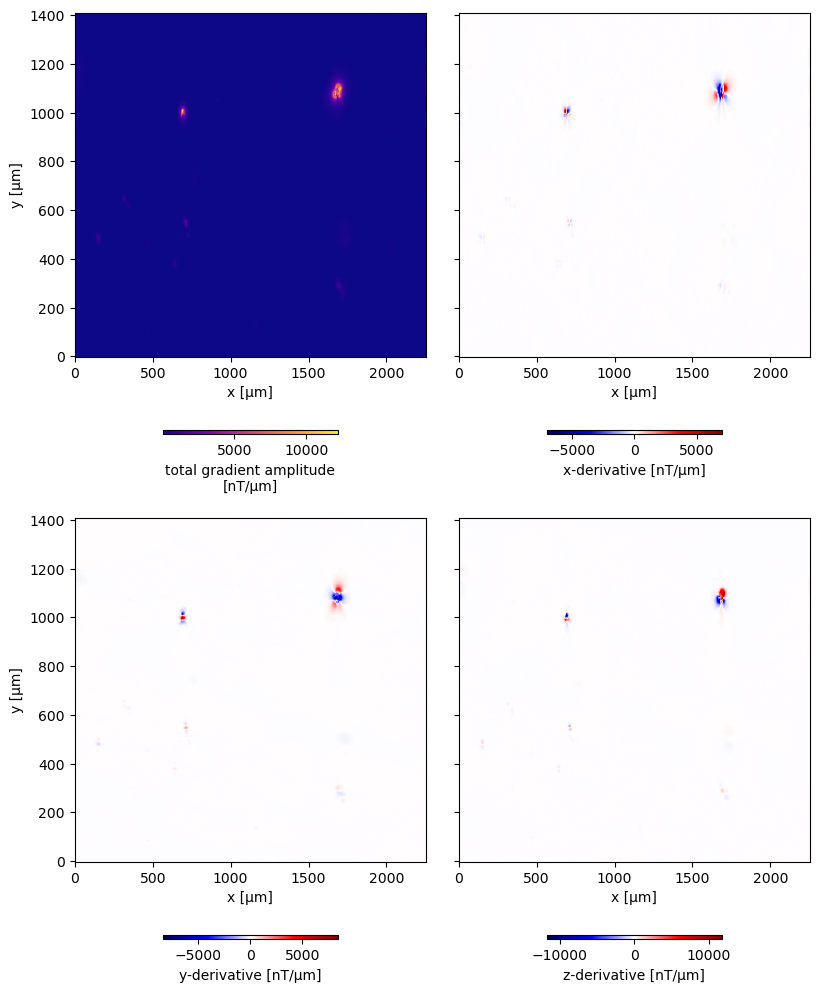

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
        vmax=None
        vmin=None
    else:
        vmax= None# 500
        vmin= None#-500
        cmap="seismic"
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs, vmax=vmax, vmin=vmin)
for ax in axes.ravel():
    ax.set_aspect("auto")
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 4. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [11]:
stretched = skimage.exposure.rescale_intensity(
    data_up.tga, 
    in_range=tuple(np.percentile(data_up.tga, (1, 99))),
)
data_up = data_up.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

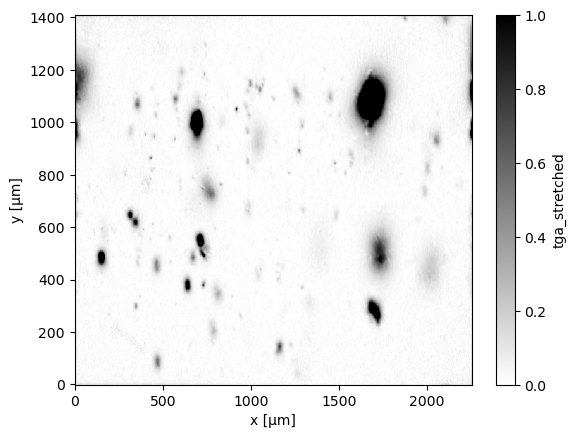

In [12]:
data_up.tga_stretched.plot.pcolormesh(cmap="gray_r")

## 5. Blob detection

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [13]:
windows = mg.detect_anomalies(
    data_up.tga_stretched, 
    size_range=[20, 200],
    size_increment=1.3,
    threshold=0.025,
    overlap=0.0,
    exclude_border=30,
    nsizes=10,
)
print('Sources detected: ', np.shape(windows)[0])

Sources detected:  103


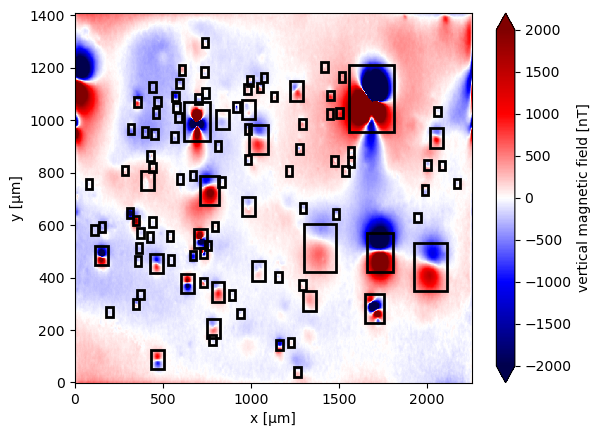

In [14]:
ax = plt.subplot(111)
scale = 2000
data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic", vmax=scale, vmin=-scale)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)  
ax.set_aspect("auto")

Now that we know the bounding box of each anomaly, we can run the Euler deconvolution and moment inversion for each anomaly separately.

# Euler Deconvolution and Inversion

Run the Euler Deconvolution and the inversion on each window.

In [15]:
positions = []
estimated_dipole_moments = []
estimated_stds = []
calculated_r2 = []
calculated_SNR = []
windows_filtered = []
base_levels = []
for window in windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
#     anomaly = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    data_minus_background = anomaly.bz.values - base_level
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(
        anomaly.data_minus_background, position,
    )
    
    # Filter out solutions that don't meet quality criteria
    bad_euler = position[2] > 0
    poor_fit = False
#     poor_fit = r2 < 0.85
    if bad_euler or poor_fit:
        continue
    print("R²: %s and SNR: %s"%(r2,SNR))  
    positions.append(position)  
    estimated_dipole_moments.append(moment)
    estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
    calculated_r2.append(r2)
    calculated_SNR.append(SNR)
    windows_filtered.append(window)
    base_levels.append(base_level)
positions = np.transpose(positions)

print()
print("Dipole moments estimated:", positions.shape[1])

R²: 0.8878527951939097 and SNR: 9.51794447927628
R²: 0.9178851692032209 and SNR: 10.96480938470361
R²: 0.994858668922669 and SNR: 23.16569099556863
R²: 0.7452779841090766 and SNR: 5.964801807504507
R²: 0.9729155534203067 and SNR: 15.678143851253353
R²: 0.9972381671760919 and SNR: 25.59065285286536
R²: 0.9813627301403222 and SNR: 17.472837828065582
R²: 0.9856082231719481 and SNR: 18.43000932918428
R²: 0.9992125990110754 and SNR: 31.418207389183344
R²: 0.7365573143491881 and SNR: 6.165869250349343
R²: 0.9962398338813783 and SNR: 24.2506993410902
R²: 0.9604071776969029 and SNR: 14.087113682728287
R²: 0.9980080257589977 and SNR: 27.008186348338707
R²: 0.9961228684766801 and SNR: 24.220360391019273
R²: 0.9485383246324558 and SNR: 13.055184725902542
R²: 0.9934869972882744 and SNR: 22.053260948665475
R²: 0.9450689476106446 and SNR: 12.606043217455055
R²: 0.9788424031522336 and SNR: 16.806435729017338
R²: 0.968856073448906 and SNR: 15.25870762356247
R²: 0.9658474884092394 and SNR: 14.805775593

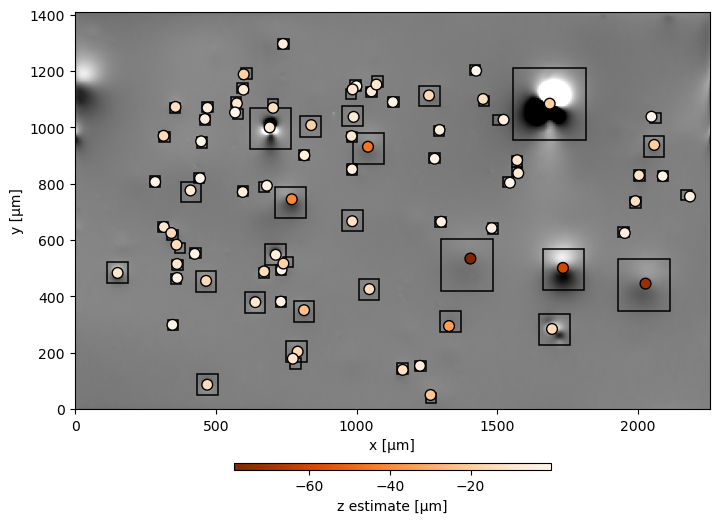

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.09, shrink=0.5)
scale = 5000
data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, add_colorbar=False)
for window in windows_filtered:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions[:2], c=positions[2], cmap="Oranges_r", s=60, edgecolor='k')
fig.colorbar(tmp, **cbar_kwargs, label="z estimate [µm]")

ax.set_aspect("equal")
plt.tight_layout(w_pad=0, pad=0)

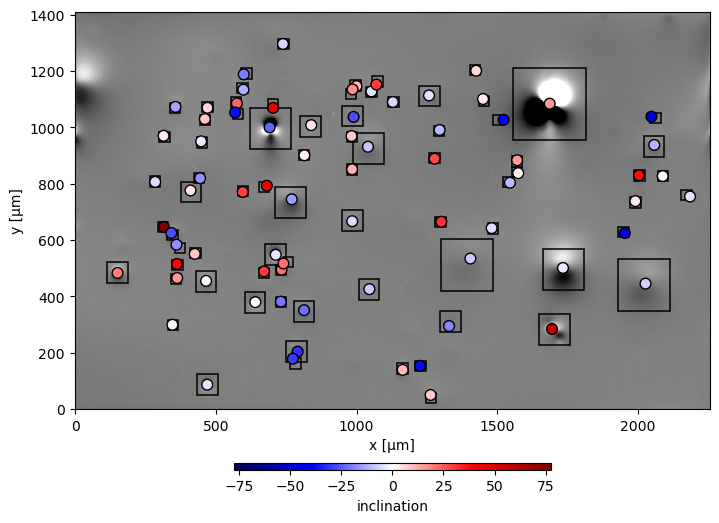

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.09, shrink=0.5)
scale = 5000
data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, add_colorbar=False)
for window in windows_filtered:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

estimated = mg.vector_to_angles(estimated_dipole_moments)
scale = vd.maxabs(estimated[0])
tmp = ax.scatter(*positions[:2], c=estimated[0], cmap="seismic", vmin=-scale, vmax=scale, s=60, edgecolor='k')
fig.colorbar(tmp, **cbar_kwargs, label="inclination")

ax.set_aspect("equal")
plt.tight_layout(w_pad=0, pad=0)

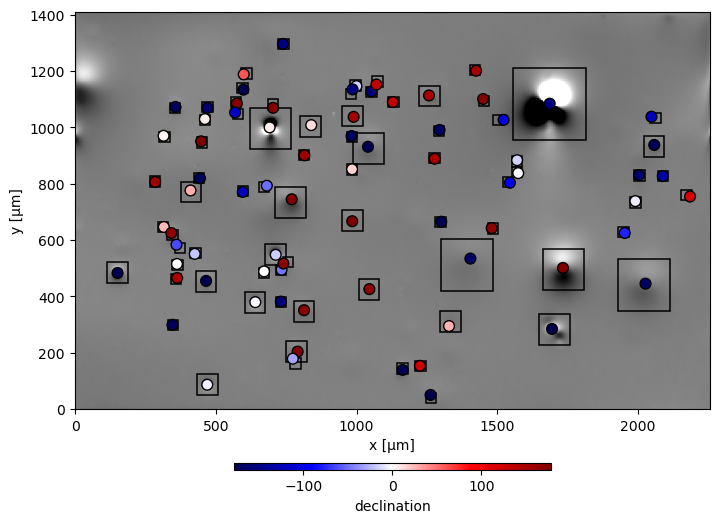

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.09, shrink=0.5)
scale = 5000
data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, add_colorbar=False)
for window in windows_filtered:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

estimated = mg.vector_to_angles(estimated_dipole_moments)
scale = vd.maxabs(estimated[1])
tmp = ax.scatter(*positions[:2], c=estimated[1], cmap="seismic", vmin=-scale, vmax=scale, s=60, edgecolor='k')
fig.colorbar(tmp, **cbar_kwargs, label="declination")

ax.set_aspect("equal")
plt.tight_layout(w_pad=0, pad=0)

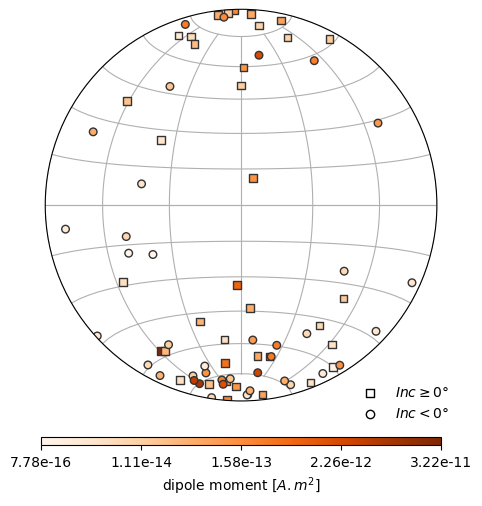

In [19]:
fig, ax = mplstereonet.subplots(1, 1, figsize=(4, 4), constrained_layout=True)
ax.grid()
estimated = mg.vector_to_angles(estimated_dipole_moments)
scatter_args = dict(
    vmin=np.log10(np.min(estimated[2])),
    vmax=np.log10(np.max(estimated[2])),
    cmap="Oranges",
    edgecolors="#333333",
    linewidths=1,
    s=30,
    zorder=2,
)
pos_inc = estimated[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
    c=np.log10(estimated[2][pos_inc]),
    marker="s",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
    c=np.log10(estimated[2][~pos_inc]),
    marker="o",
    **scatter_args,
)

ticks=np.linspace( np.log10(np.min(estimated[2])),
                   np.log10(np.max(estimated[2])), 5)
tick_labels = []
for i in (ticks):
    tick_labels.append("{:.2e}".format(10**i))

    
clb = fig.colorbar(
    tmp, 
    cax=fig.add_axes([0, -0.1, 1, 0.02]), 
    orientation="horizontal", 
    label="dipole moment [$A.m^2$]",
    format="%.2e",
    ticks = ticks).set_ticklabels(tick_labels)

plt.scatter([],[], marker='s', color='white', edgecolors='k', label=r'$Inc \geq 0° $')
plt.scatter([],[], marker='o', color='white', edgecolors='k', label=r'$Inc < 0° $')

legend = plt.legend(bbox_to_anchor=(1.05, 9.0), frameon=1, framealpha=1.0)
frame = legend.get_frame()
frame.set_facecolor('w')
frame.set_edgecolor('w')

plt.show()

R²: 0.8876891087256398  | Dec: -151.27798193622132 | Inc: 16.30908206767869 | Amp: 3.222872646243807e-11
SNR: 9.517886267357138 |  Xc: 1685.4664711460819 |  Yc: 1084.3966239311308 |  Zc: -20.177691799096827


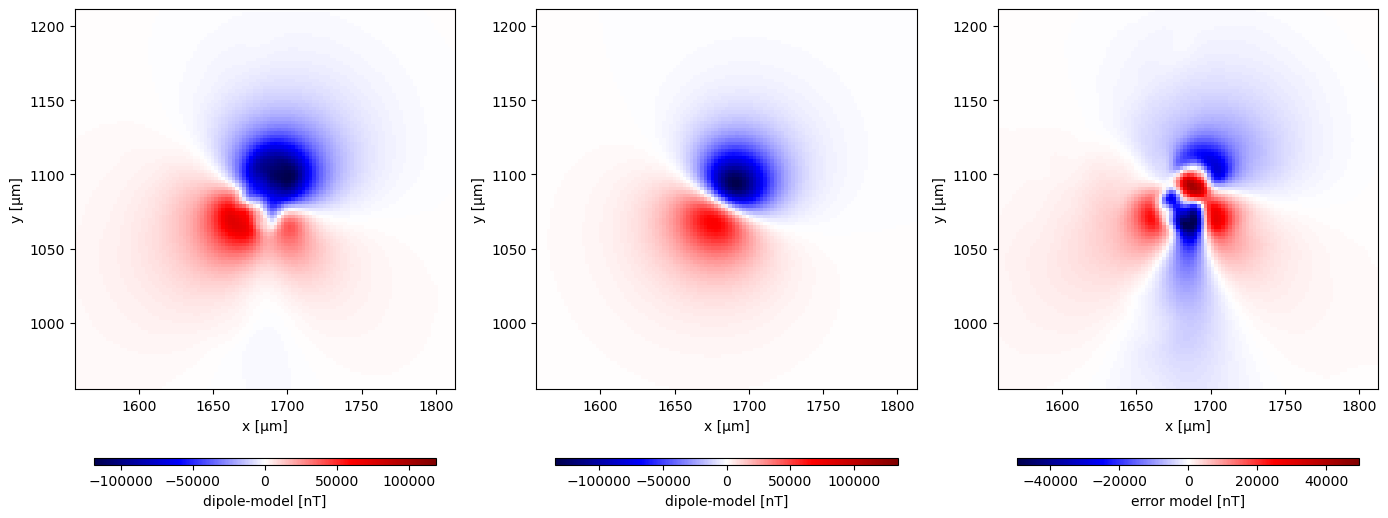

R²: 0.9152754348370646  | Dec: 6.8139214357334374 | Inc: -24.01420992172343 | Amp: 2.0186412822459017e-12
SNR: 10.963884625042528 |  Xc: 690.8397739948434 |  Yc: 1000.3263385104659 |  Zc: -5.931106095064345


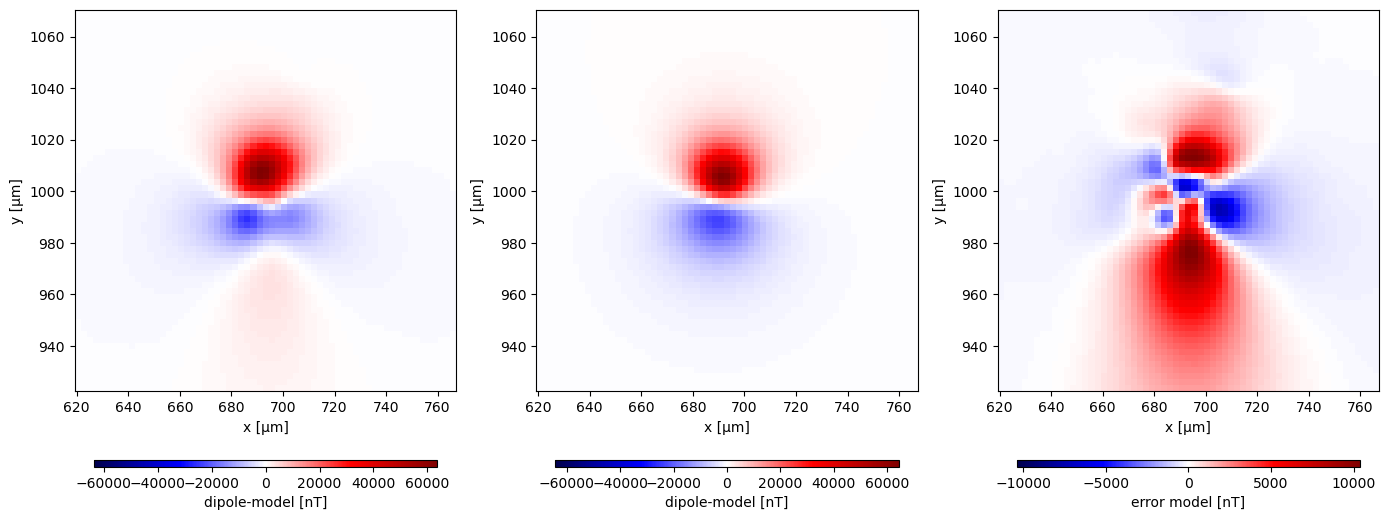

R²: 0.987481716451636  | Dec: -174.30507118414718 | Inc: 22.018000666294714 | Amp: 4.358533532342145e-13
SNR: 22.223030993916566 |  Xc: 150.86792318295156 |  Yc: 483.39959826122777 |  Zc: -9.937156621731


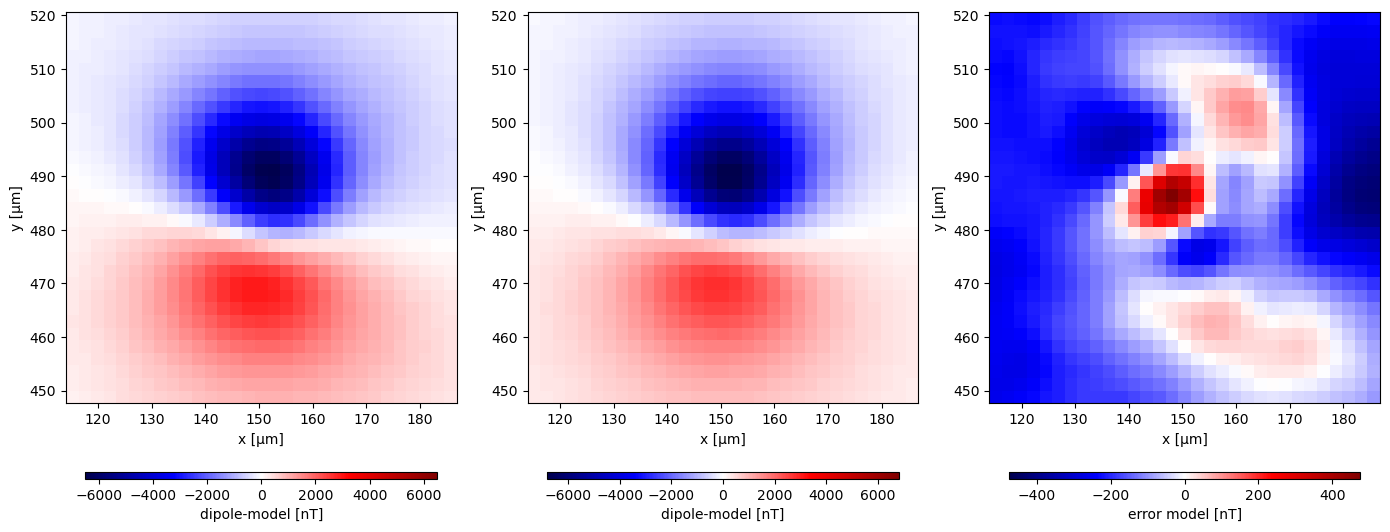

R²: 0.7408955573967921  | Dec: -177.4500632558778 | Inc: 56.04708694366544 | Amp: 7.116102670889001e-13
SNR: 5.958202954989712 |  Xc: 1693.72783037388 |  Yc: 284.31776589089 |  Zc: -14.621828797315933


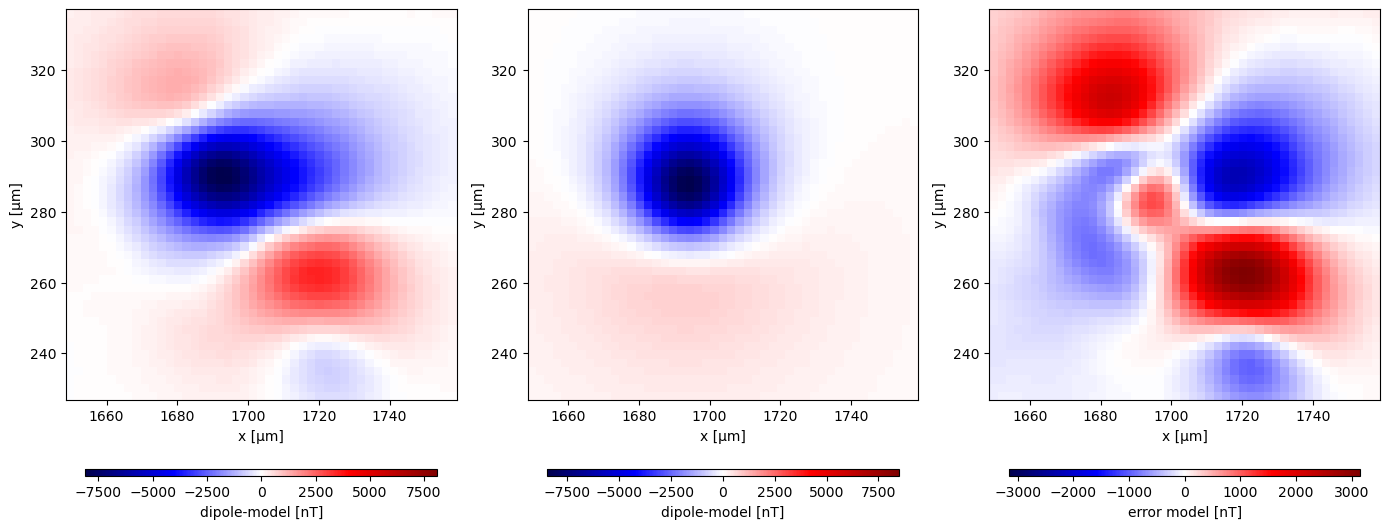

R²: 0.9716861124634704  | Dec: -17.14610277154552 | Inc: -4.305759017717588 | Amp: 3.0265449758156734e-13
SNR: 15.666613784193732 |  Xc: 712.4652639435027 |  Yc: 547.7682000152548 |  Zc: -4.437487204372237


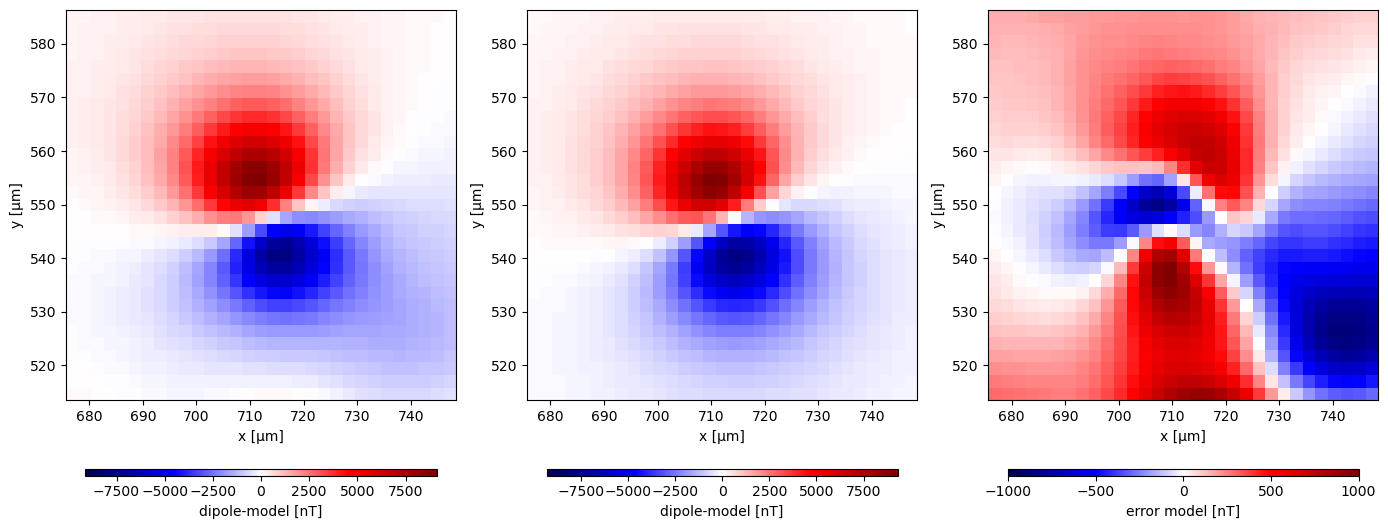

R²: 0.9910744084151178  | Dec: -1.9306822647370574 | Inc: 1.8509229402100522 | Amp: 1.9866065092046293e-13
SNR: 24.47783279095463 |  Xc: 639.9541482517117 |  Yc: 379.4918294557334 |  Zc: -8.650535380992453


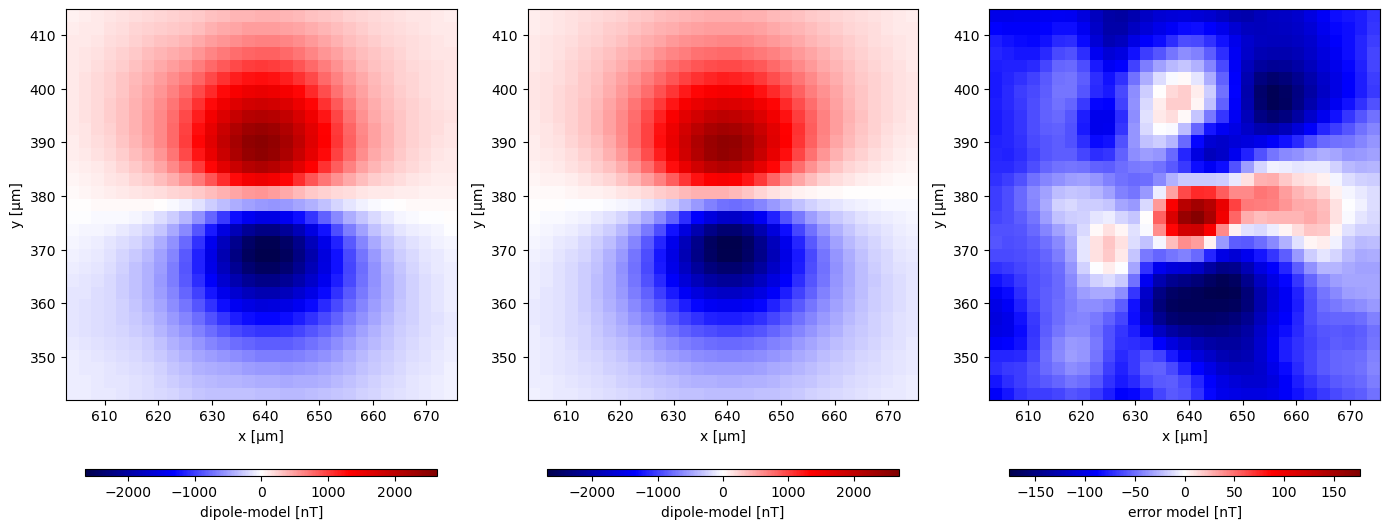

R²: 0.9780899608079191  | Dec: 25.39069264438185 | Inc: 77.83814441293548 | Amp: 1.366502318793977e-13
SNR: 16.968493130987074 |  Xc: 315.11250697284413 |  Yc: 646.6043643176336 |  Zc: -9.966997754629668


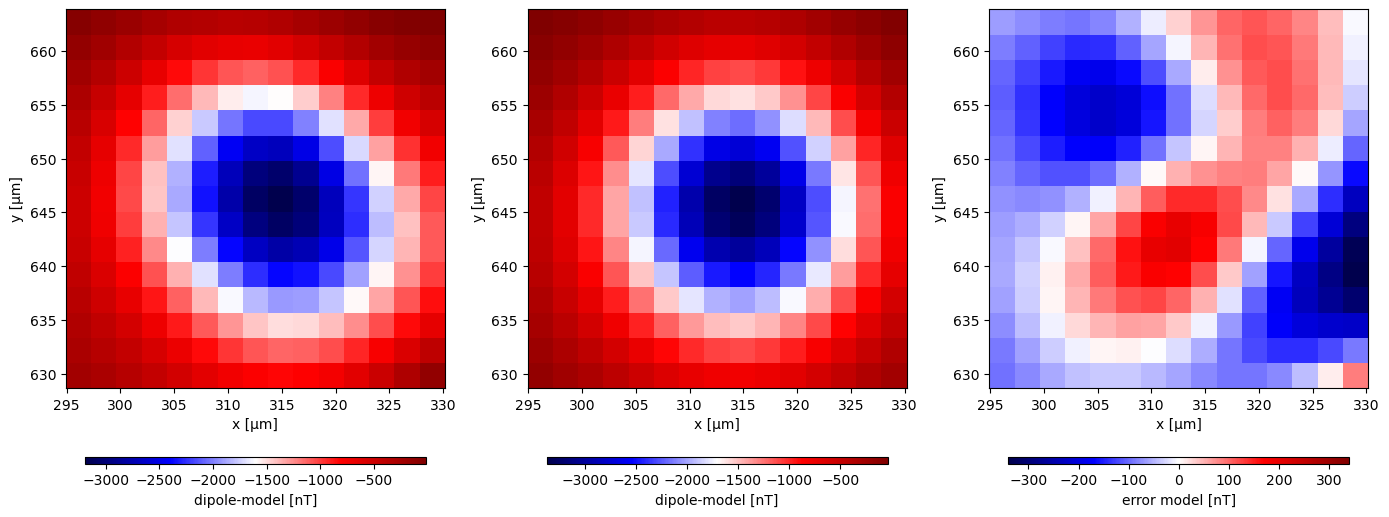

R²: 0.9818913112139153  | Dec: 166.31014787024318 | Inc: -25.34664775893593 | Amp: 2.7791018512749175e-13
SNR: 17.588546987651327 |  Xc: 341.793959566213 |  Yc: 625.1476941847627 |  Zc: -15.339344967177823


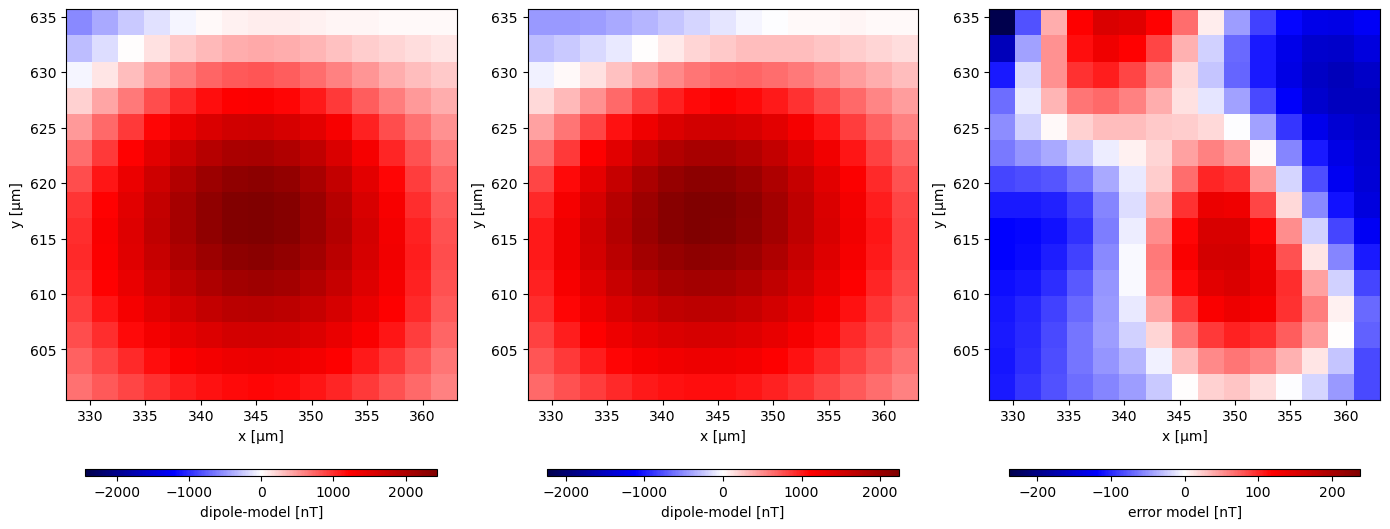

R²: 0.9966710526340361  | Dec: 178.00427405744824 | Inc: -2.0983504176276067 | Amp: 1.7784197788441303e-11
SNR: 26.869864597322838 |  Xc: 1732.6752455252156 |  Yc: 501.10484971284865 |  Zc: -59.47711609970577


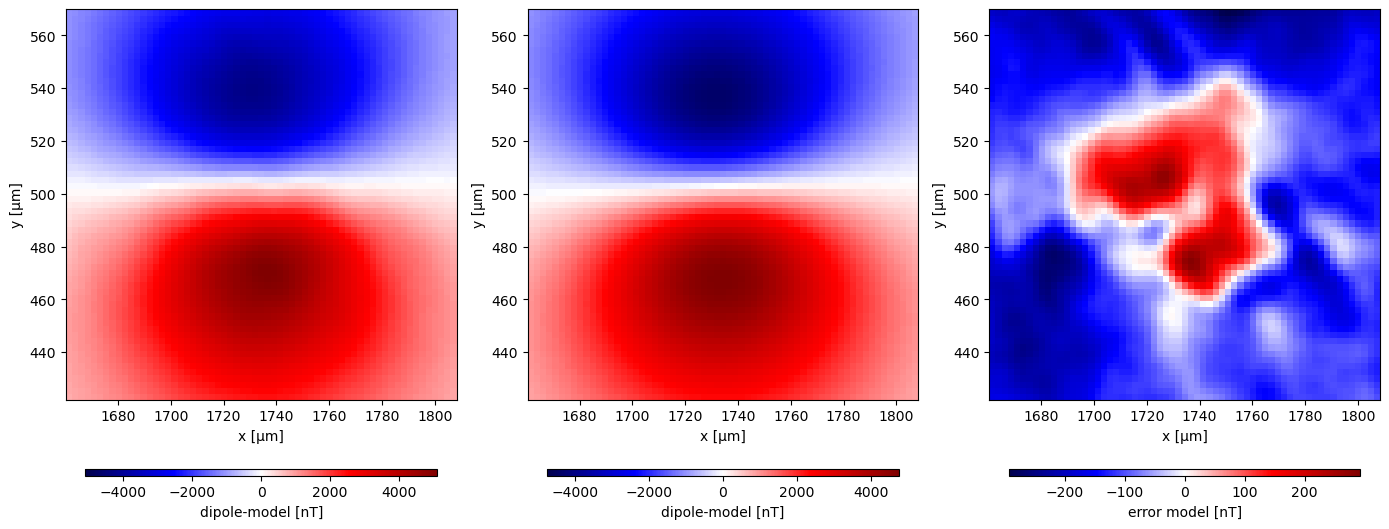

R²: 0.710392391982846  | Dec: -48.02115385067229 | Inc: 20.66024563362694 | Amp: 1.7381606203100553e-14
SNR: 6.067631049360173 |  Xc: 733.0781106717488 |  Yc: 494.7820276452412 |  Zc: -0.6732865033857919


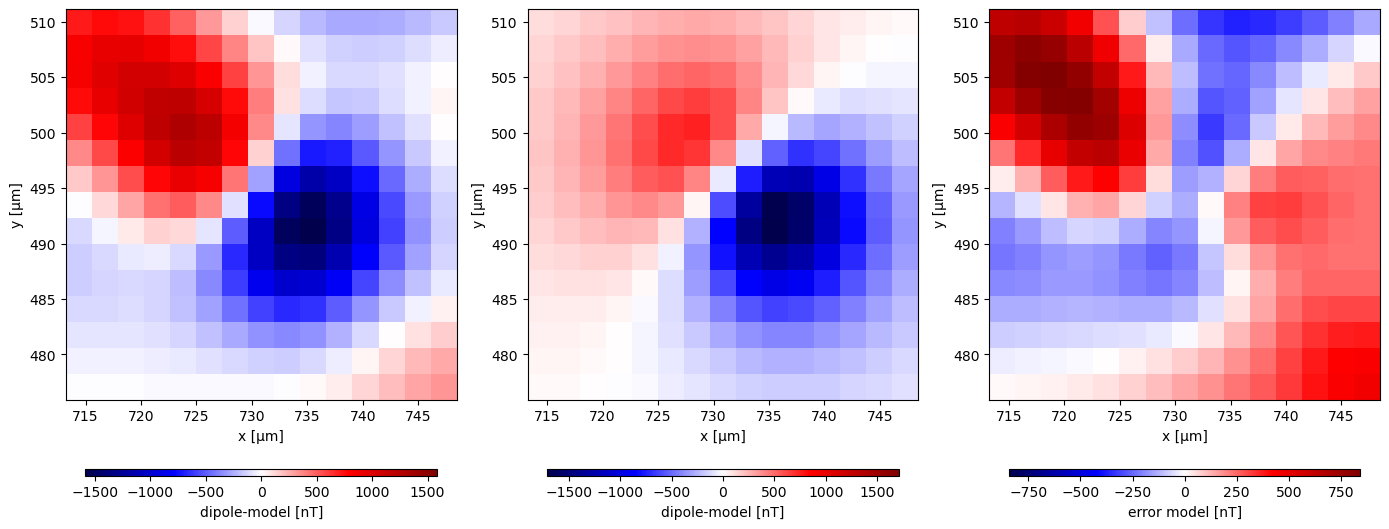

R²: 0.9939396085895423  | Dec: -175.4113520467 | Inc: 12.684820988349308 | Amp: 1.533788139239001e-13
SNR: 22.6000373916813 |  Xc: 1163.3717624666754 |  Yc: 139.17725368726346 |  Zc: -12.509671318993004


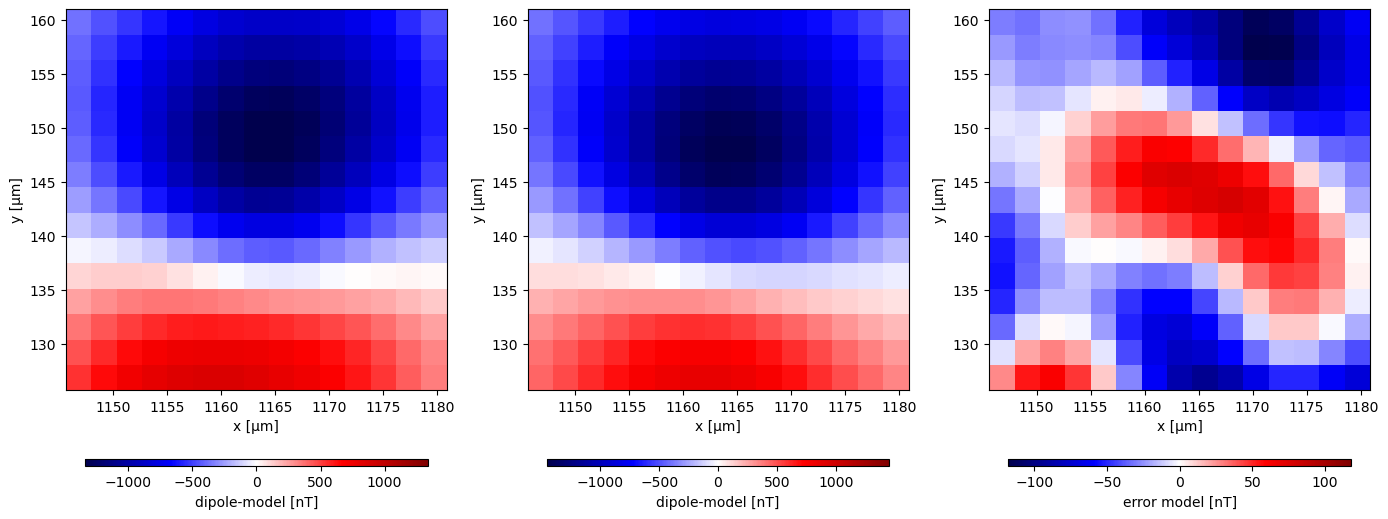

R²: 0.9549590980128772  | Dec: -152.4201430702136 | Inc: -18.107196924294975 | Amp: 1.1082816232824093e-14
SNR: 13.910533151708877 |  Xc: 730.6581538157702 |  Yc: 381.4996786930498 |  Zc: -2.3029831959012914


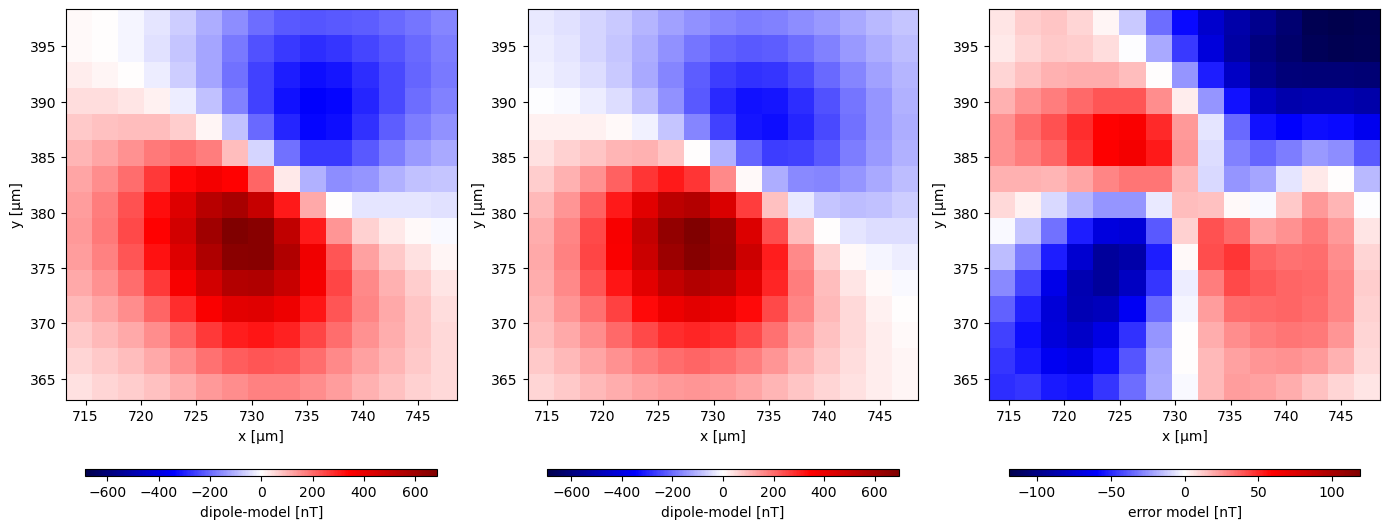

R²: 0.9571194138099777  | Dec: -168.92230362314416 | Inc: -3.5776427995209543 | Amp: 1.183944655304805e-13
SNR: 14.730921571793596 |  Xc: 356.4028079585461 |  Yc: 1073.0736382788855 |  Zc: -13.238735719147739


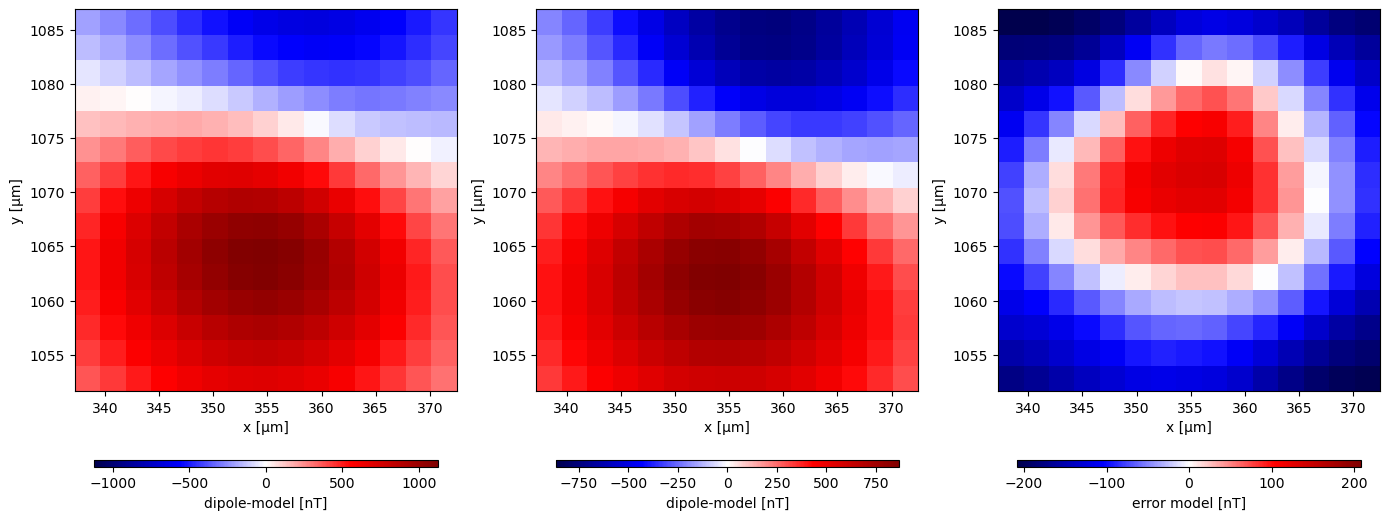

R²: 0.9865140888581734  | Dec: -5.158238646781461 | Inc: -6.172065802772504 | Amp: 1.7301189485405667e-13
SNR: 21.97994838096072 |  Xc: 469.2708099612267 |  Yc: 86.35809885667129 |  Zc: -14.268438873938036


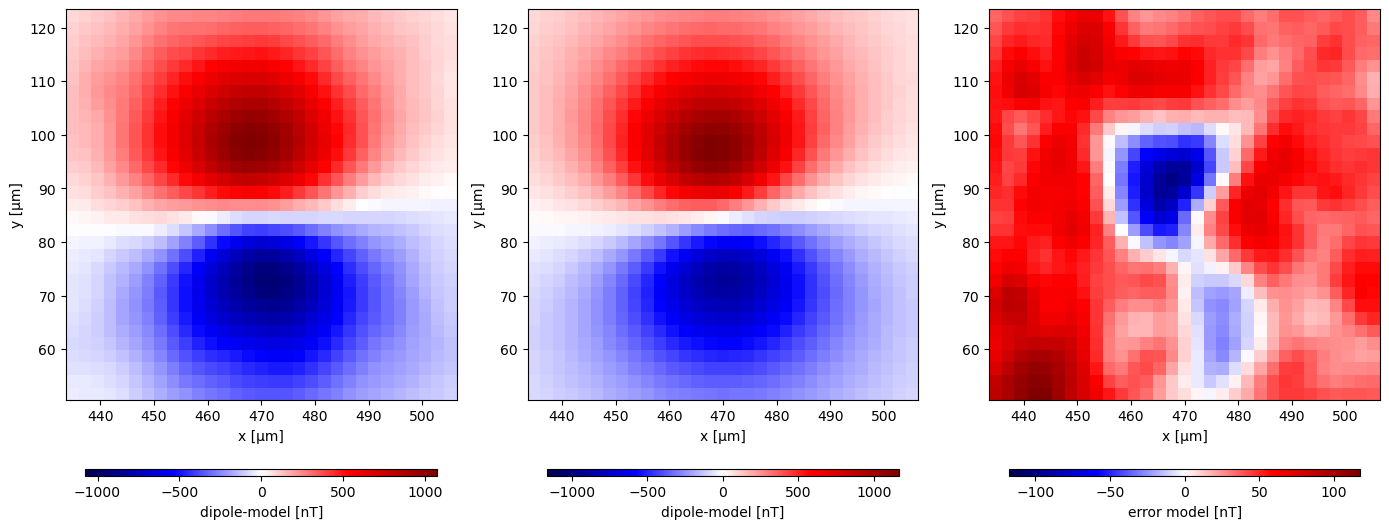

R²: 0.7501193358330761  | Dec: 170.20026401534562 | Inc: 31.918542102313335 | Amp: 6.948579913479704e-14
SNR: 7.415495240370365 |  Xc: 574.4088127246665 |  Yc: 1085.5317974385366 |  Zc: -9.534769769878615


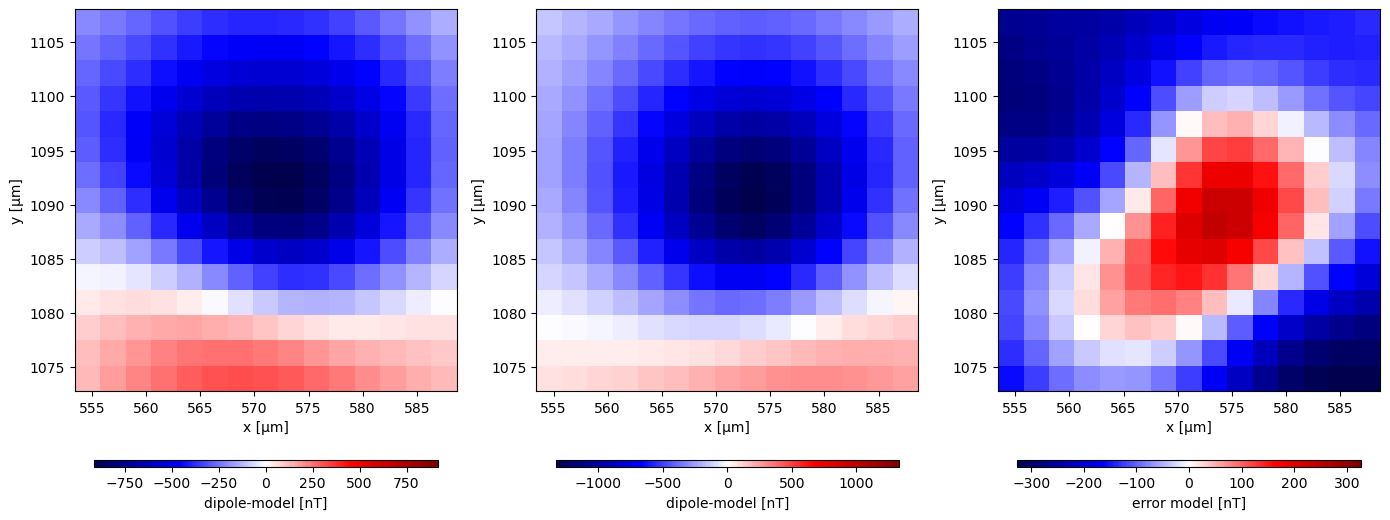

R²: 0.9827653200907501  | Dec: 1.426994115233446 | Inc: 32.3419569178534 | Amp: 1.147555786490565e-13
SNR: 18.348105847612718 |  Xc: 671.0989401803066 |  Yc: 488.65552901684055 |  Zc: -13.566957126142903


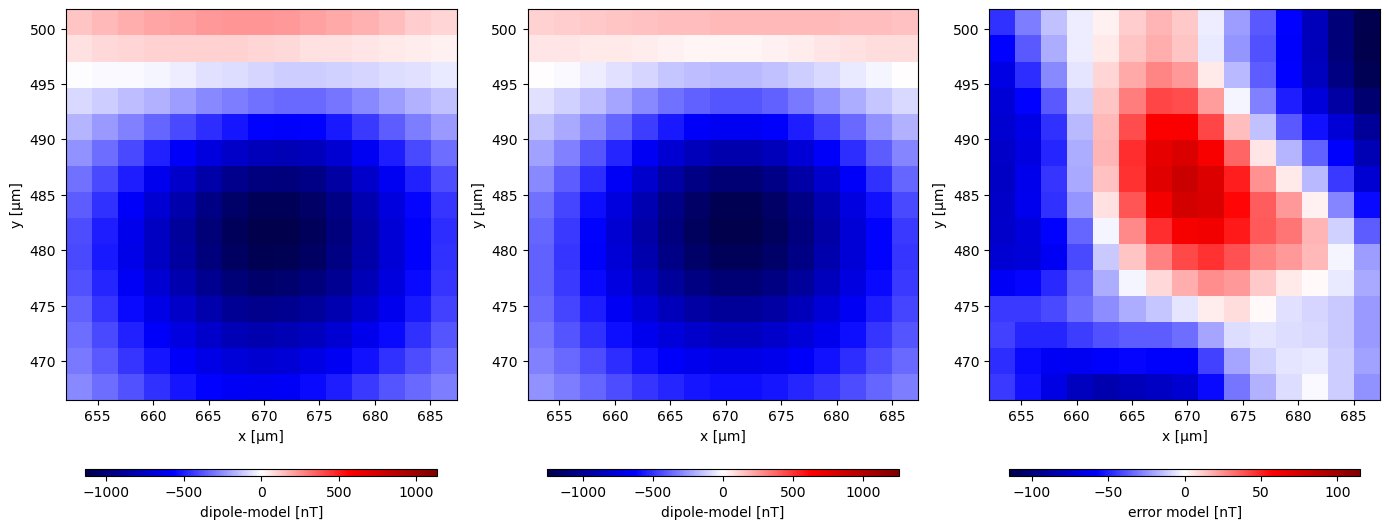

R²: 0.9386895160908547  | Dec: 174.63260344351713 | Inc: -17.22647922864114 | Amp: 2.7521848693976605e-12
SNR: 12.354401865168793 |  Xc: 769.4003878278841 |  Yc: 744.9083032421007 |  Zc: -40.75420960264709


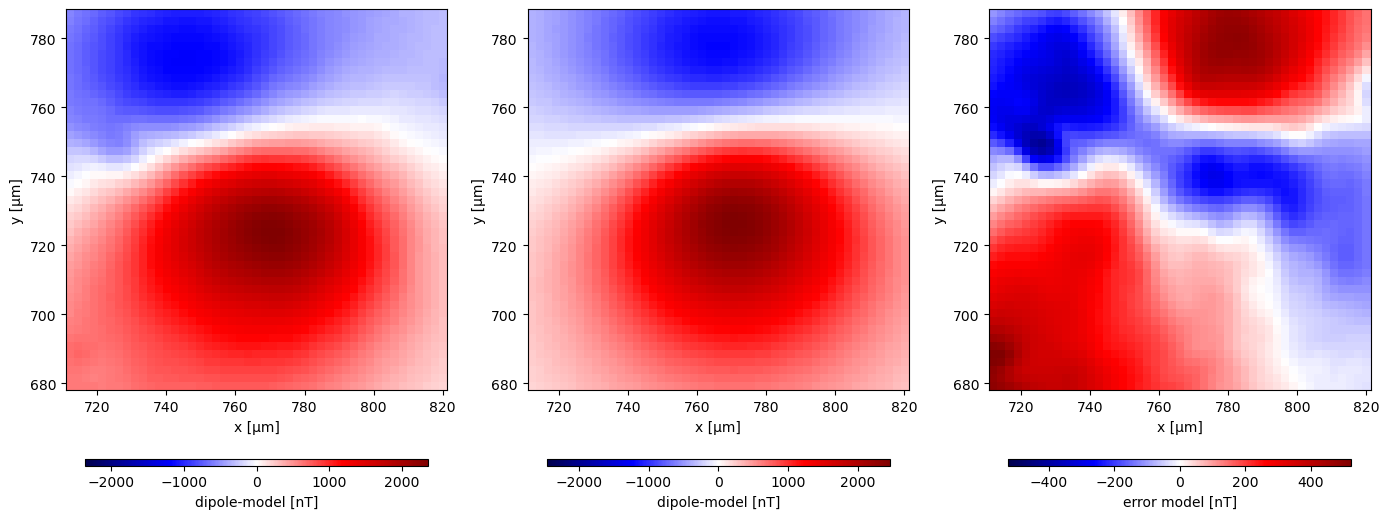

R²: 0.9117659155923141  | Dec: -175.87302316326623 | Inc: 6.91084214789674 | Amp: 1.9755533319969553e-13
SNR: 13.844444444391987 |  Xc: 465.199336975062 |  Yc: 455.21917378759497 |  Zc: -15.693766101904071


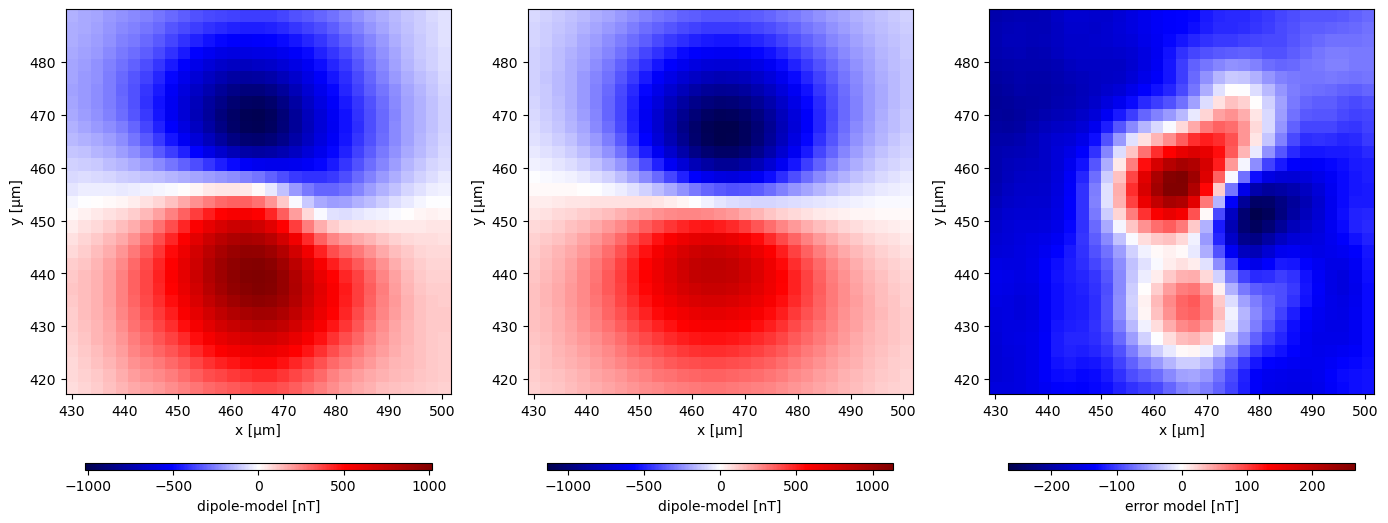

R²: 0.24338001213333216  | Dec: -168.28602921978722 | Inc: 17.606078918913965 | Amp: 7.407327596438255e-15
SNR: 6.760765094794582 |  Xc: 345.6828429223298 |  Yc: 299.16867978998437 |  Zc: -1.4040221132357367


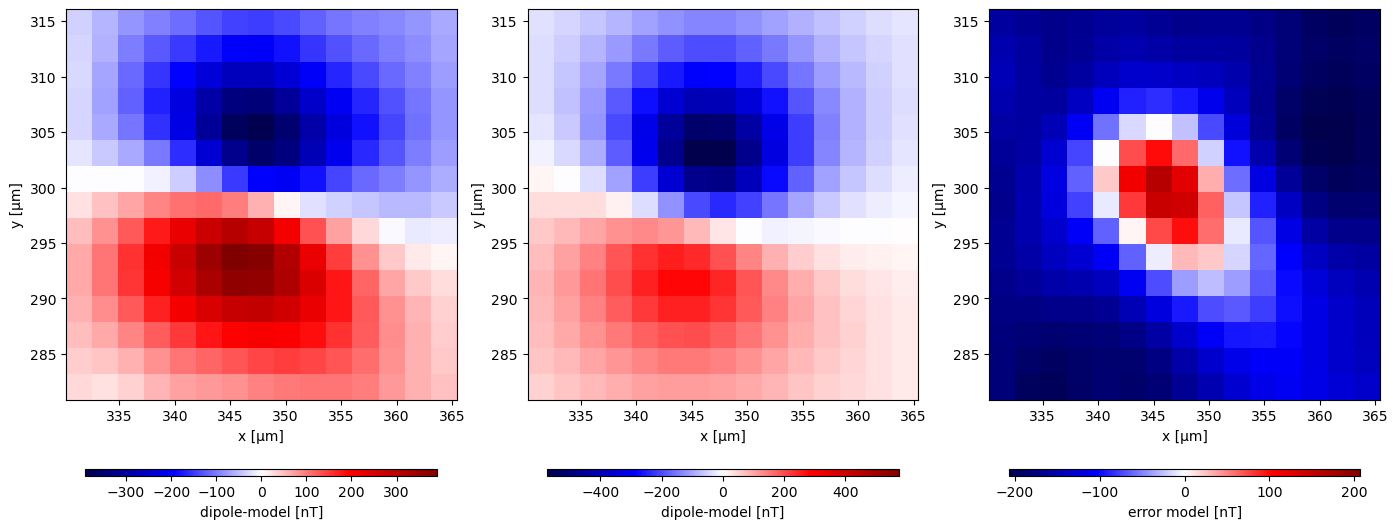

R²: 0.9684736172650048  | Dec: -154.30310165111746 | Inc: -1.9702218272493786 | Amp: 3.3939547120405094e-14
SNR: 15.013262010336593 |  Xc: 1052.4408037918772 |  Yc: 1128.0600188320582 |  Zc: -7.828072558449059


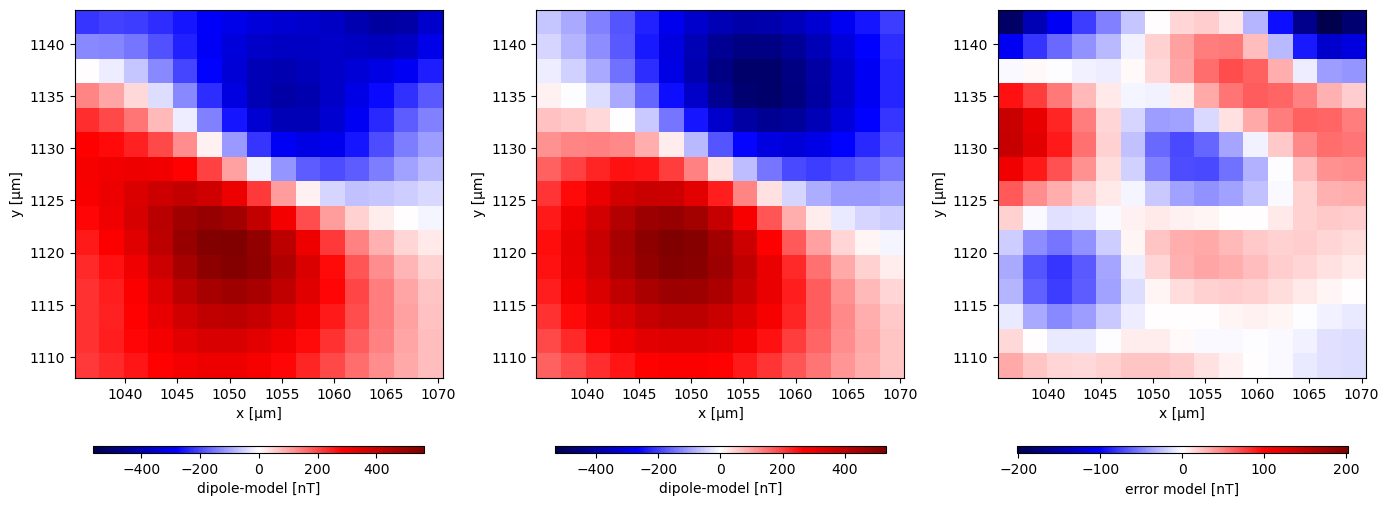

R²: 0.9860530026633785  | Dec: -173.74653506697229 | Inc: -12.495993015011543 | Amp: 2.7866608744516134e-13
SNR: 18.555919448355947 |  Xc: 2056.8146156182615 |  Yc: 938.0632657495712 |  Zc: -20.185656637023218


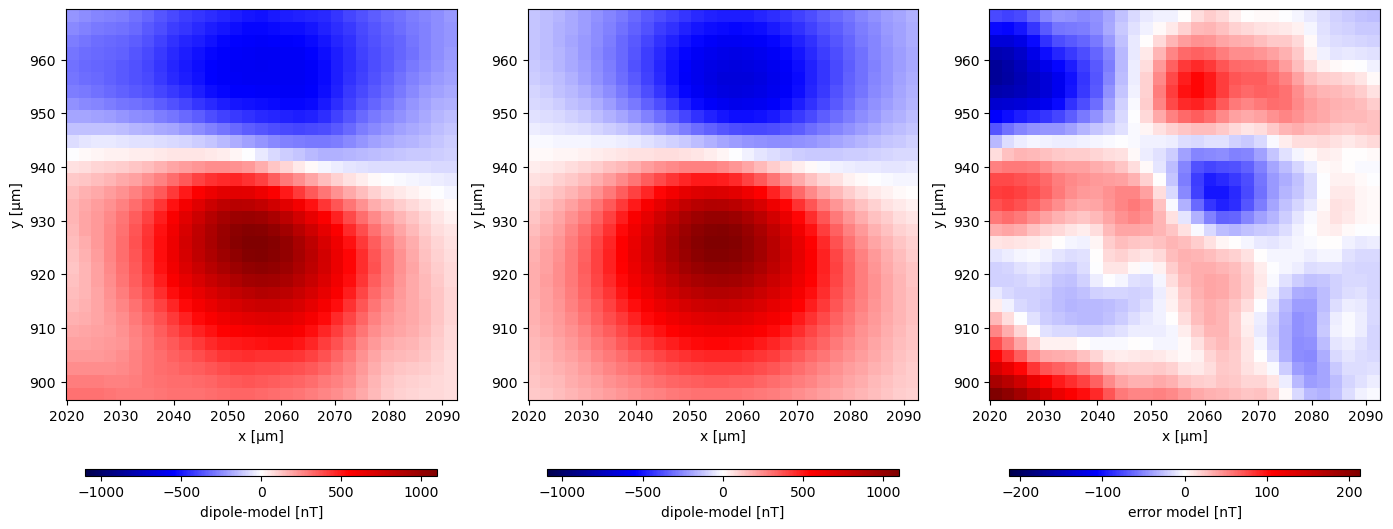

R²: -0.09577493740525145  | Dec: 146.24554046619014 | Inc: 2.3463552558030187 | Amp: 4.98376870566455e-15
SNR: 5.00518800285493 |  Xc: 1276.798735022232 |  Yc: 889.0164073589606 |  Zc: -1.3671554372870744


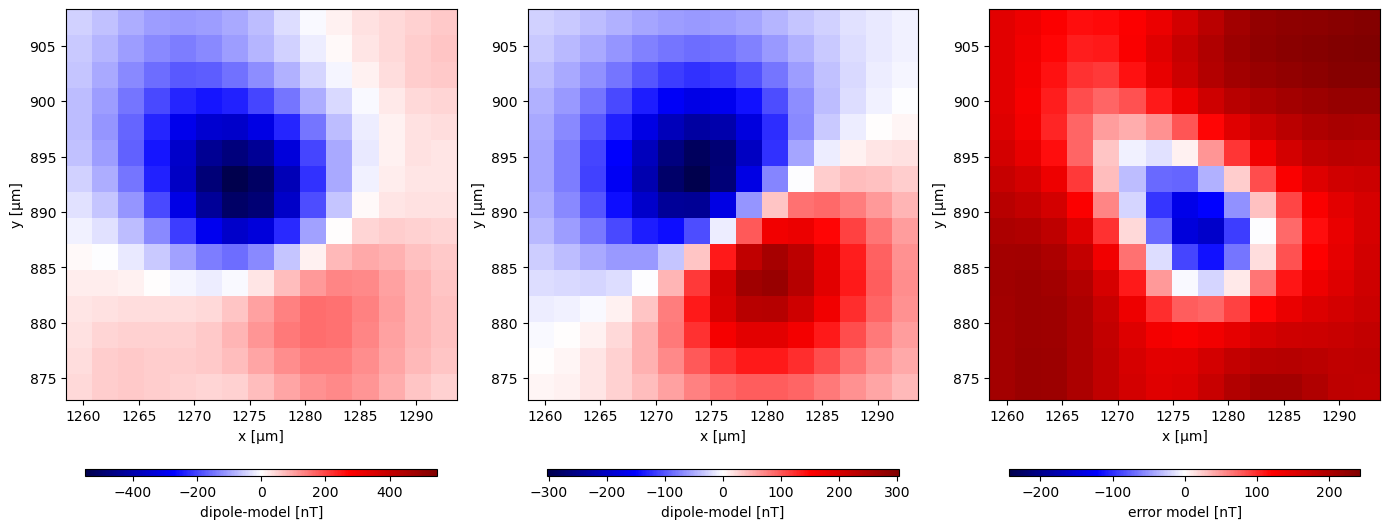

R²: 0.40650270979445924  | Dec: -14.787808756835883 | Inc: 23.182299253523393 | Amp: 5.153293972145515e-15
SNR: 4.67888757249038 |  Xc: 999.2238184525629 |  Yc: 1146.7698899010613 |  Zc: -0.5491612113947815


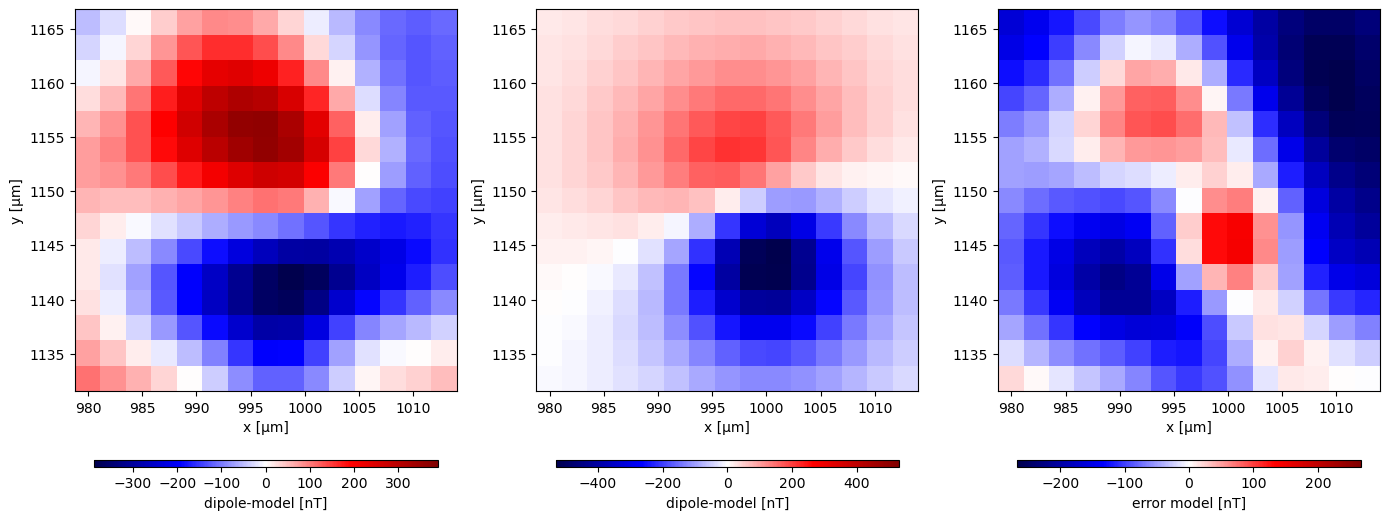

R²: 0.87892388148927  | Dec: 148.03191139678106 | Inc: -11.158009520981764 | Amp: 1.556607188017014e-13
SNR: 12.00776193832797 |  Xc: 1256.796454318747 |  Yc: 1113.7925045361653 |  Zc: -16.12058172681134


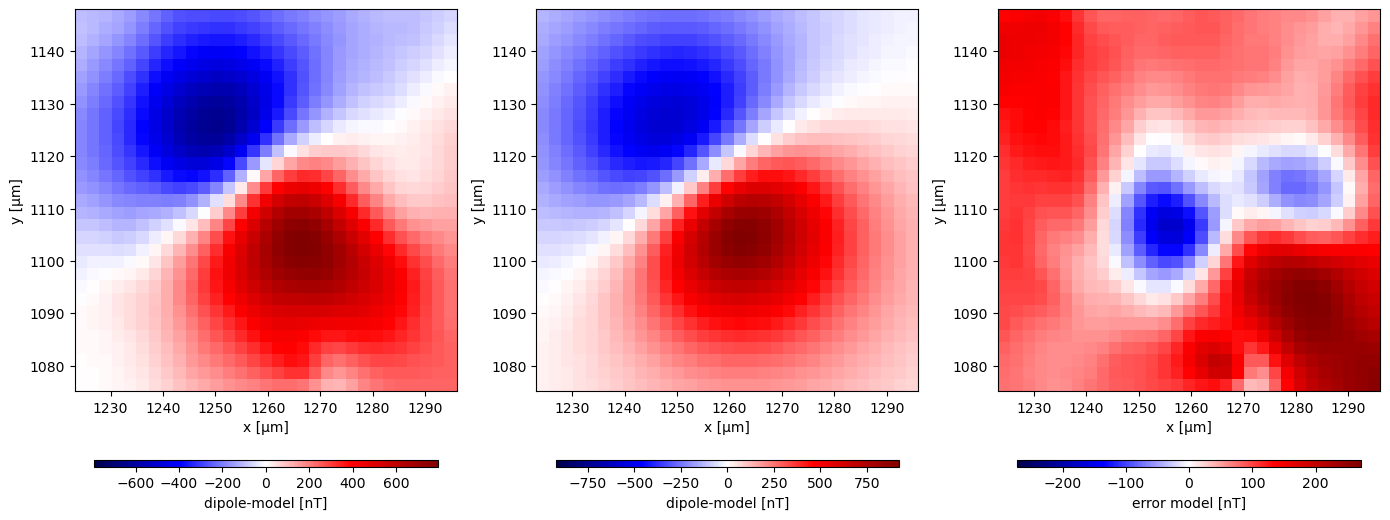

R²: 0.9729442919666091  | Dec: 168.79184932101091 | Inc: -22.93957851254399 | Amp: 3.126825055876557e-13
SNR: 16.086185733474167 |  Xc: 813.0706940794232 |  Yc: 351.09516953418296 |  Zc: -24.17458999505708


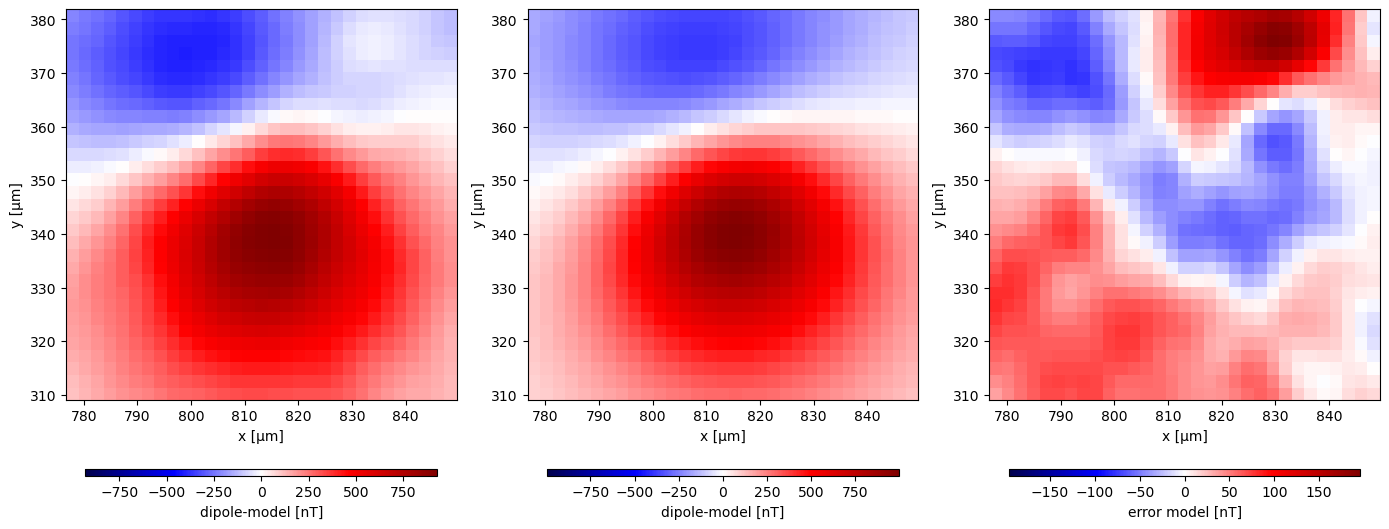

R²: 0.374568112482777  | Dec: 167.00748686654848 | Inc: -22.07808527685134 | Amp: 9.956602375784688e-14
SNR: 3.0539426969747785 |  Xc: 1448.939945201774 |  Yc: 1101.010332835227 |  Zc: -13.163680548759688


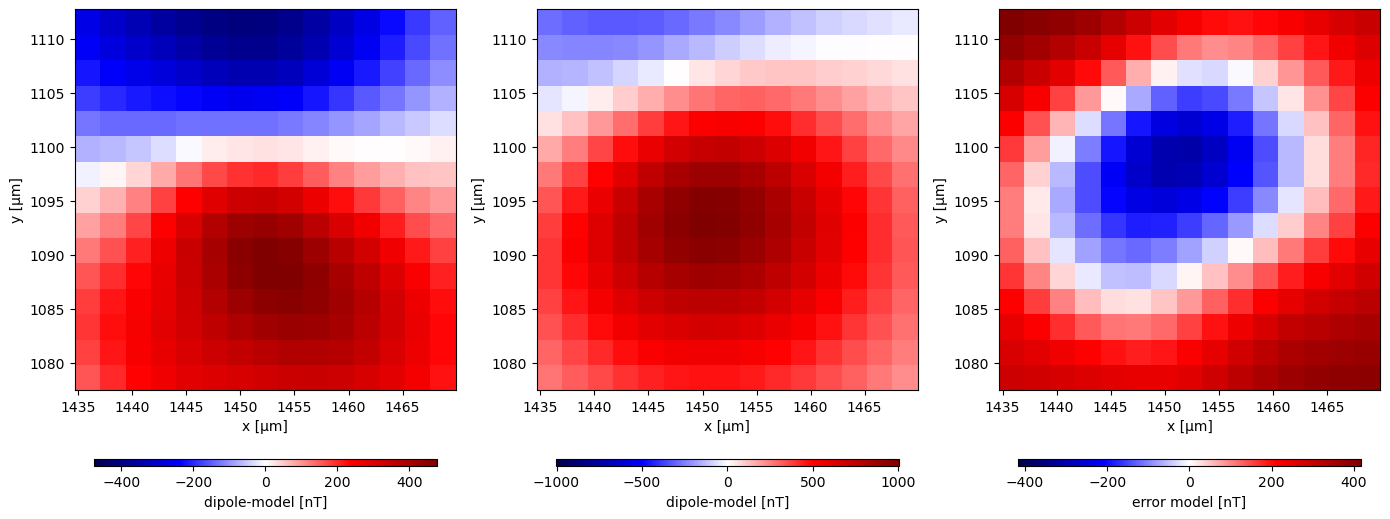

R²: 0.7477328193121935  | Dec: 174.31541830086056 | Inc: -26.424069748423744 | Amp: 8.4251909132832e-14
SNR: 6.543551358395928 |  Xc: 790.2575304055898 |  Yc: 203.98074003677283 |  Zc: -16.017091074568217


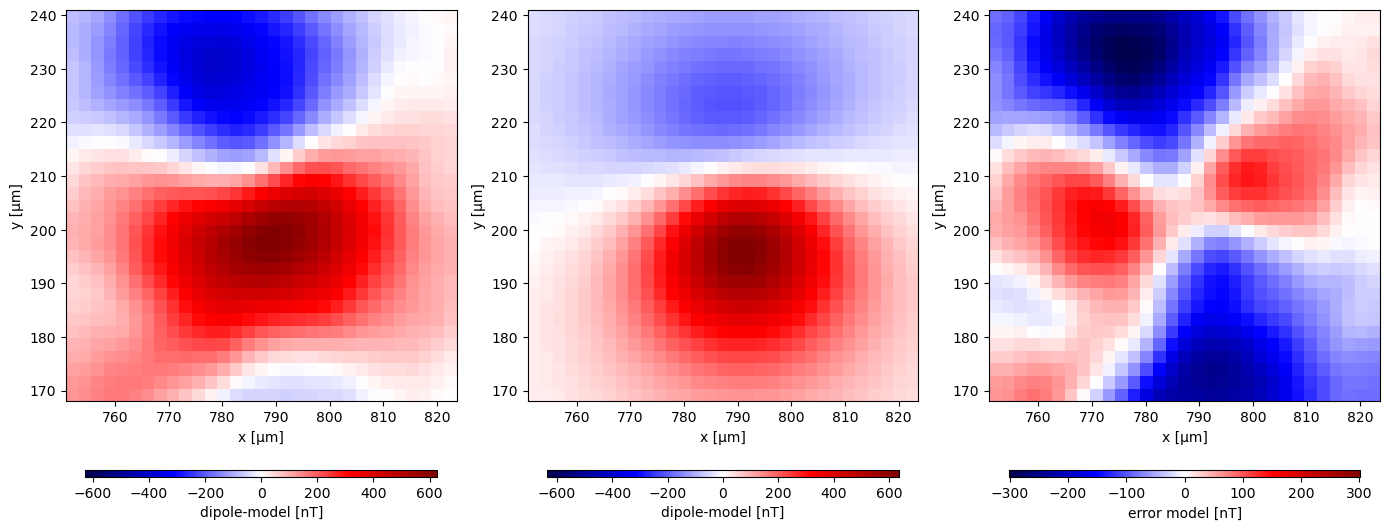

R²: 0.8838408527519126  | Dec: 14.586200581354015 | Inc: 2.3050807756873493 | Amp: 8.931670692072253e-15
SNR: 11.20009660090679 |  Xc: 983.6224563180865 |  Yc: 851.5212946354048 |  Zc: -4.778861688771285


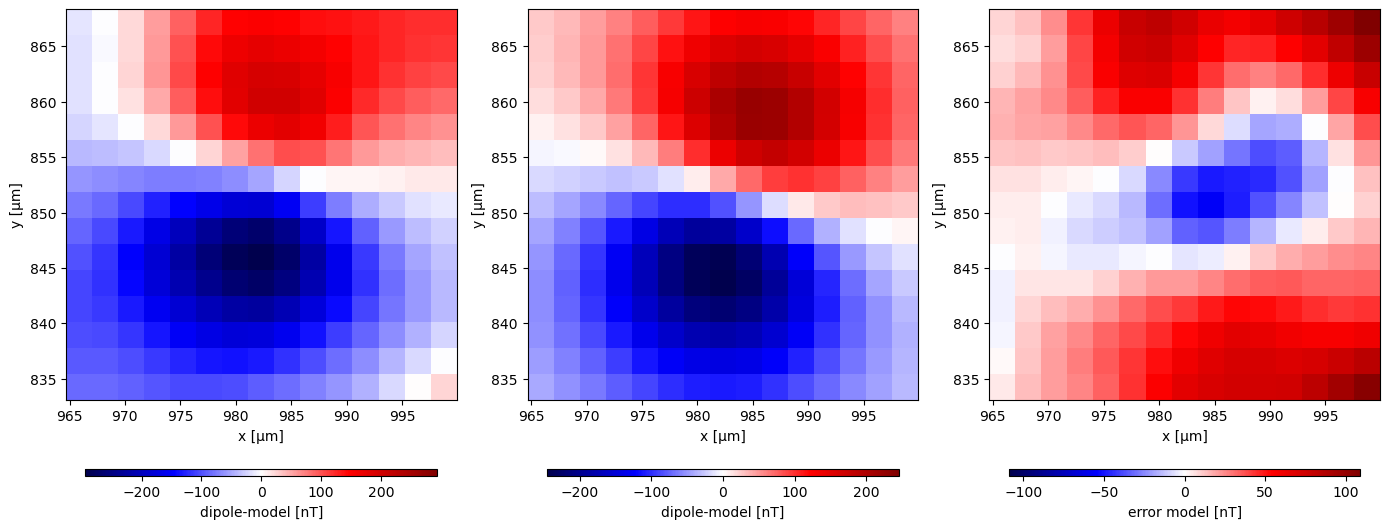

R²: 0.9911881415385823  | Dec: -166.84654193279331 | Inc: -8.23331272973012 | Amp: 8.899474699503514e-12
SNR: 21.560525456195343 |  Xc: 2025.8249395766534 |  Yc: 445.41087112559467 |  Zc: -71.94852360957279


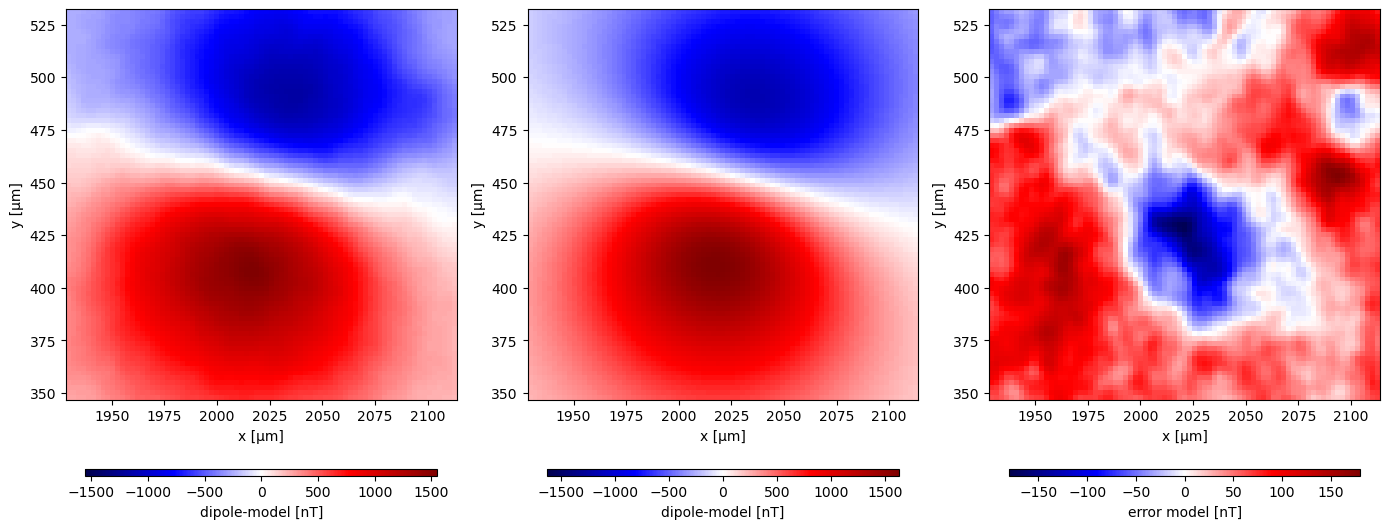

R²: 0.25691487254208867  | Dec: -163.23518357915648 | Inc: -29.367969294001462 | Amp: 1.710442571416535e-14
SNR: 3.9007577020304103 |  Xc: 1294.2569922682862 |  Yc: 991.1697313242443 |  Zc: -6.086697577358445


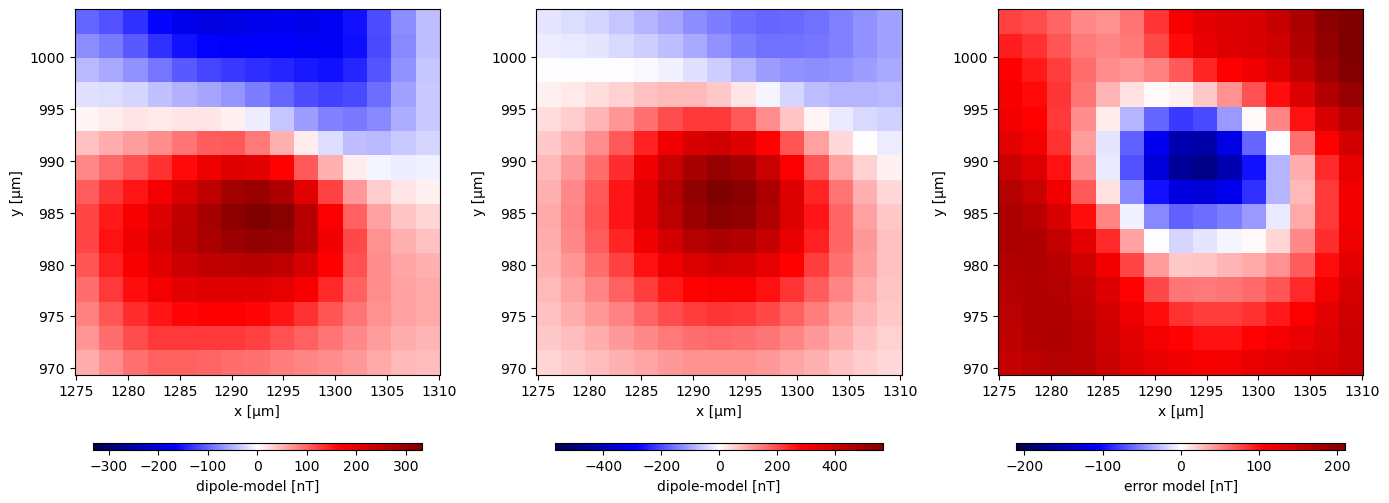

R²: 0.593556857830158  | Dec: -166.94668070464218 | Inc: 31.99564245453866 | Amp: 2.267784235285496e-14
SNR: 5.374478268345802 |  Xc: 981.6993291367787 |  Yc: 969.4687696838237 |  Zc: -9.097141507817051


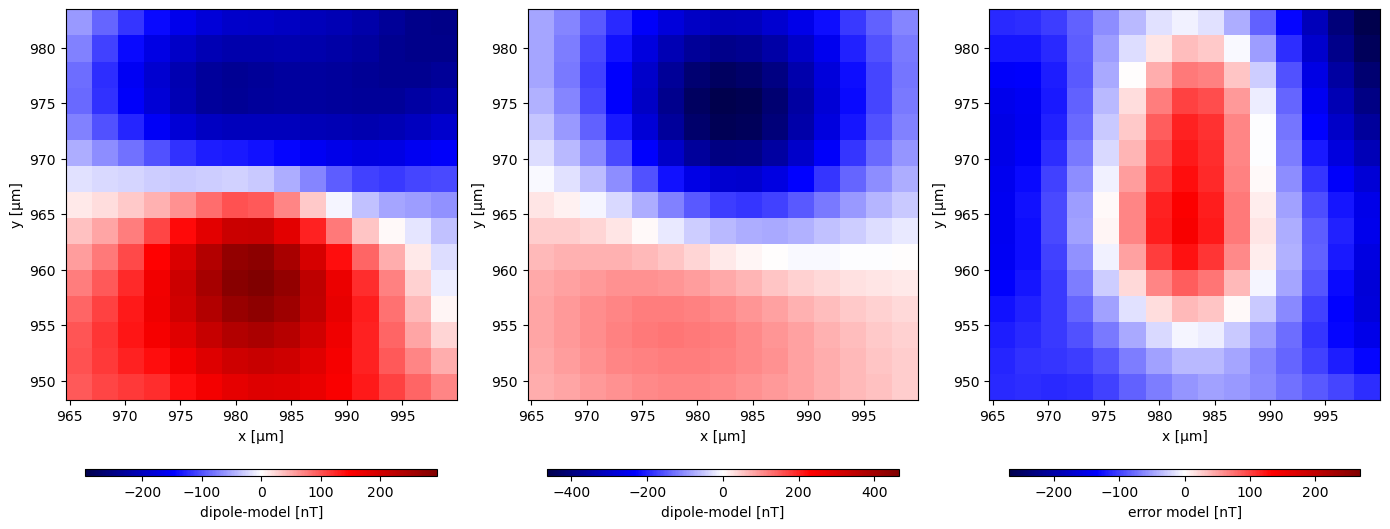

R²: -11.264898183532702  | Dec: -154.36433753334694 | Inc: 60.97216039657066 | Amp: 4.393992672286276e-15
SNR: -4.6341237850987955 |  Xc: 447.6719825844851 |  Yc: 950.7197826612611 |  Zc: -0.8005498998847796


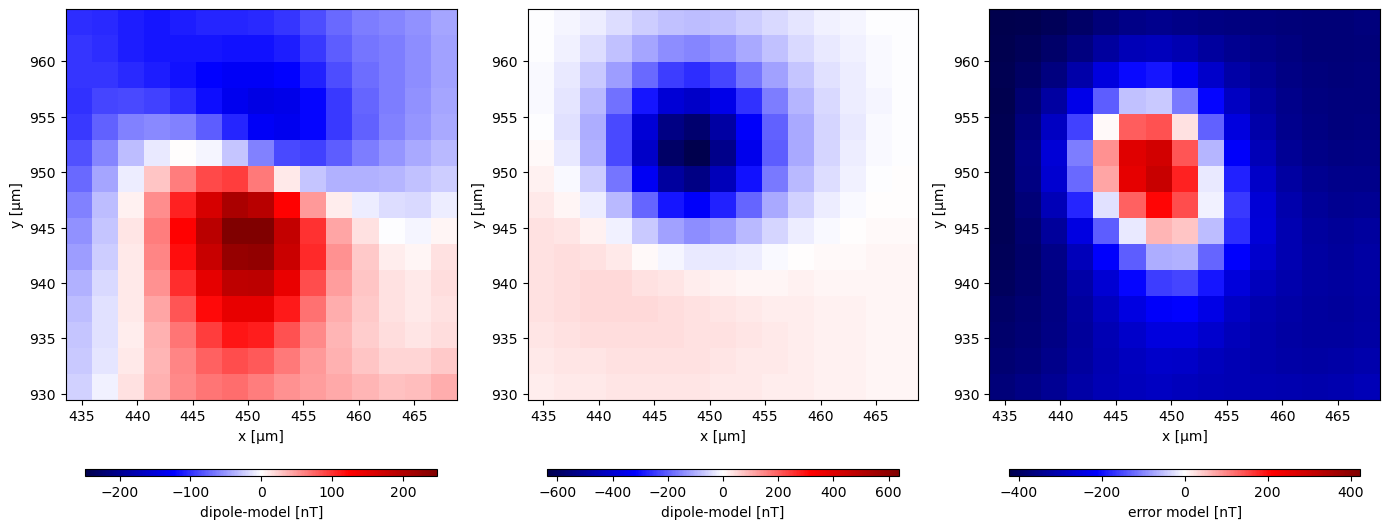

R²: 0.5521528683369739  | Dec: -167.5199856858887 | Inc: 5.4938159587569855 | Amp: 2.7857268603070663e-14
SNR: 4.577809729947027 |  Xc: 2002.6301914172764 |  Yc: 830.3585304566295 |  Zc: -11.379012891157176


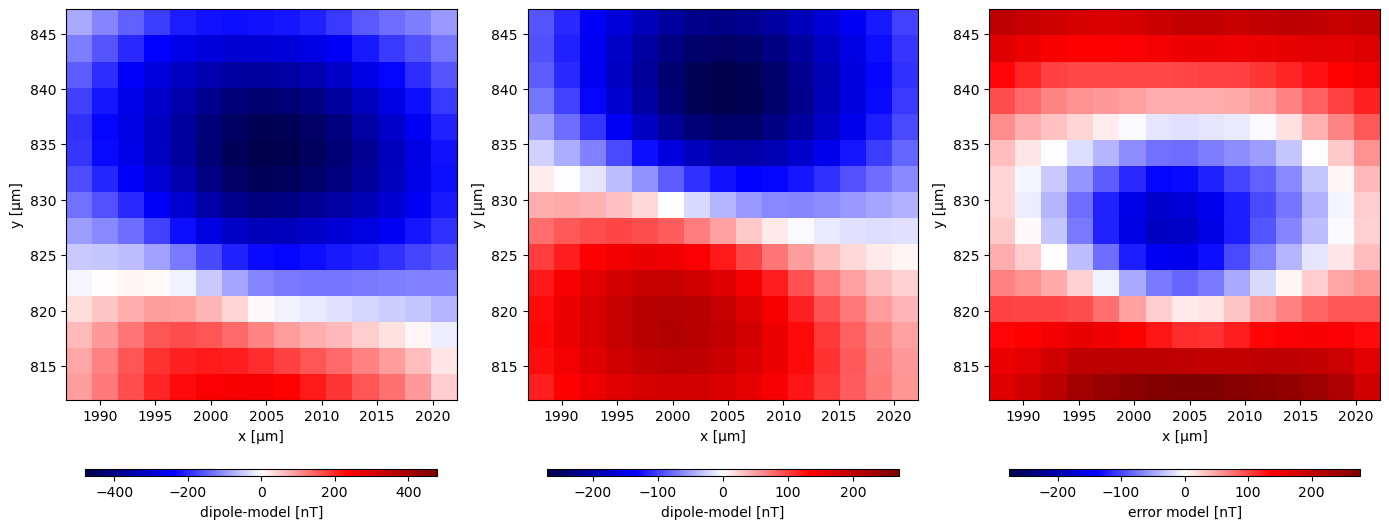

R²: -3.9378178841379423  | Dec: 5.630898568996627 | Inc: 46.09957255412472 | Amp: 1.49035975943515e-14
SNR: -3.413587053342517 |  Xc: 460.87781579291834 |  Yc: 1029.854447156407 |  Zc: -4.860466827428445


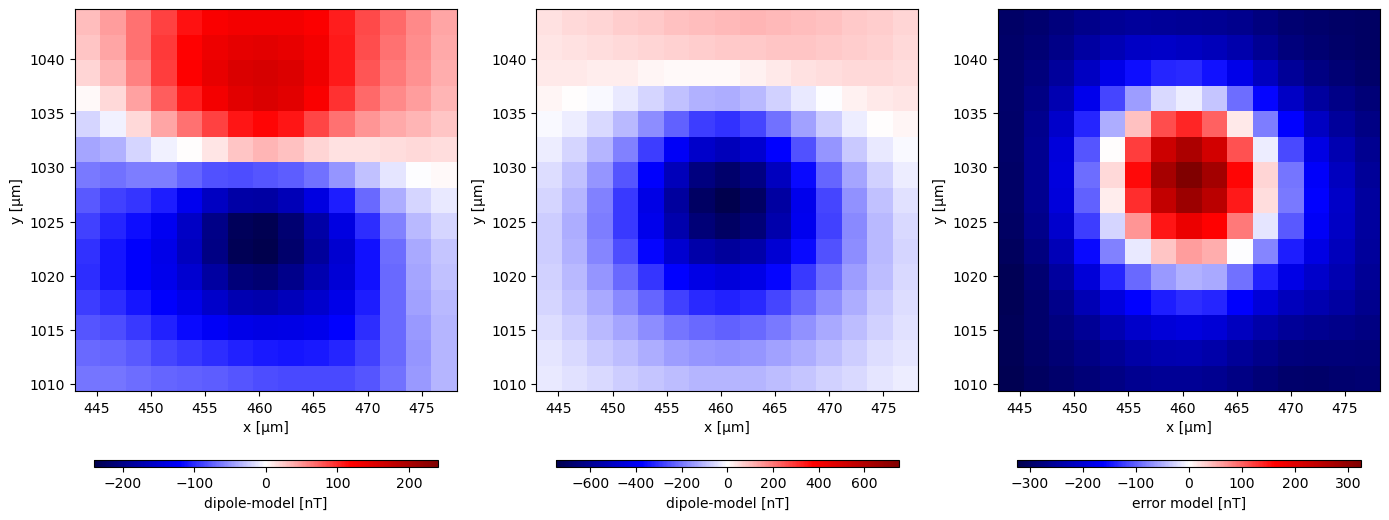

R²: 0.8561122246361701  | Dec: 53.58335732401097 | Inc: -9.302723042193831 | Amp: 7.642961269761429e-14
SNR: 8.769505625473968 |  Xc: 598.7751478997535 |  Yc: 1188.67621891455 |  Zc: -19.660823657981375


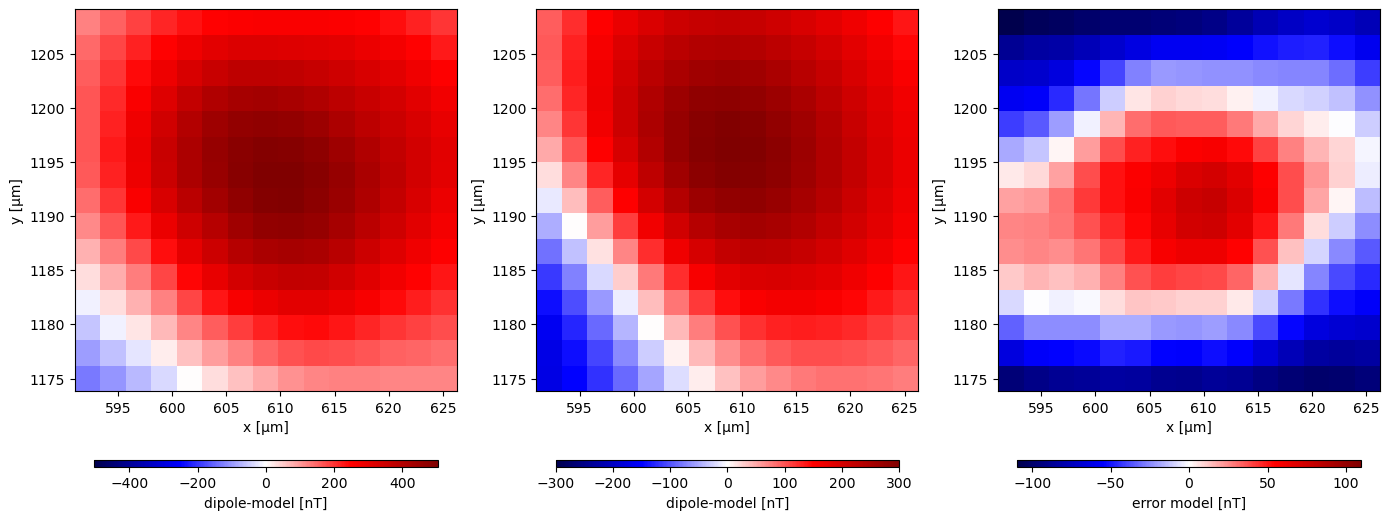

R²: 0.9857339963277235  | Dec: -174.20362906349862 | Inc: -8.064278524419684 | Amp: 1.6497401151875117e-12
SNR: 18.530434824569014 |  Xc: 1040.1323422667244 |  Yc: 931.5012255381423 |  Zc: -45.98580711063321


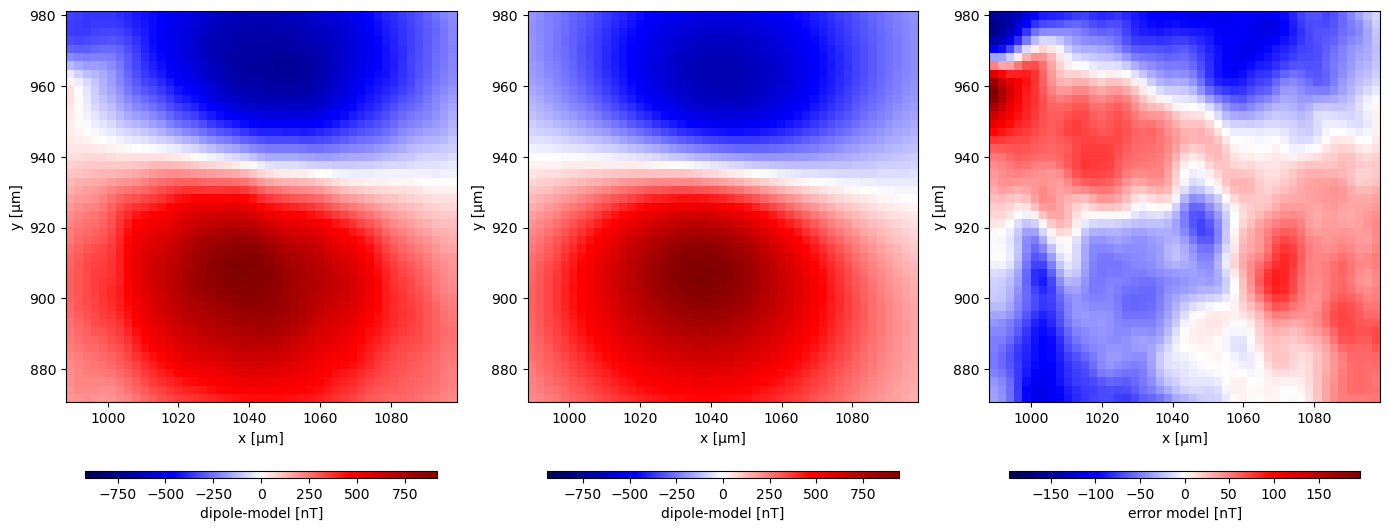

R²: 0.9193040905090301  | Dec: 132.49879560134067 | Inc: -12.157205930205635 | Amp: 3.2203021663441183e-15
SNR: 13.875893782588546 |  Xc: 1128.435527180643 |  Yc: 1090.4112876213312 |  Zc: -1.57279261522497


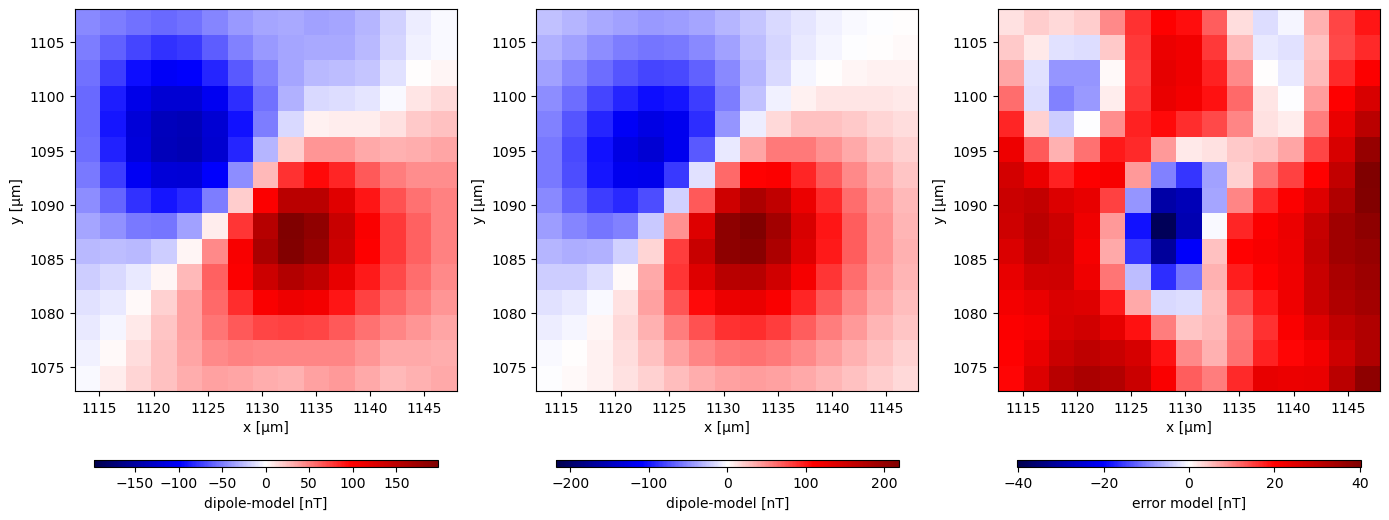

R²: 0.9741854987965507  | Dec: -6.875802266931626 | Inc: -3.0903054233879006 | Amp: 4.3351008057129926e-14
SNR: 16.641423032067063 |  Xc: 1989.7217704360128 |  Yc: 738.3715129645142 |  Zc: -12.9312463278353


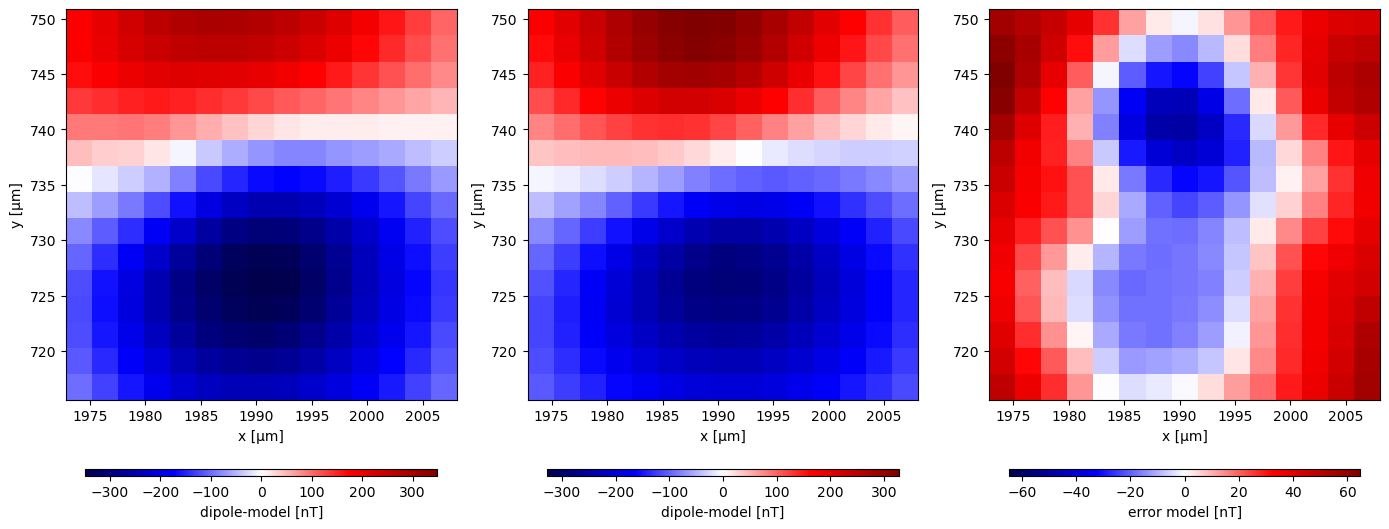

R²: 0.035787298834607295  | Dec: -24.010127904141378 | Inc: -33.31819070896857 | Amp: 1.8781360460502947e-14
SNR: 1.5032134943815985 |  Xc: 1569.8224834645412 |  Yc: 883.7168986163572 |  Zc: -9.904254291202749


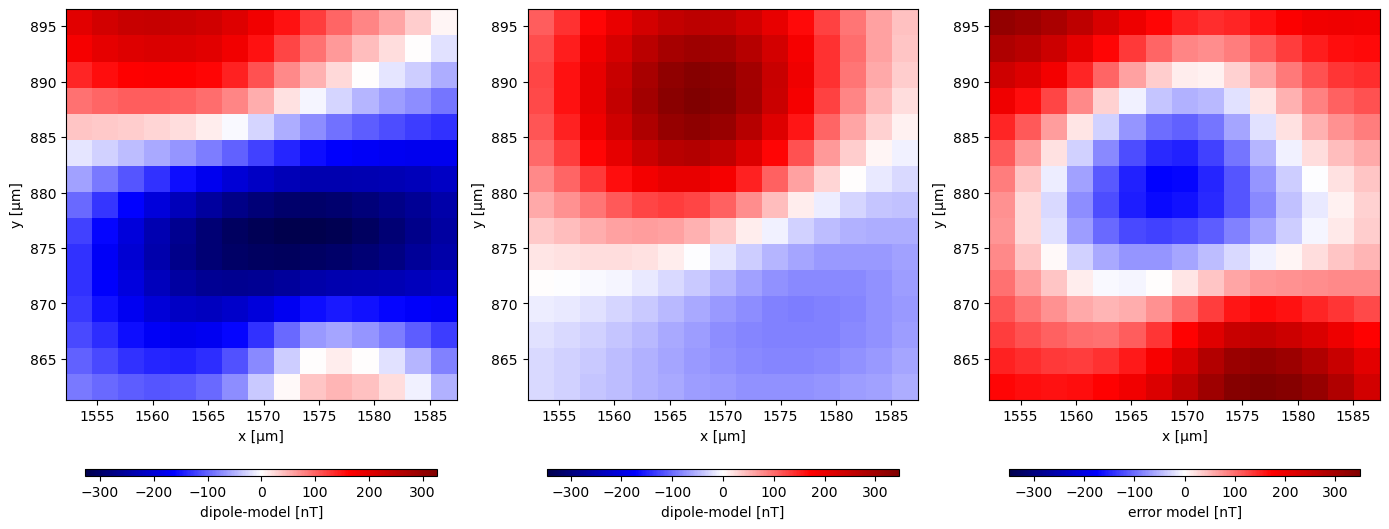

R²: -0.5622661964617448  | Dec: 127.9901233791051 | Inc: 43.267750009543406 | Amp: 5.166513116633949e-15
SNR: 0.8391812228530166 |  Xc: 362.4005092609513 |  Yc: 465.4382025441538 |  Zc: -2.744900006867989


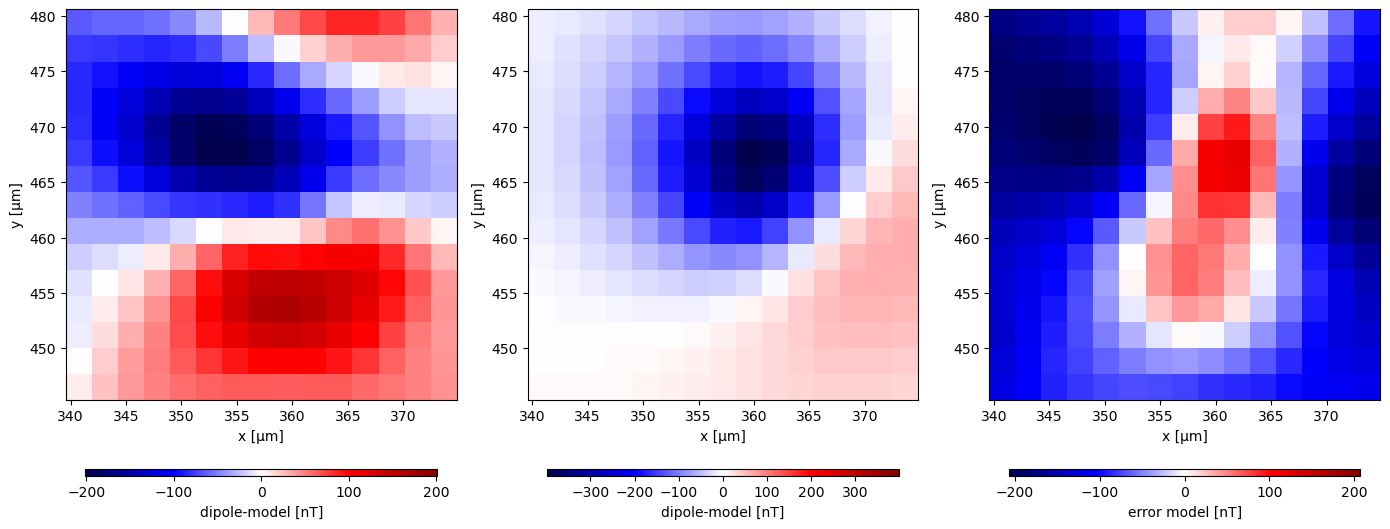

R²: -1.3765043919328392  | Dec: -168.2591576943699 | Inc: 39.40526947485793 | Amp: 9.320406237311421e-15
SNR: -0.6989644564991886 |  Xc: 1479.3946246427329 |  Yc: 642.4825130155654 |  Zc: -4.682845536798519


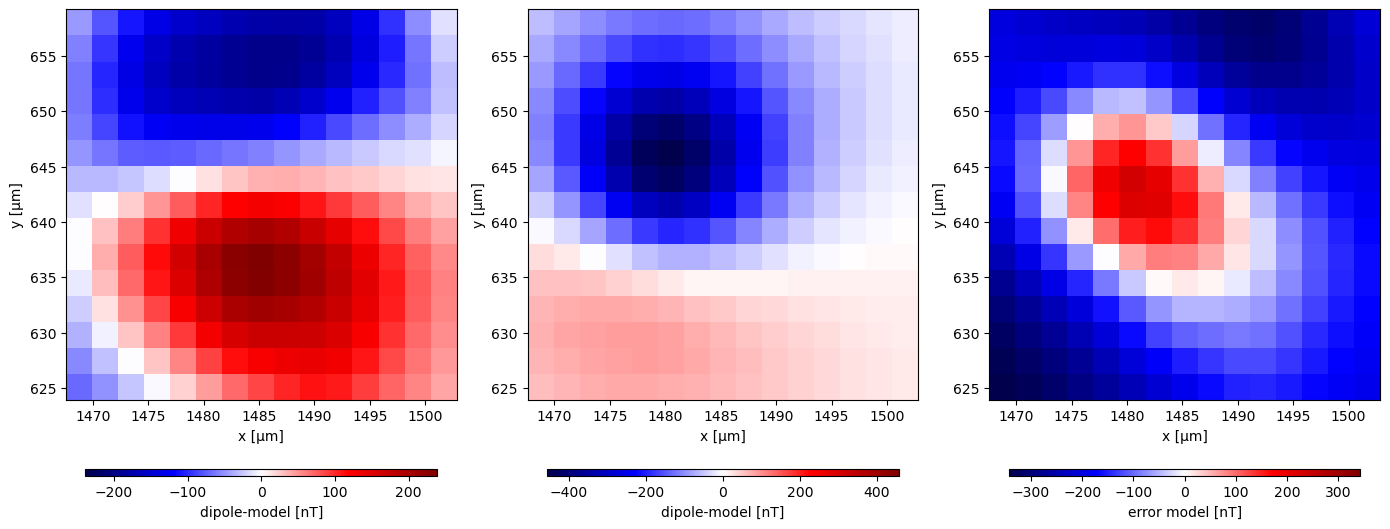

R²: -2.6342597669950463  | Dec: -153.6015802541806 | Inc: -46.91083605447948 | Amp: 2.6498167456136623e-15
SNR: -0.37324445965822883 |  Xc: 443.676791878219 |  Yc: 819.6100621664925 |  Zc: -0.21175162232132705


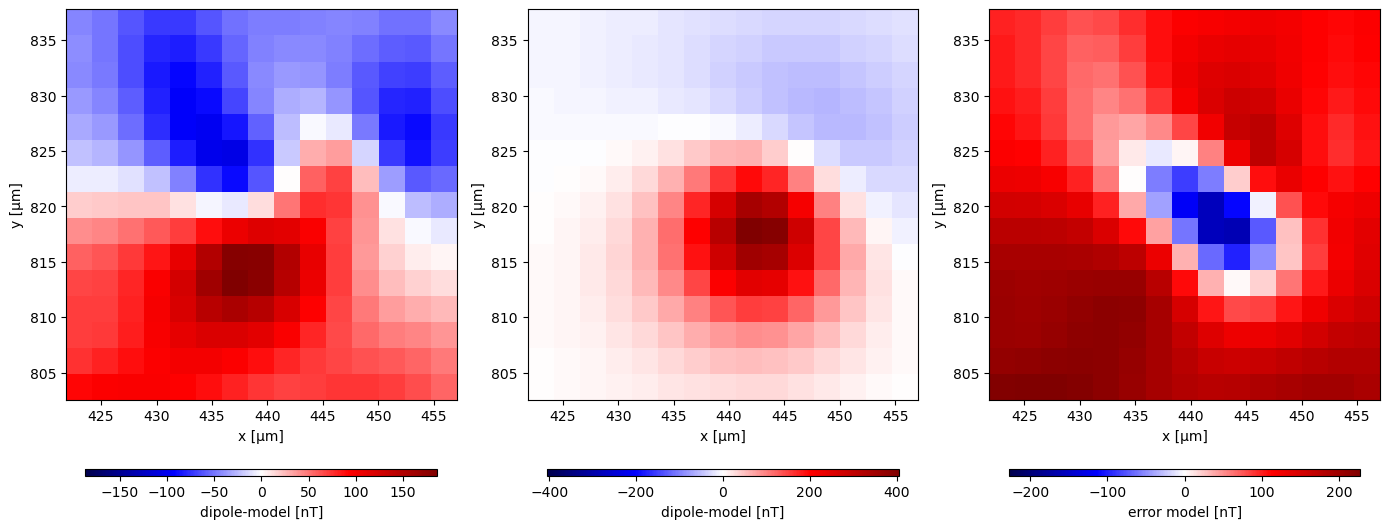

R²: 0.5449665568295645  | Dec: -4.310264614973916 | Inc: 24.854467591625948 | Amp: 7.238824545854314e-14
SNR: 4.293225012550298 |  Xc: 314.2533494961302 |  Yc: 970.3438062323197 |  Zc: -14.291383207339477


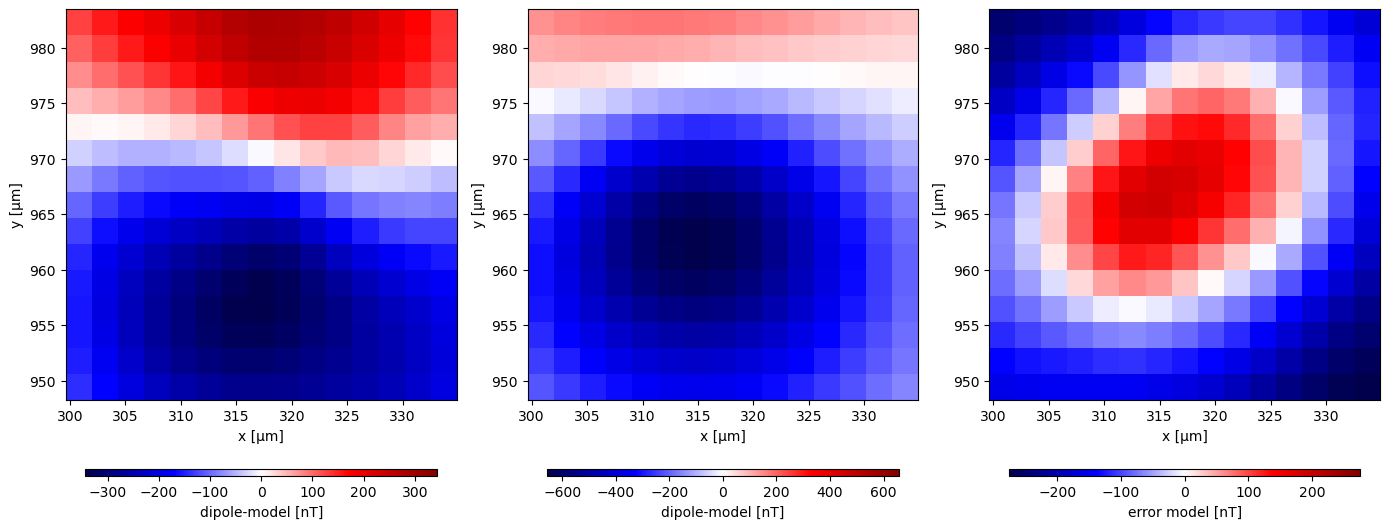

R²: 0.08393294743183177  | Dec: -179.58688305840778 | Inc: 47.26268291104788 | Amp: 5.018368949473413e-15
SNR: 3.272858268472176 |  Xc: 1300.318537796442 |  Yc: 665.1155470303415 |  Zc: -3.330145043636729


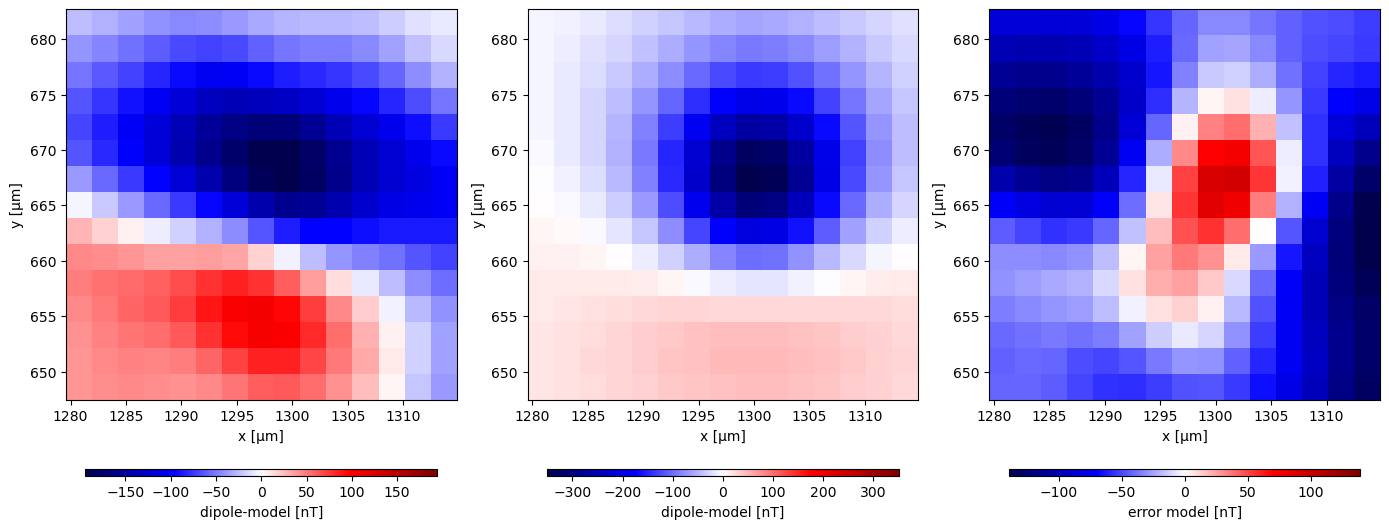

R²: 0.733298136372891  | Dec: 177.2789510838731 | Inc: -3.9321965736935196 | Amp: 4.33144075212853e-14
SNR: 5.757388715099303 |  Xc: 984.2398205108306 |  Yc: 667.0830329329112 |  Zc: -12.634615378432434


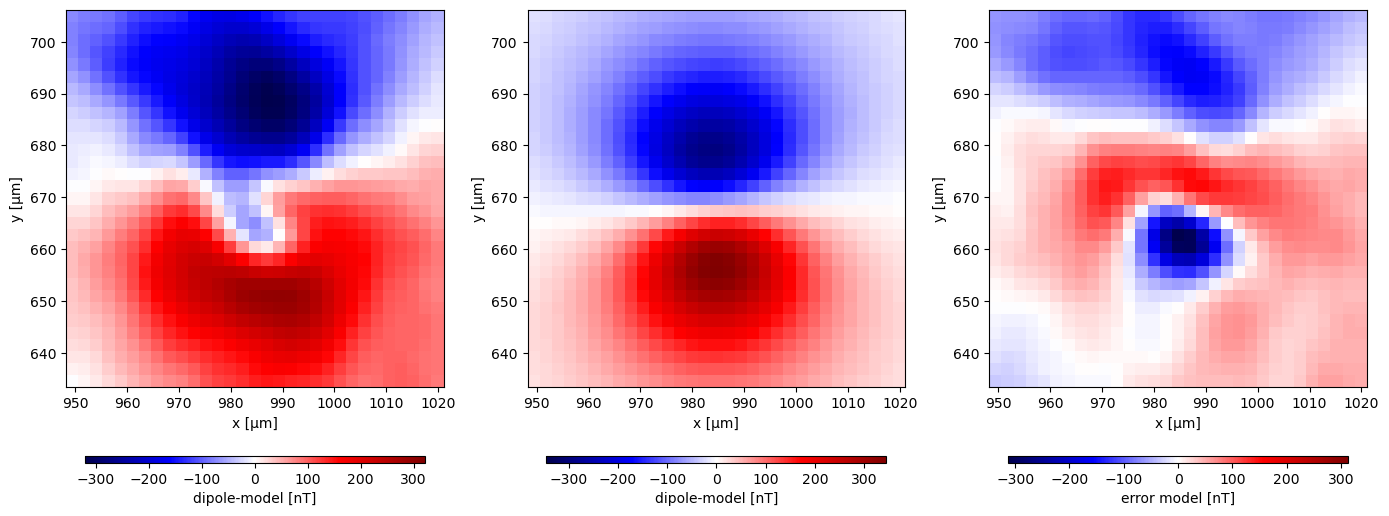

R²: -2.249513825617578  | Dec: -91.24295672844171 | Inc: -31.67430180919247 | Amp: 2.9865586849768e-15
SNR: -0.36228956388930594 |  Xc: 1544.2070424444662 |  Yc: 803.8003499994463 |  Zc: -0.6312193104484696


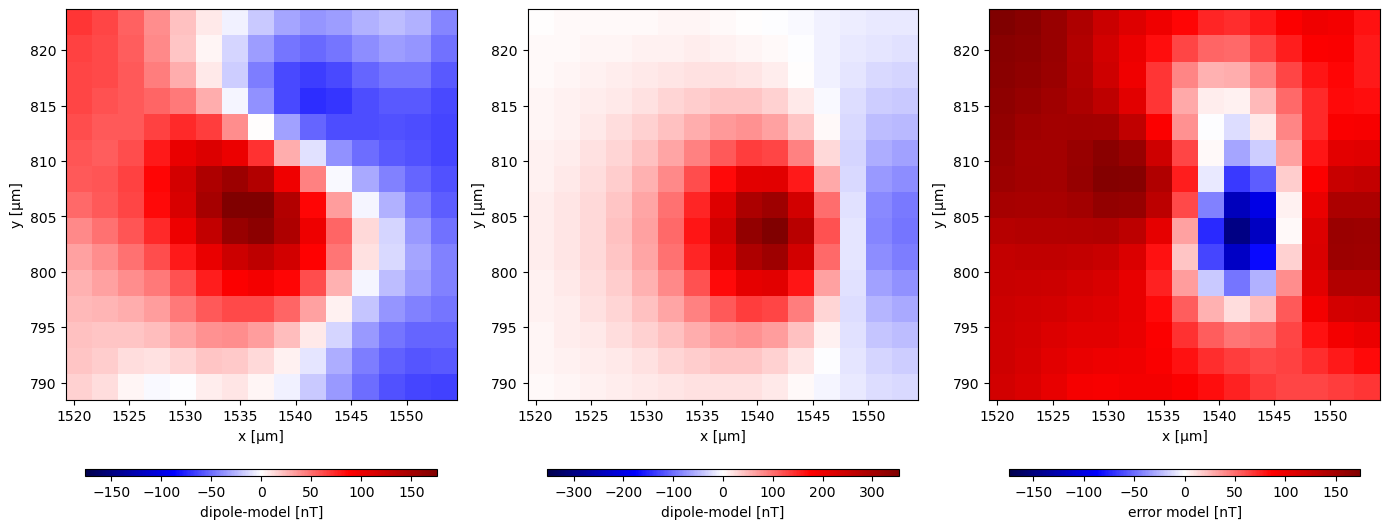

R²: 0.5820117928361142  | Dec: -9.769642997313026 | Inc: -15.457912306575345 | Amp: 1.5440608809352065e-14
SNR: 5.382936189951143 |  Xc: 1573.704297003096 |  Yc: 837.8673246687302 |  Zc: -7.639059935908985


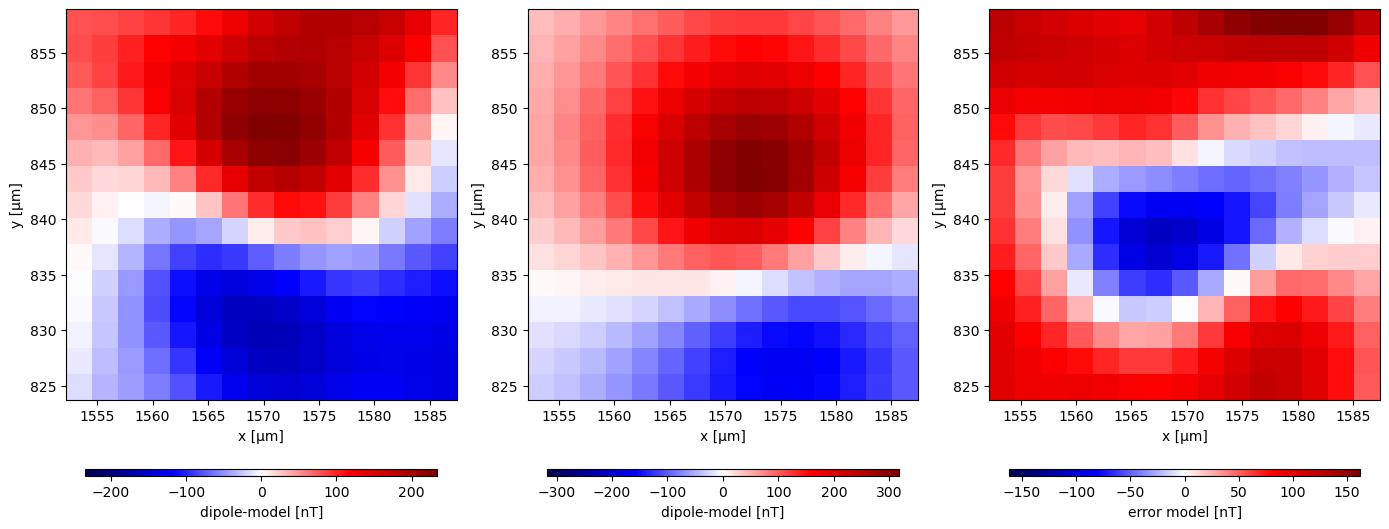

R²: -0.05067358784512965  | Dec: 124.39539345176705 | Inc: 2.5392946438918624 | Amp: 4.122689890230582e-15
SNR: 2.776233392755876 |  Xc: 1224.8471401125632 |  Yc: 153.4846501590938 |  Zc: -5.584725112369693


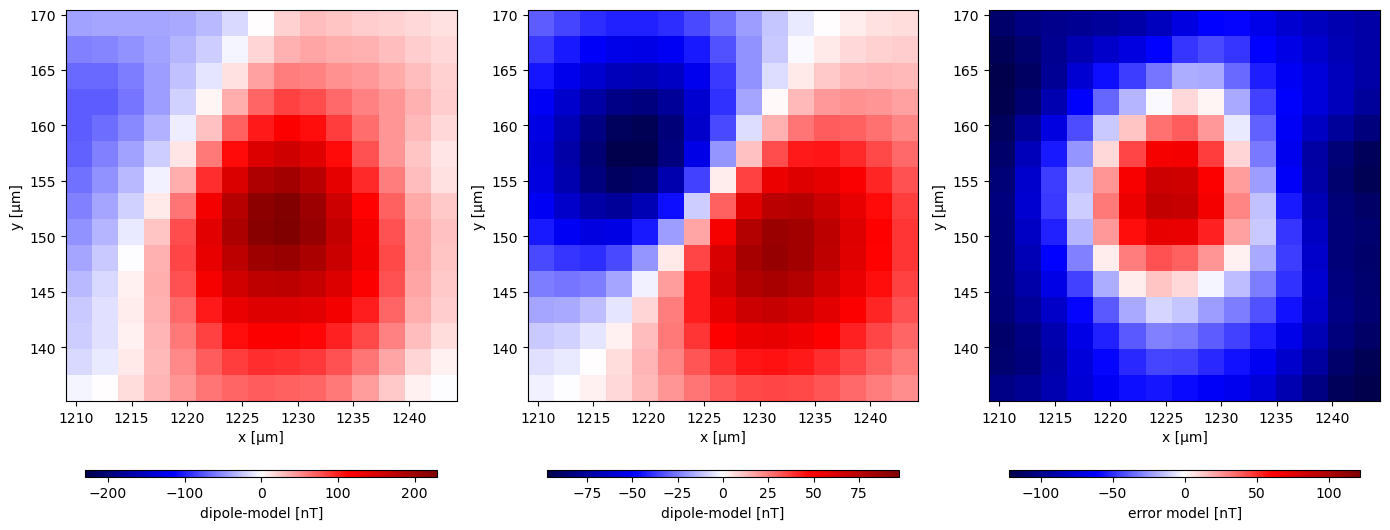

R²: -0.6286167390402462  | Dec: 173.46497856832323 | Inc: 22.64006966767347 | Amp: 2.273979068519767e-14
SNR: -0.047993794515427506 |  Xc: 597.580784785128 |  Yc: 1134.3095501780028 |  Zc: -7.681954324897906


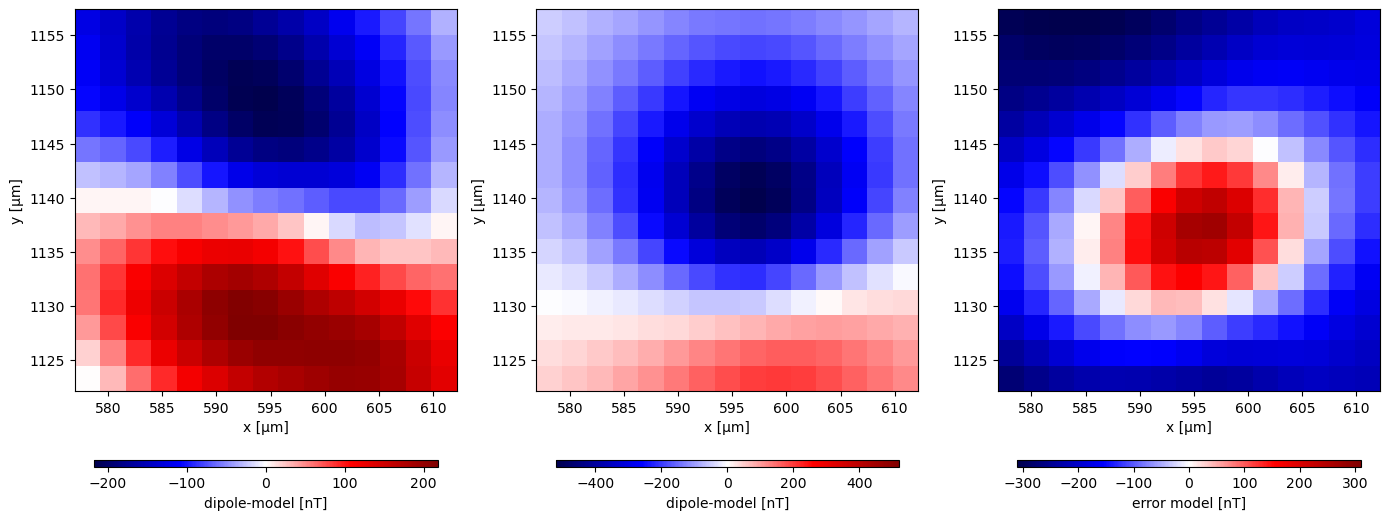

R²: 0.7960268109043943  | Dec: -148.69099711416223 | Inc: 3.0933487046274895 | Amp: 6.019922021819984e-15
SNR: 8.153287206293179 |  Xc: 738.2883064984045 |  Yc: 1296.6227872823765 |  Zc: -5.0372007606127855


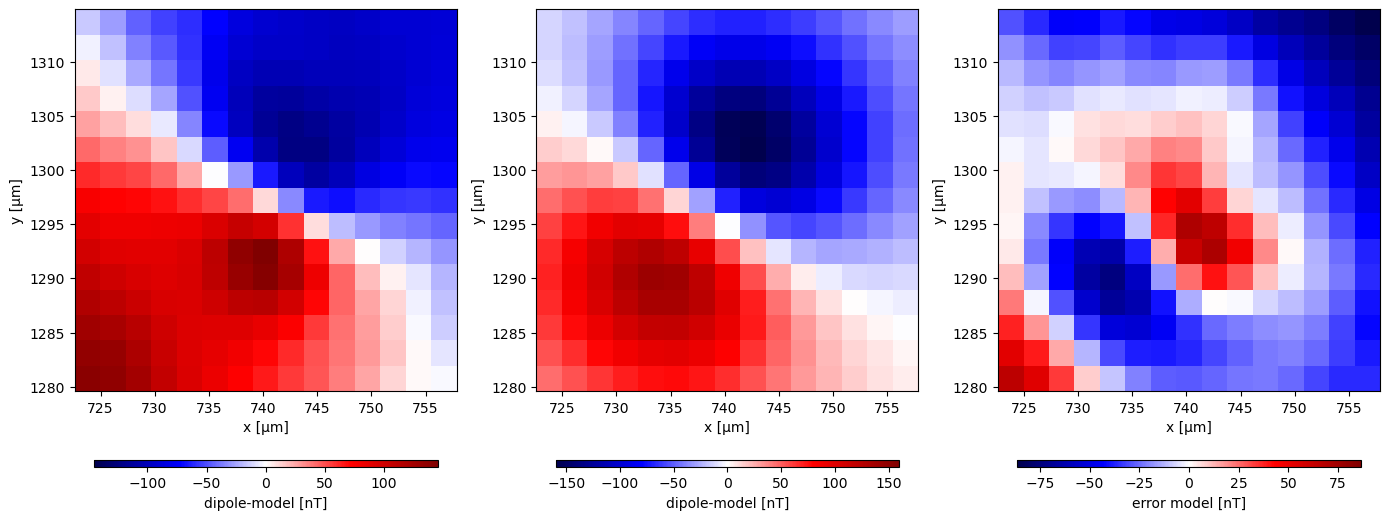

R²: -0.5938379239916161  | Dec: 152.63490154199636 | Inc: -31.3372291508547 | Amp: 2.2495544812374072e-15
SNR: 2.0703132404358984 |  Xc: 284.40125130143196 |  Yc: 806.673696212293 |  Zc: -0.6572169250963341


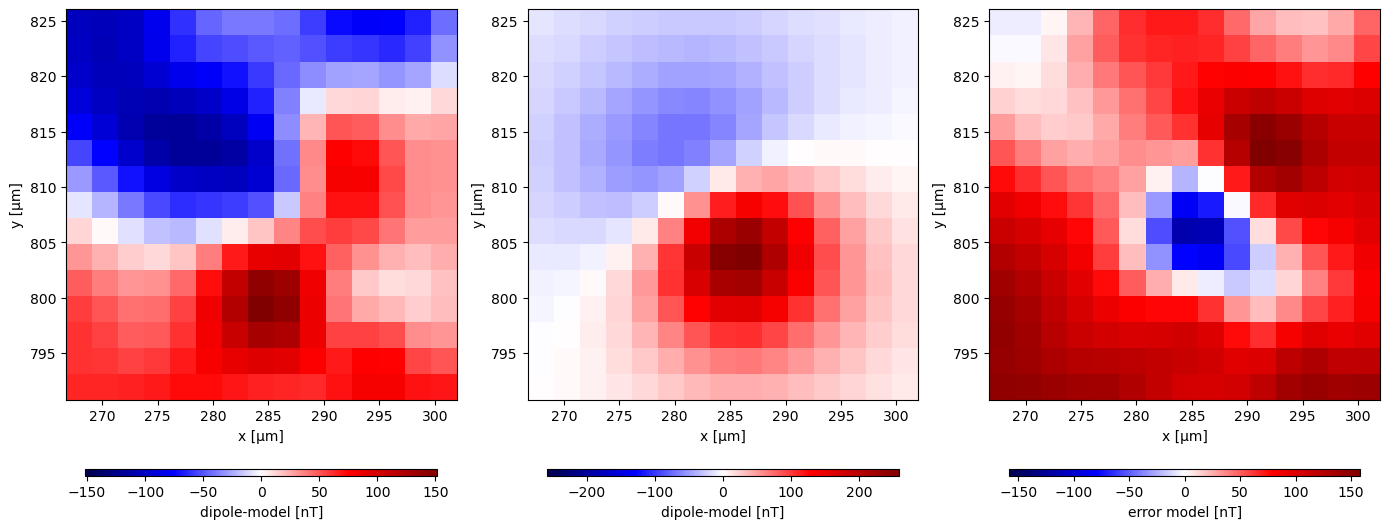

R²: 0.574070684549117  | Dec: 168.81560053605838 | Inc: 61.72985084499162 | Amp: 1.992820848010126e-14
SNR: 3.8862601553039777 |  Xc: 703.1634623193395 |  Yc: 1069.7542138805177 |  Zc: -12.757208748004254


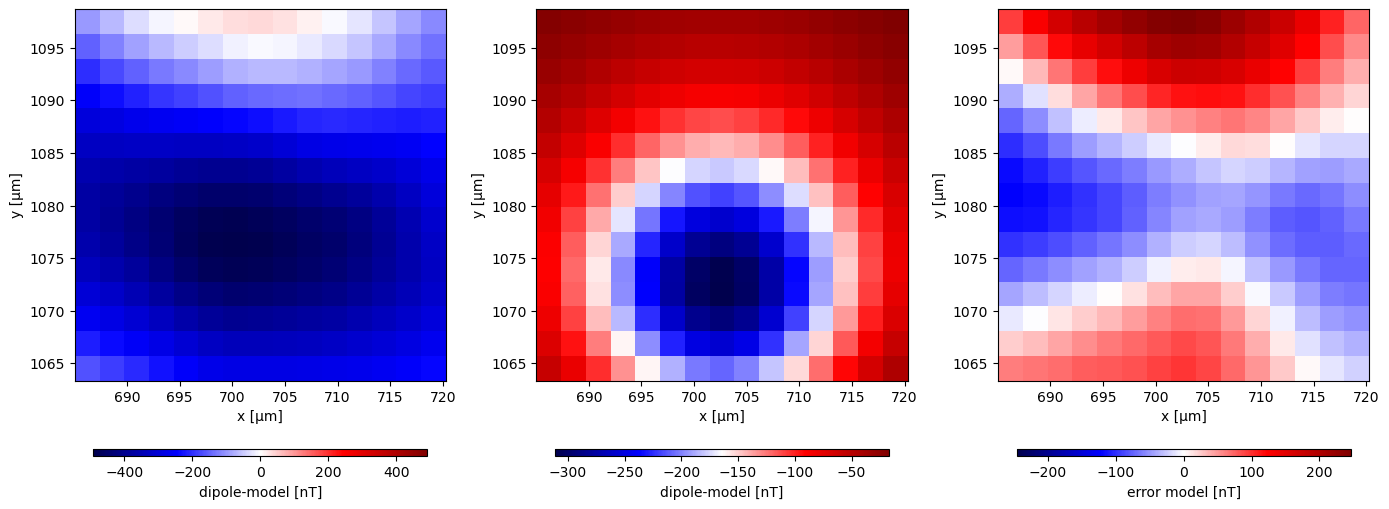

R²: -1.6915833050908673  | Dec: -84.5531837808743 | Inc: 20.230967791666437 | Amp: 1.7920873111328954e-15
SNR: -1.0568936513416556 |  Xc: 568.1655561052373 |  Yc: 1053.2295869032866 |  Zc: -0.22887703087777816


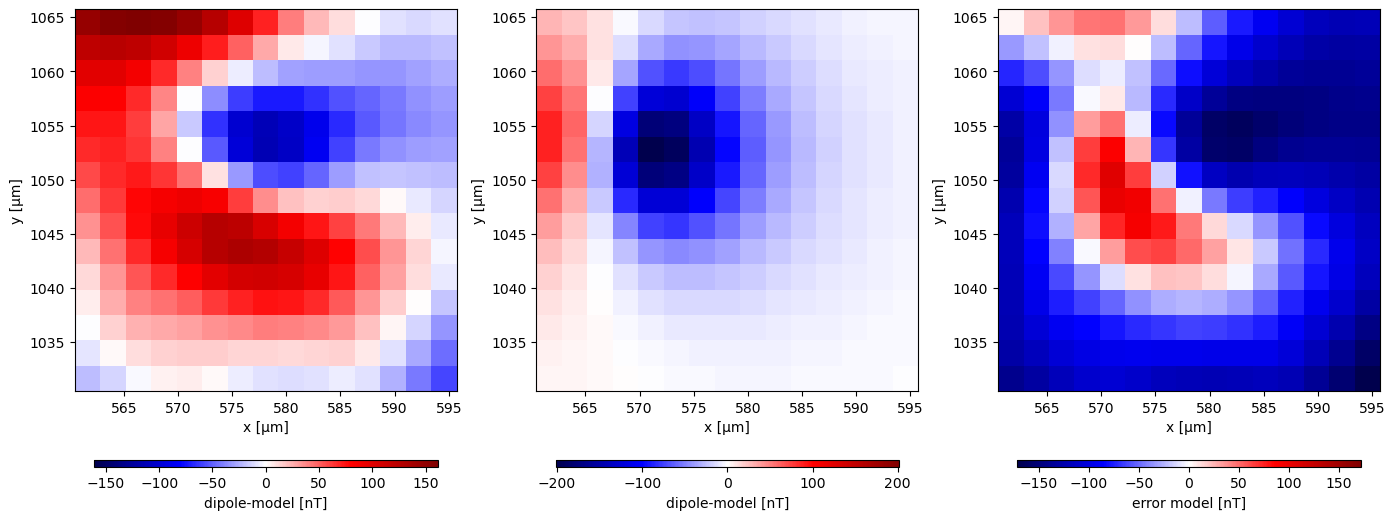

R²: 0.7312960884011501  | Dec: -151.62474300320332 | Inc: 18.372435921540923 | Amp: 2.6487651223078438e-14
SNR: 5.710691480903831 |  Xc: 985.3205055671248 |  Yc: 1135.2063259888748 |  Zc: -10.092284157519975


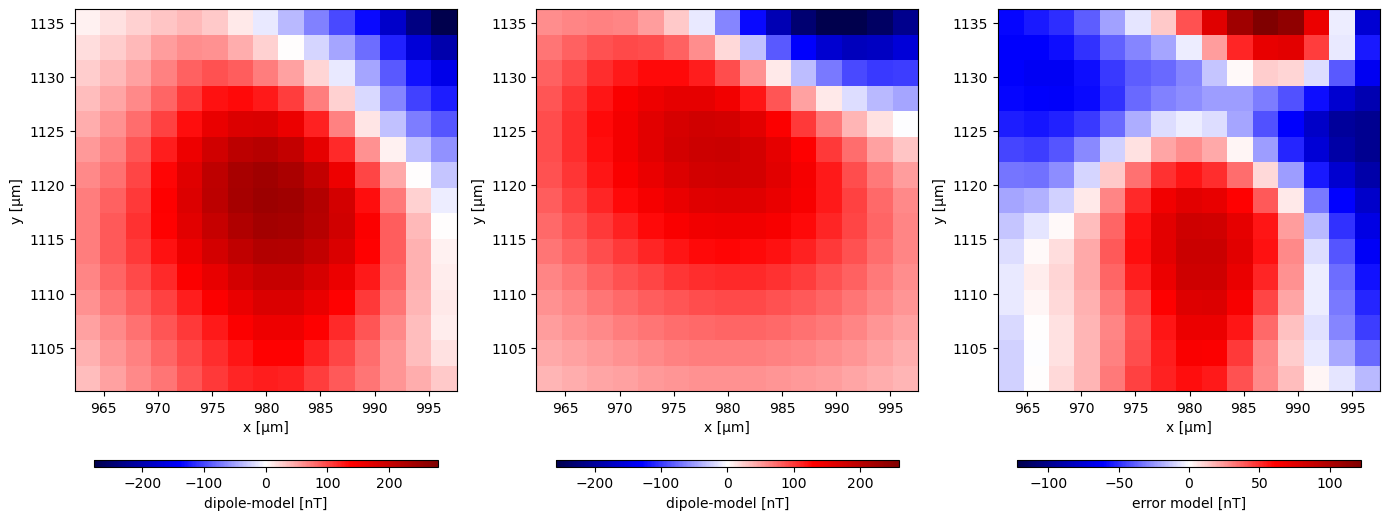

R²: 0.8005653548836287  | Dec: 165.70532884818996 | Inc: -2.299510706688927 | Amp: 4.114382077595604e-14
SNR: 8.153239972646961 |  Xc: 1045.0936802399651 |  Yc: 425.9284025330586 |  Zc: -14.005888272472625


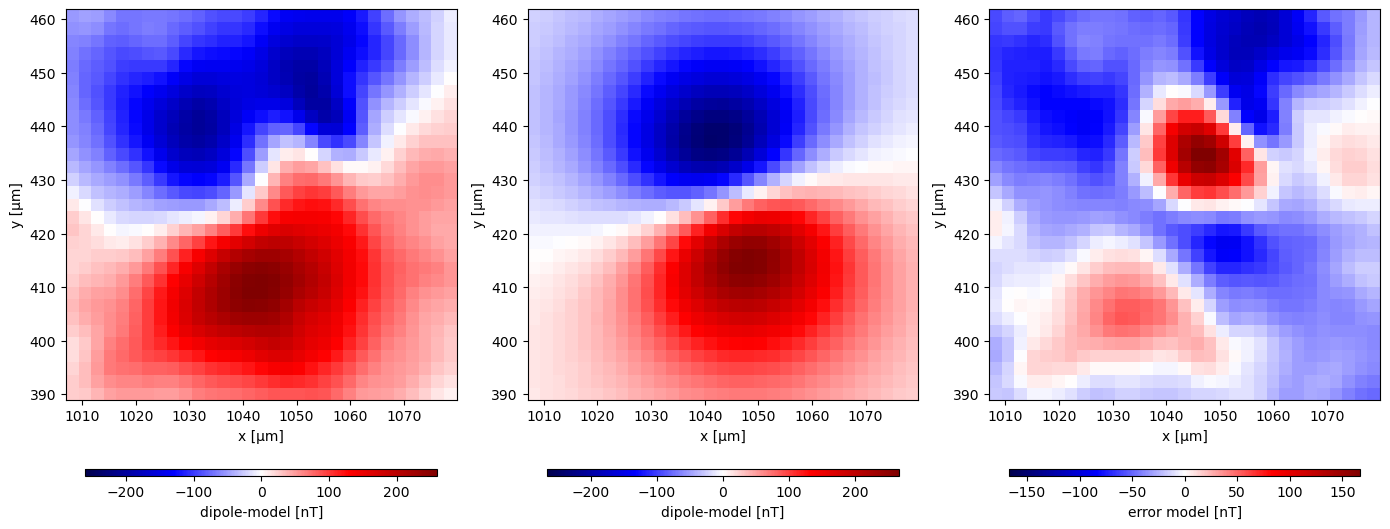

R²: -6.146181703348167  | Dec: 155.2720100734863 | Inc: 49.93519493329783 | Amp: 6.990334215374415e-15
SNR: -4.602173631586427 |  Xc: 814.230334482932 |  Yc: 901.2285765175025 |  Zc: -4.167757046699792


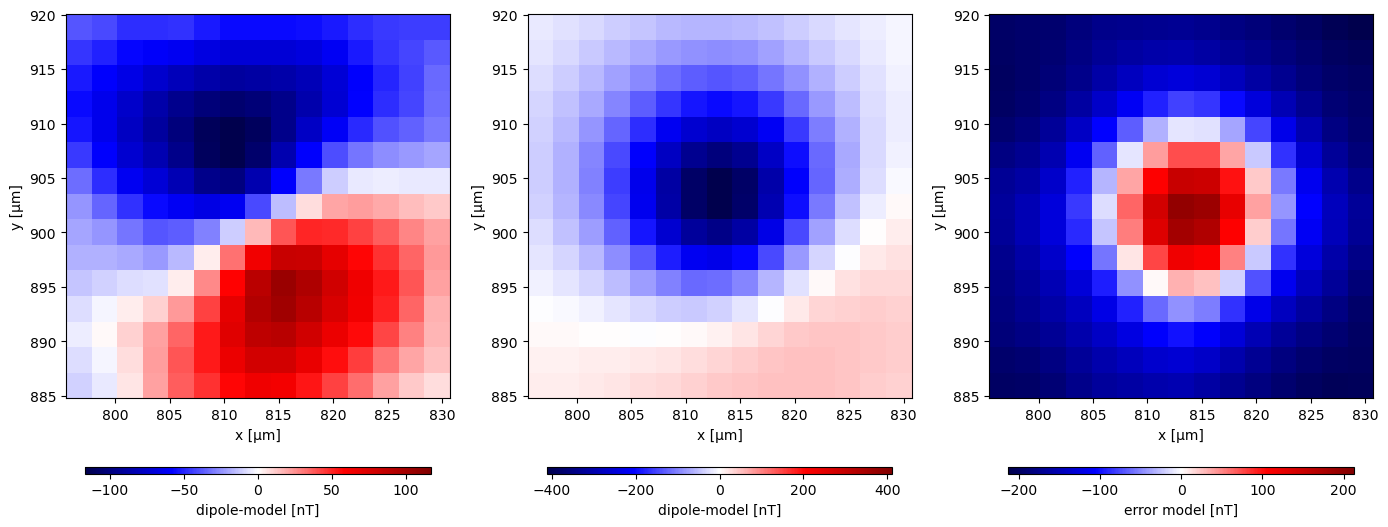

R²: 0.9685133097027685  | Dec: -178.01809108681613 | Inc: 10.092829811708583 | Amp: 1.148720322675928e-13
SNR: 15.032954334391395 |  Xc: 1262.4013658432536 |  Yc: 49.979609947719034 |  Zc: -22.552147837769947


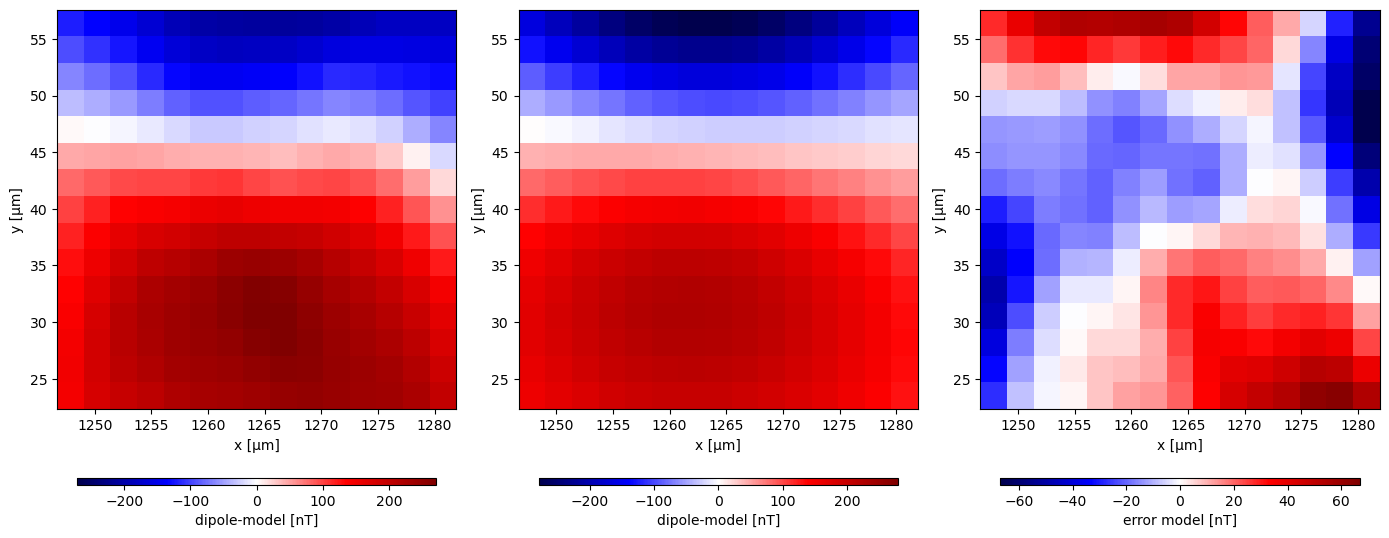

R²: -12.171654388667399  | Dec: -91.60534583369697 | Inc: 2.685876300360395 | Amp: 6.730397015751419e-14
SNR: -9.213240336480265 |  Xc: 1521.7675635785113 |  Yc: 1027.2077212470404 |  Zc: -4.602455310626898


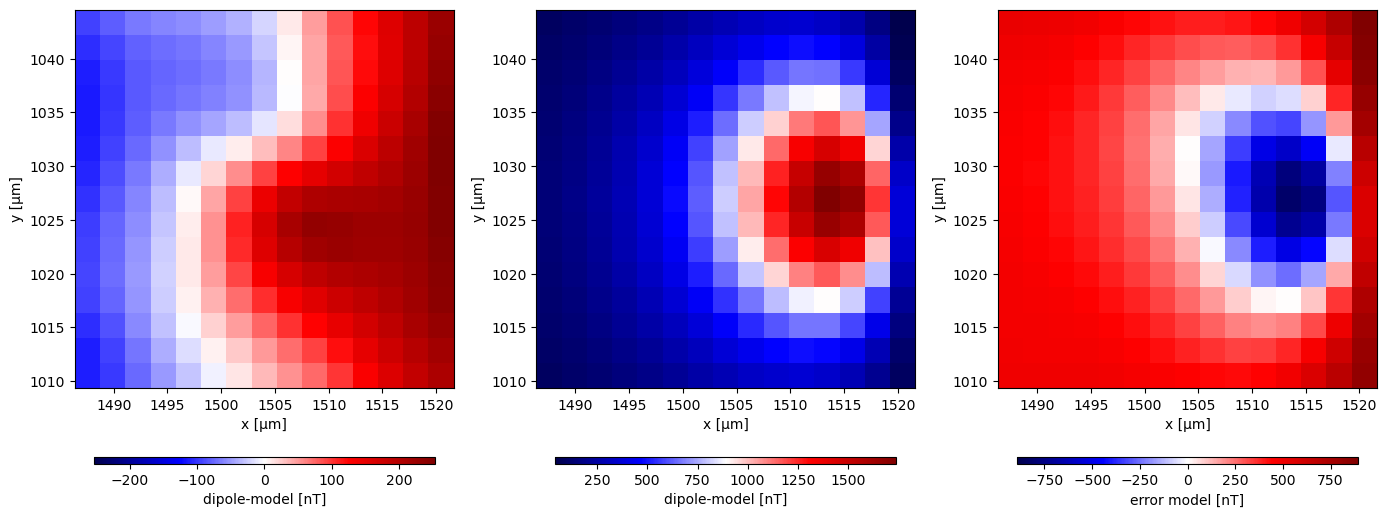

R²: -1.1159889218355379  | Dec: 34.85036014333908 | Inc: 60.13012880948899 | Amp: 4.917579247365104e-15
SNR: -0.651831484622667 |  Xc: 680.908466331223 |  Yc: 793.0734898550518 |  Zc: -3.5037760085938507


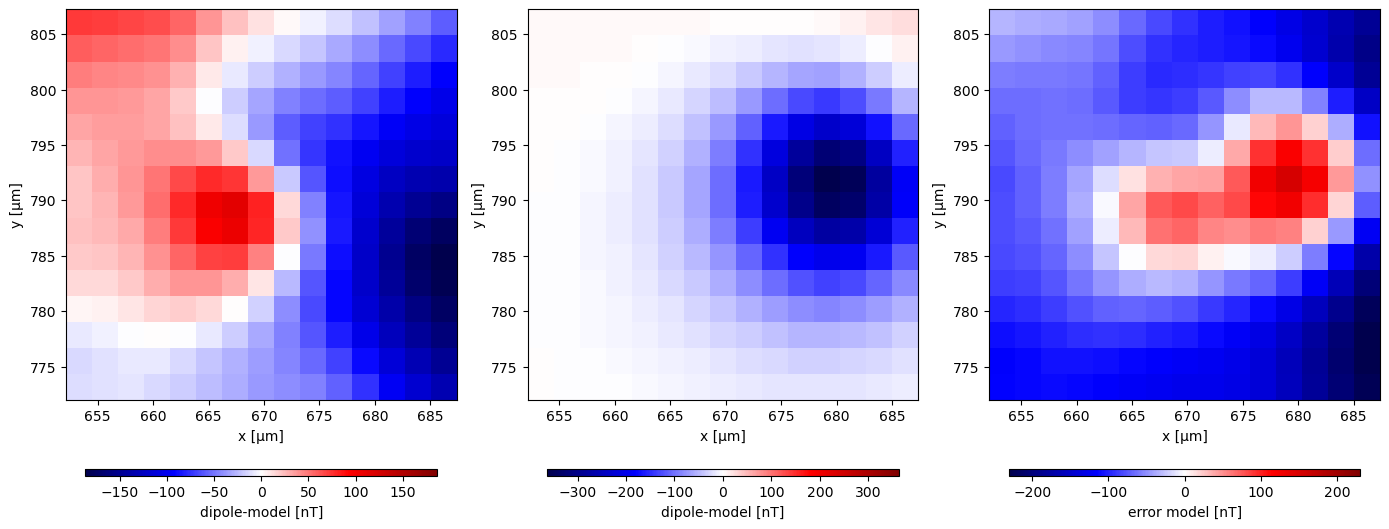

R²: -19.5176463060612  | Dec: -169.98738321583033 | Inc: -67.98864917088748 | Amp: 1.796299830468601e-15
SNR: -6.117895176198861 |  Xc: 1424.1321565054716 |  Yc: 1201.6053812483644 |  Zc: -0.02503506276554825


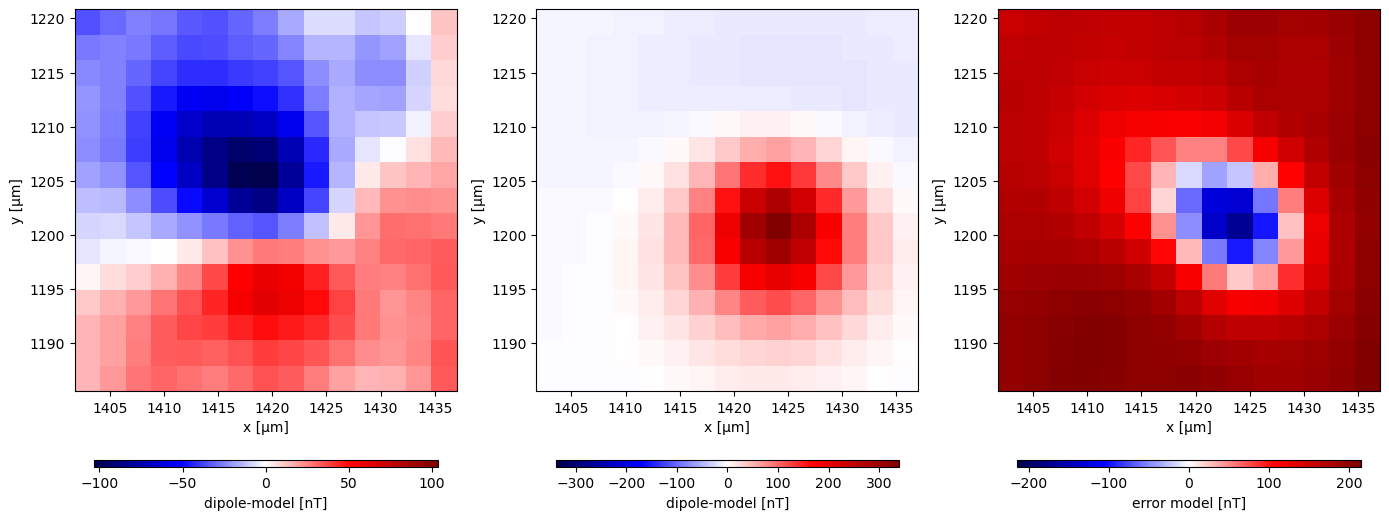

R²: -2.6783320693349655  | Dec: 32.0857133917767 | Inc: -29.587731612530597 | Amp: 1.384014274487396e-14
SNR: 0.7914919489554372 |  Xc: 409.8858761176829 |  Yc: 776.3193659624536 |  Zc: -7.186585147000233


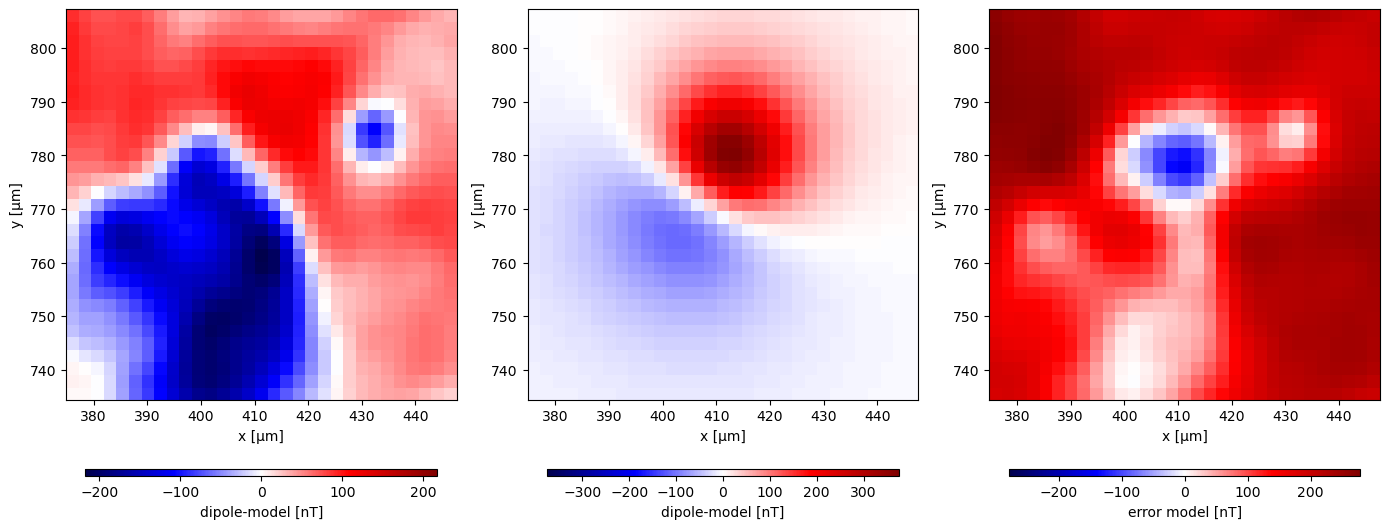

R²: 0.547094540517068  | Dec: 12.749060573211233 | Inc: 19.53321178891842 | Amp: 7.77717247357088e-14
SNR: 6.412096886434106 |  Xc: 838.562251493517 |  Yc: 1008.3005446940417 |  Zc: -19.59829842221595


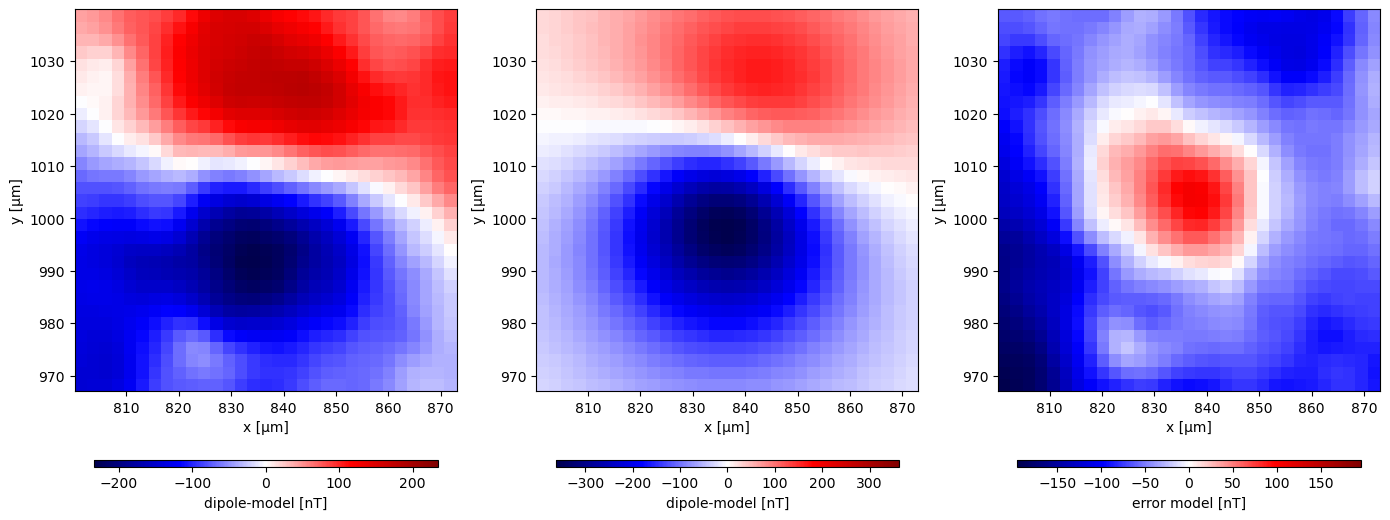

R²: 0.9693448399761124  | Dec: -175.0403466016202 | Inc: 24.164519937853036 | Amp: 2.4329259824897396e-13
SNR: 15.321711052549938 |  Xc: 739.8055013882713 |  Yc: 516.9231404695208 |  Zc: -18.799574878144337


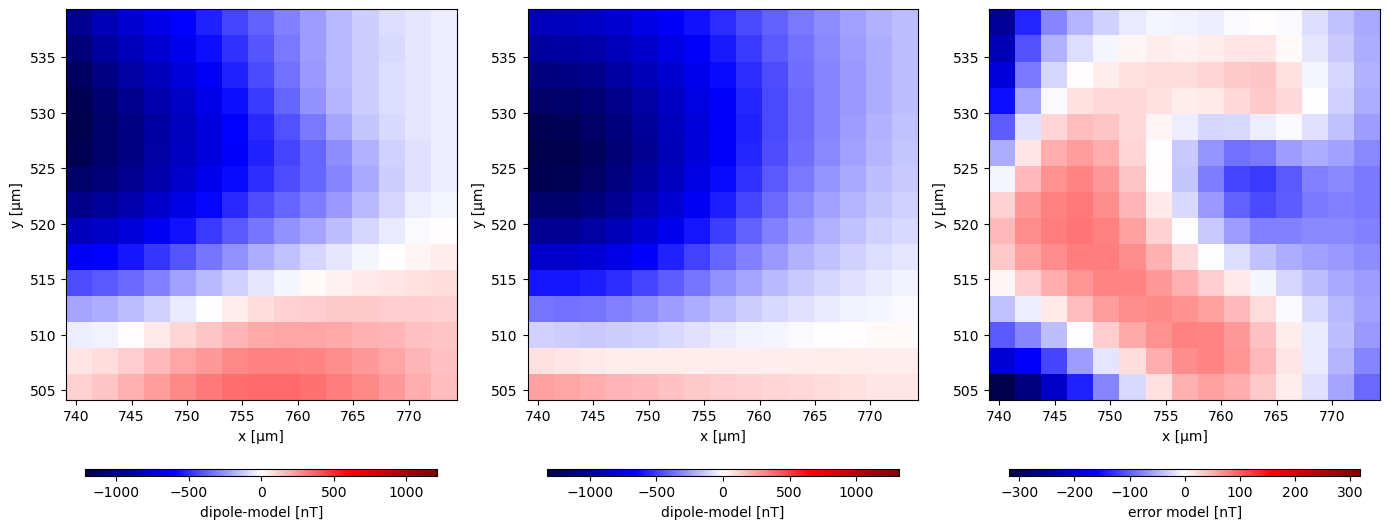

R²: 0.5076598238794341  | Dec: -132.40079995504428 | Inc: -18.19099068973793 | Amp: 2.6453398909470454e-15
SNR: 6.98157836521415 |  Xc: 2086.8844143204196 |  Yc: 827.3757305915993 |  Zc: -2.3325707704301597


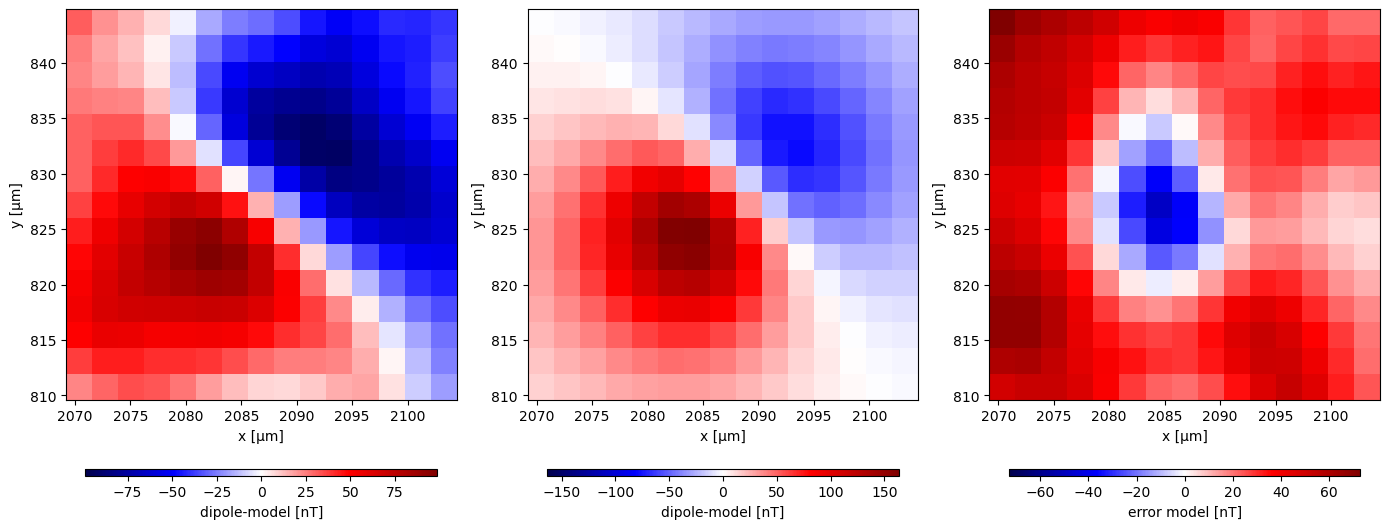

R²: 0.814237566740096  | Dec: 25.80934967413914 | Inc: -22.468046391065485 | Amp: 3.028071303302229e-13
SNR: 8.33883068084701 |  Xc: 1327.9953636854693 |  Yc: 294.7427142901084 |  Zc: -33.75482345509682


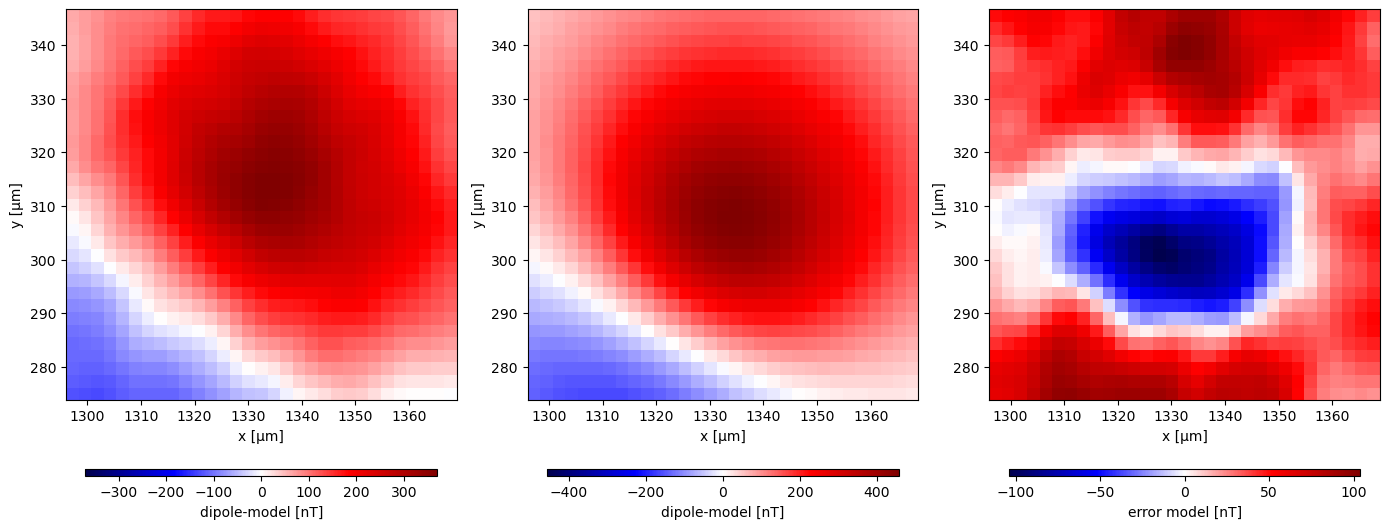

R²: -0.40156304891821204  | Dec: 162.85649383087426 | Inc: 35.828008620494884 | Amp: 2.3197152697090725e-14
SNR: -0.12714811123912503 |  Xc: 1069.9793599909576 |  Yc: 1152.4357415307093 |  Zc: -9.41460062563868


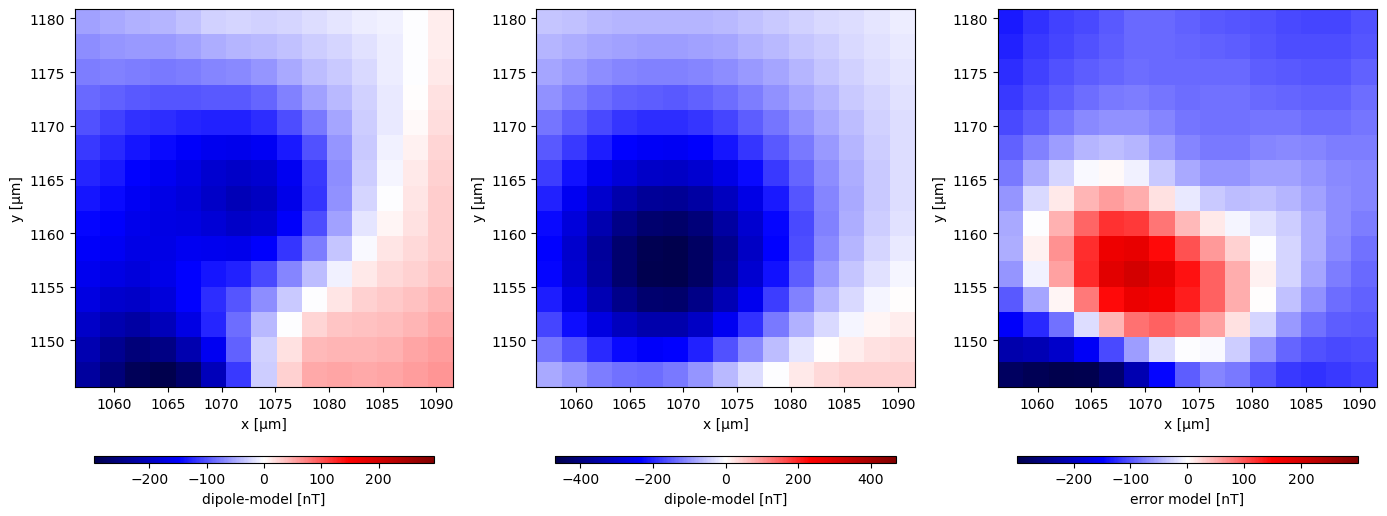

R²: 0.2142442828118517  | Dec: -112.96375645225118 | Inc: -40.81406678116978 | Amp: 9.6633515188183e-16
SNR: 1.0719659020399324 |  Xc: 2046.963253433404 |  Yc: 1038.2057592166714 |  Zc: -0.5541579361080554


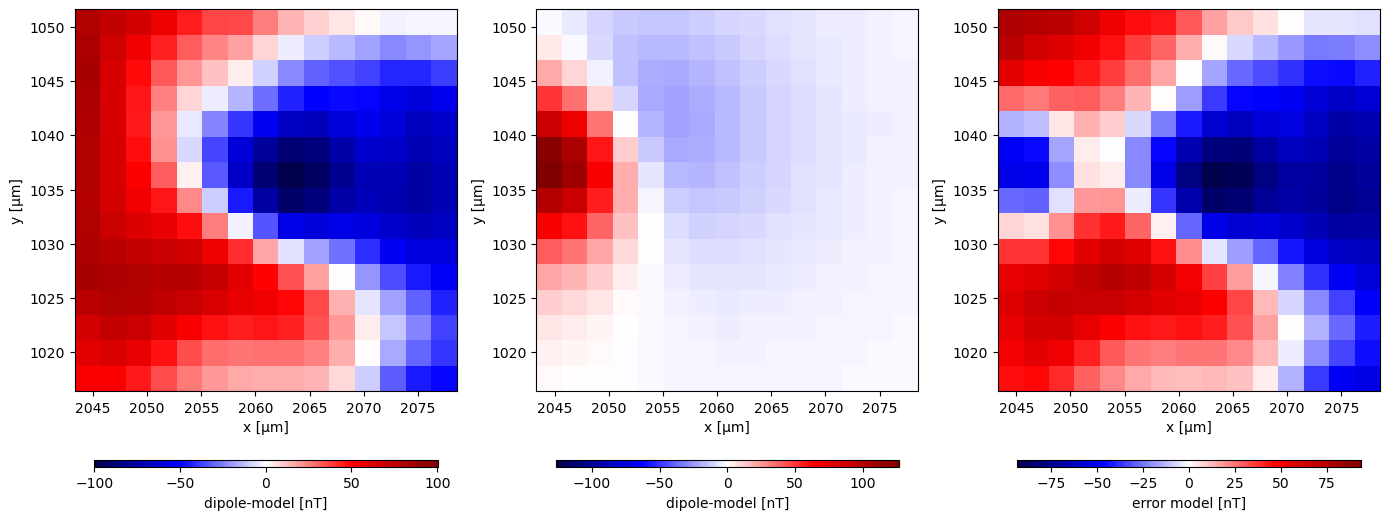

R²: -0.0886187835207688  | Dec: 151.29872098190282 | Inc: -3.925935926892019 | Amp: 5.102803237617326e-15
SNR: 0.3409044086527122 |  Xc: 989.093015290249 |  Yc: 1037.6242410773093 |  Zc: -6.871541173280027


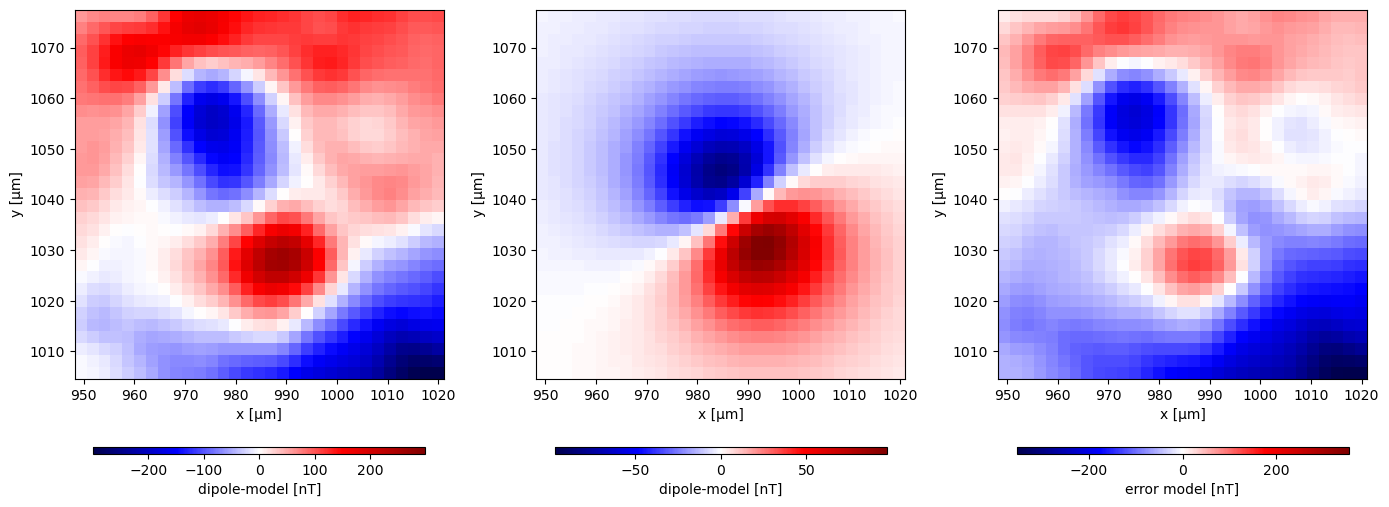

R²: -11.48316920847072  | Dec: -167.37020444629607 | Inc: 61.32413504871911 | Amp: 1.073091090232506e-14
SNR: -7.62167413561032 |  Xc: 470.225373846374 |  Yc: 1069.8304163890925 |  Zc: -5.120287843412604


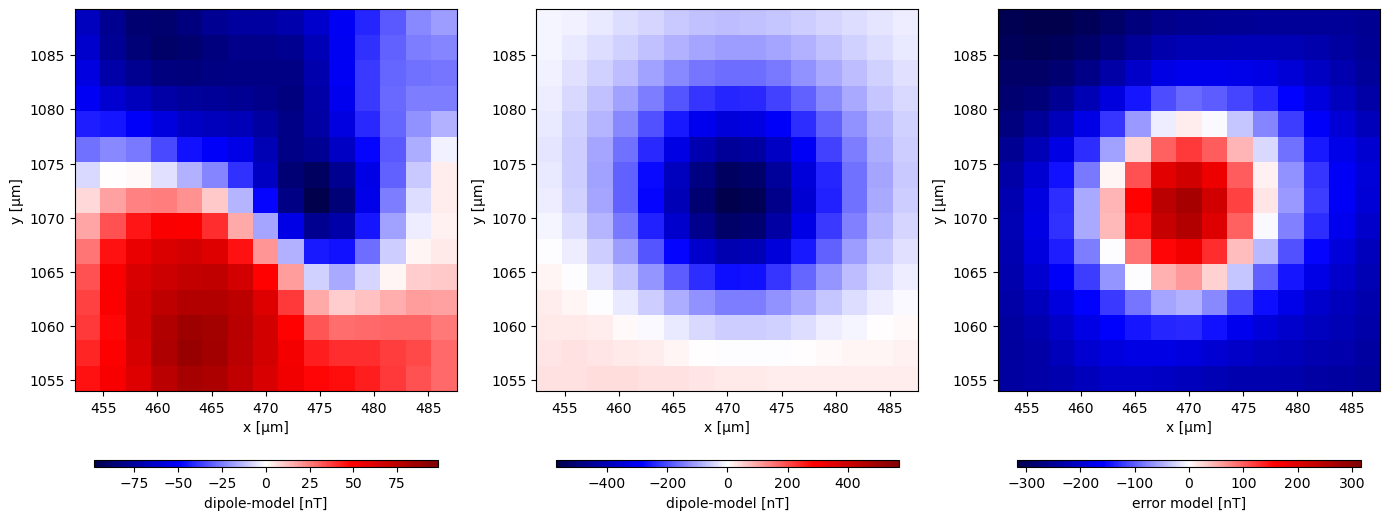

R²: -1.8743577979417259  | Dec: -137.63931679639413 | Inc: 42.4309316983457 | Amp: 1.976374803803924e-15
SNR: -1.910435625708966 |  Xc: 1952.0383993086316 |  Yc: 625.2250991880725 |  Zc: -5.260643110564315


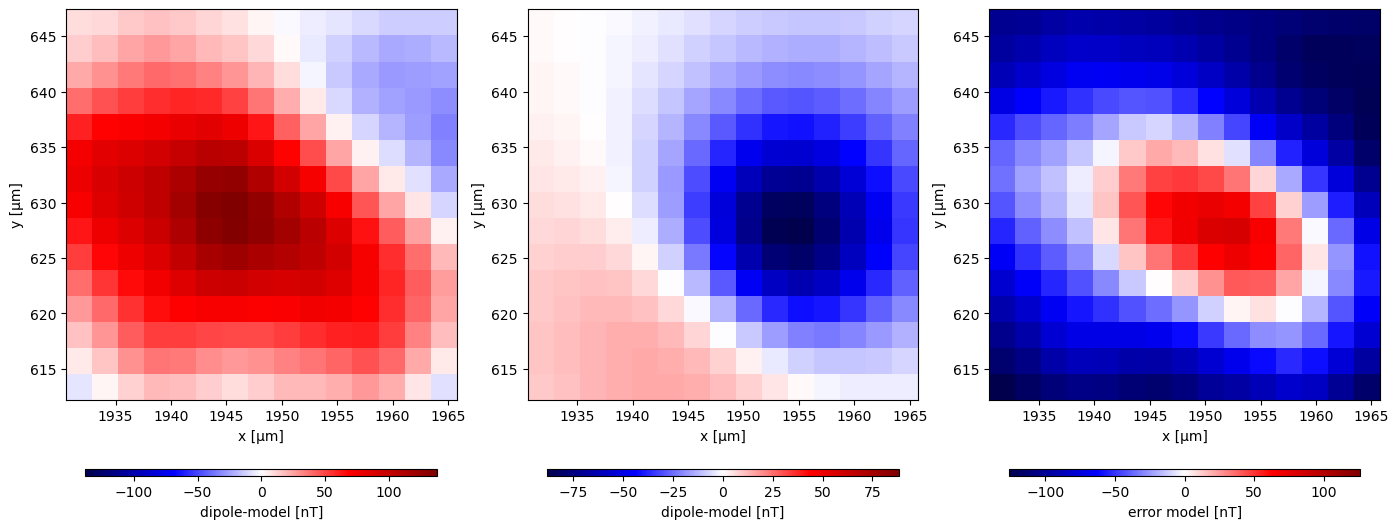

R²: 0.4826665418079532  | Dec: 113.61422195477542 | Inc: -2.628806868384632 | Amp: 3.2169960430099713e-15
SNR: 3.2599366796487974 |  Xc: 2183.89571272597 |  Yc: 754.8620618353026 |  Zc: -3.448591914560065


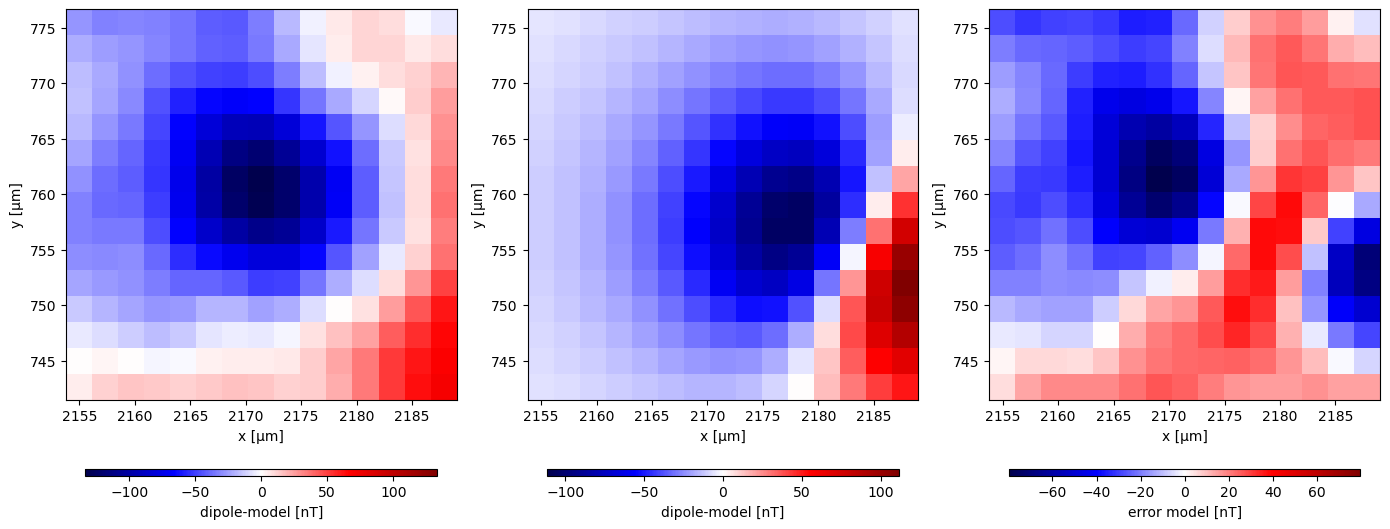

R²: 0.5619570505335121  | Dec: -126.03800048484116 | Inc: 35.081965550625036 | Amp: 4.987892248122614e-15
SNR: 4.153269912073888 |  Xc: 595.3283047546562 |  Yc: 770.9603897898455 |  Zc: -6.360559144935428


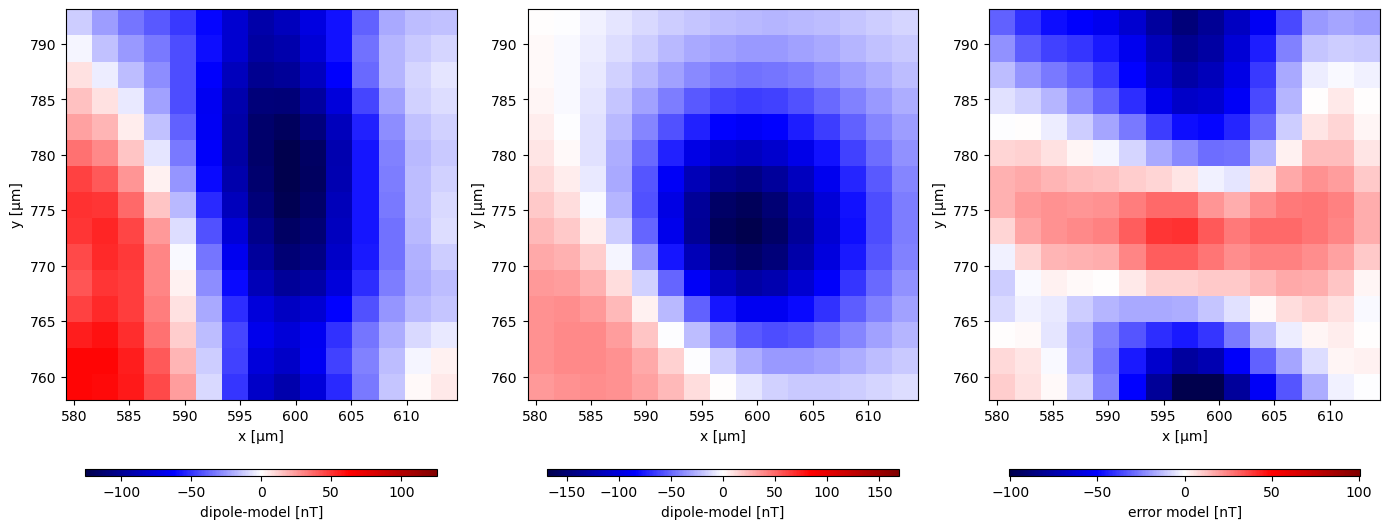

R²: -0.6119599068141766  | Dec: -32.646068001645936 | Inc: 42.24141760835789 | Amp: 2.275179122514952e-15
SNR: 1.6389566014939148 |  Xc: 424.91051096763647 |  Yc: 551.1641088960776 |  Zc: -2.015249497095868


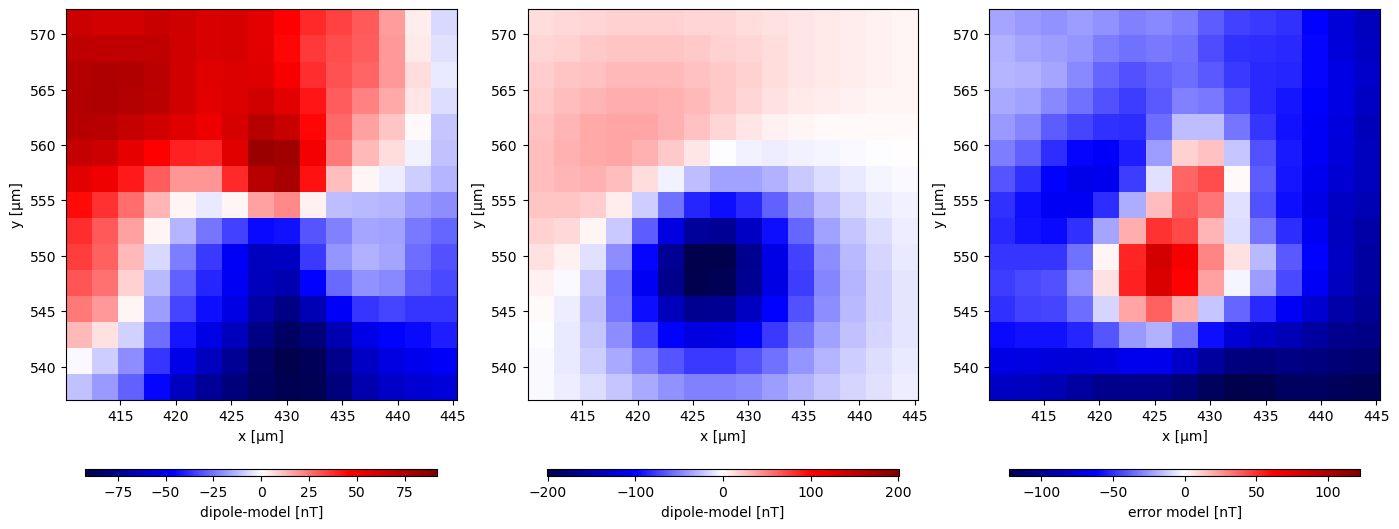

R²: -1.0854228812928461  | Dec: -10.87639759323757 | Inc: 55.595853697865856 | Amp: 2.12494533080032e-14
SNR: -1.8046613388668253 |  Xc: 361.78666324309285 |  Yc: 515.0911372010694 |  Zc: -10.62311116959764


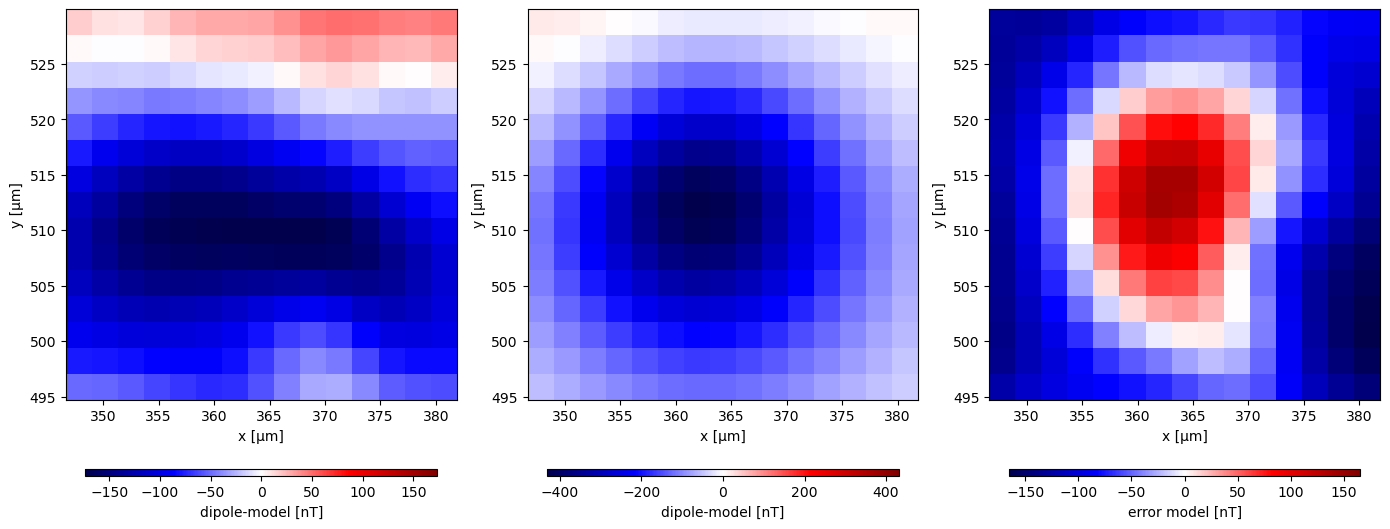

R²: 0.8288098059559185  | Dec: -64.92121695076746 | Inc: -18.79260717795421 | Amp: 4.1549942329067995e-14
SNR: 7.717447196740076 |  Xc: 360.052990698635 |  Yc: 583.6780674220324 |  Zc: -14.457297270287468


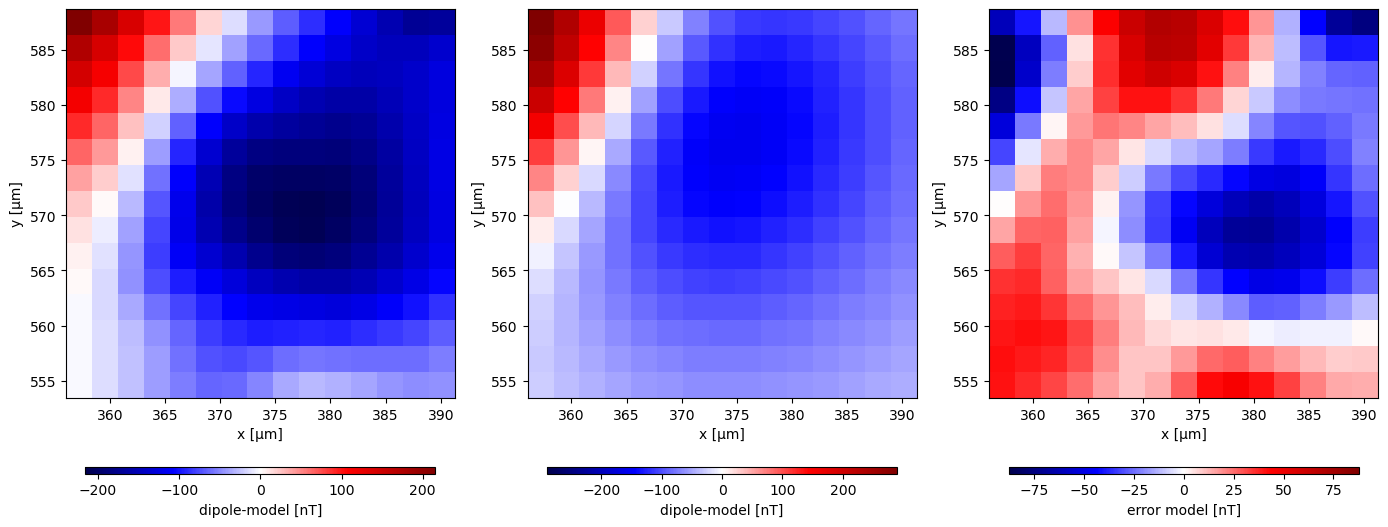

R²: 0.940973563549064  | Dec: -164.97333883548387 | Inc: -8.453475521886281 | Amp: 4.6460870062731014e-12
SNR: 12.759743781386742 |  Xc: 1403.864691931019 |  Yc: 534.3863639023286 |  Zc: -78.77622474915536


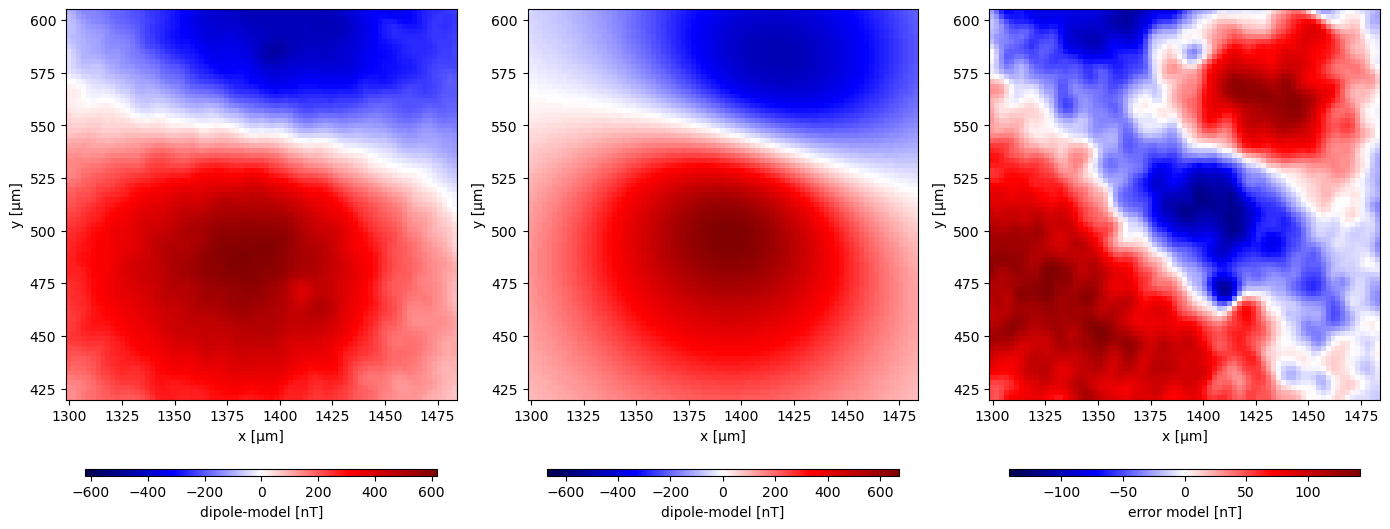

R²: 0.5451855372742567  | Dec: -32.71443002438804 | Inc: -35.316446202505915 | Amp: 1.4720068008868488e-14
SNR: 3.482358615797392 |  Xc: 773.1925174425904 |  Yc: 178.81460545285785 |  Zc: -9.014857165497478


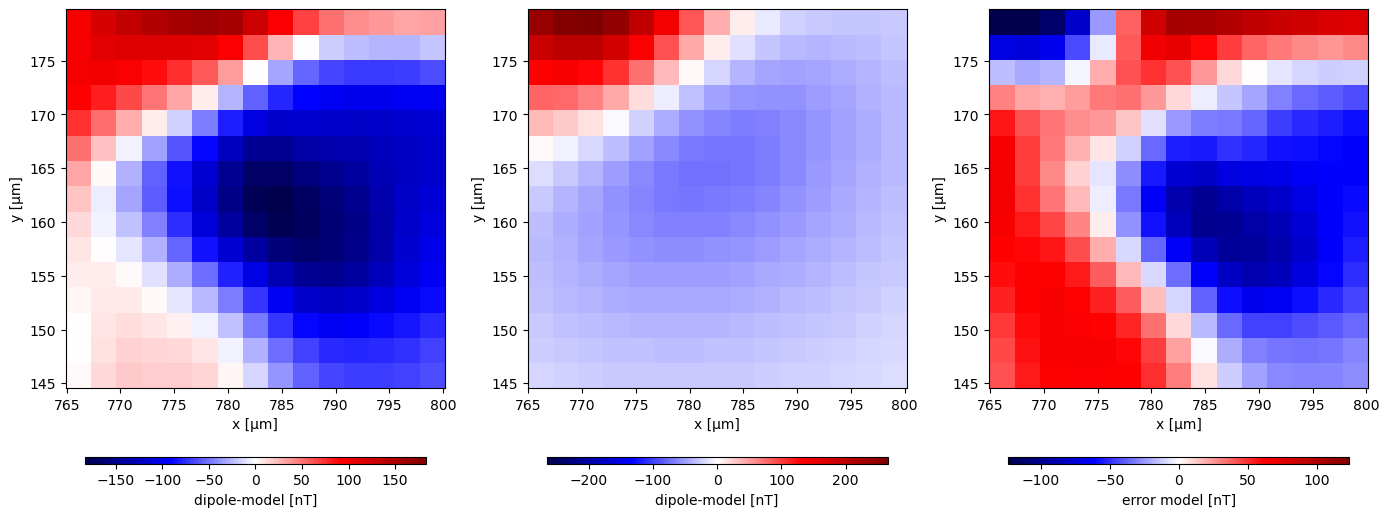

In [20]:
windows_filtered = np.reshape( windows_filtered, (int(np.size(windows_filtered)/4), 4) )
base_level_count = 0

estimated_dipole_moments = []
estimated_stds = []
calculated_r2 = []
calculated_SNR = []



for window, position in zip(windows_filtered, positions.T):
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(
        anomaly.bz, position,
    )
    estimated_dipole_moments.append(moment)
    estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
    calculated_r2.append(r2)
    calculated_SNR.append(SNR)
    
    einc, edec, eamp = mg.vector_to_angles(moment)
    print("R²: %s  | Dec: %s | Inc: %s | Amp: %s"%(r2,edec,einc,eamp))
    print("SNR: %s |  Xc: %s |  Yc: %s |  Zc: %s"%(SNR,position[0],position[1],position[2]))
    
    
    # remove background from the window
    data_minus_background = anomaly.bz.values - base_levels[base_level_count]
    base_level_count += 1
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    # calculate model
    coord_slice = vd.grid_coordinates(
    region=[(anomaly.x.values).min(), (anomaly.x.values).max(), (anomaly.y.values).min(), (anomaly.y.values).max()],  # µm
    shape=anomaly.bz.shape,  # µm
    extra_coords=(anomaly.z.values).mean()
    )   
    model = mg.dipole_bz(coord_slice, position, moment)
    

    anomaly = anomaly.assign(model=(['y','x'], model))
    anomaly.model.attrs = {"long_name": "dipole-model", "units": "nT"}

    error = anomaly.bz.values - anomaly.model.values
    anomaly = anomaly.assign(error=(['y','x'],error))
    anomaly.error.attrs = {"long_name": "error model", "units": "nT"}
    
    # plot
    fig, axes = plt.subplots(1, 3, figsize=(14, 14))
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.05, shrink=0.9)
    for field, ax in zip(["data_minus_background", "model", "error"], axes.ravel()):
        
        anomaly[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs)
    
    for ax in axes.ravel():
        ax.set_aspect("equal")
    plt.tight_layout()
    plt.show()

# Article figure

Make nice figures out of these results for the paper. These are more elaborate figures that are designed for the printed page in particular.

In [21]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

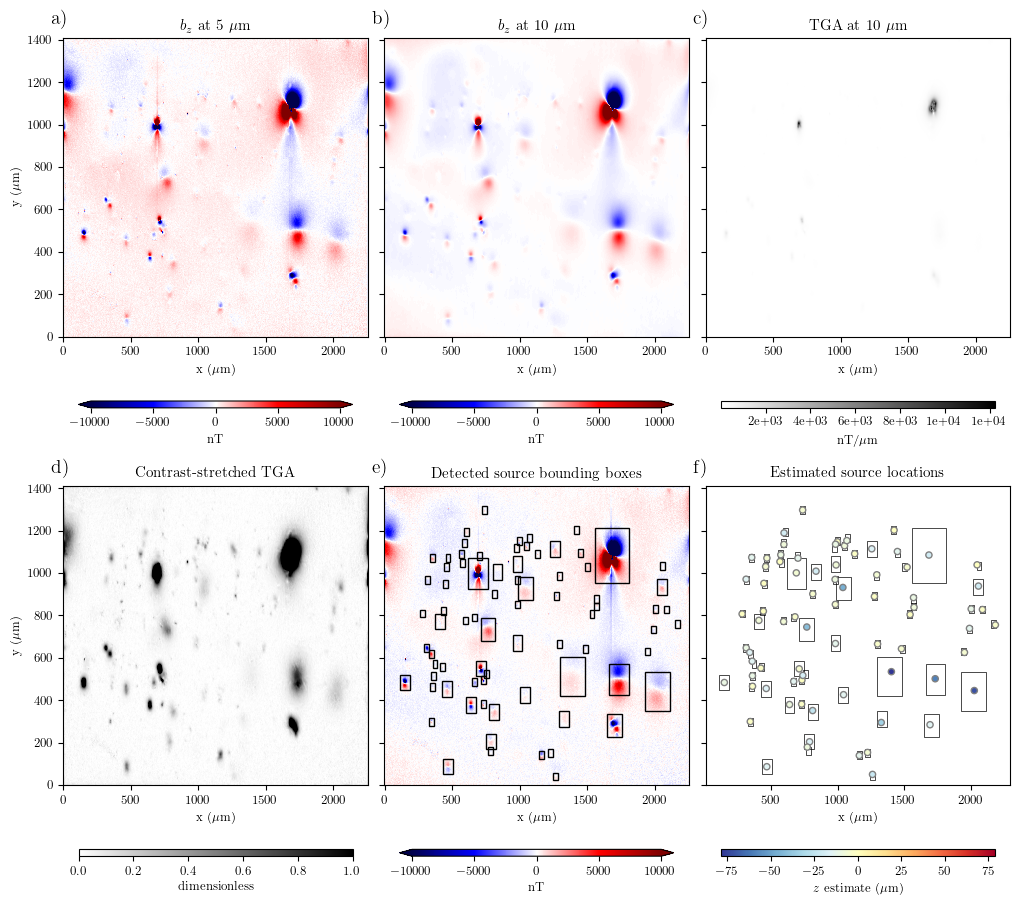

In [22]:
sensor_sample_distance = float(data.z.values.mean())
vmax=+10000
vmin=-10000
with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(2, 3, figsize=(10, 9), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.9)
    
    ax = axes[0]
    ax.set_aspect("auto")
    ax.set_title(f"$b_z$ at {sensor_sample_distance:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    

    ax = axes[1]
    ax.set_aspect("auto")
    ax.set_title(f"$b_z$ at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    
    ax = axes[2]   
    ax.set_aspect("auto")
    ax.set_title(f"TGA at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.tga.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="nT/$\mu$m", **cbar_kwargs, format="%.0e")
    
    ax = axes[3]  
    ax.set_aspect("auto")
    ax.set_title(f"Contrast-stretched TGA")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data_up.tga_stretched.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="dimensionless", **cbar_kwargs)
    
    ax = axes[4]  
    ax.set_aspect("auto")
    ax.set_title(f"Detected source bounding boxes")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data.residual.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')    
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)   
    
    
#     ax = axes[5]   
#     ax.set_aspect("auto")
#     ax.set_title(f"$R^2$", fontsize=13)
#     ax.set_xlabel("x ($\mu$m)")
#     ax.set_ylabel("y ($\mu$m)")

#     scale = 0.0
#     tmp = ax.scatter(*positions[:2], c=calculated_r2, s=20, cmap="Oranges_r", vmin=scale, edgecolor='gray')
#     fig.colorbar(tmp, ax=ax, label="dimensionless", **cbar_kwargs, extend='min') 
    
    
    ax = axes[5]  
    ax.set_aspect("auto")
    ax.set_title(f"Estimated source locations")
    ax.set_xlabel("x ($\mu$m)")
    scale = 100
#     tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r",  add_colorbar=False, add_labels=False)
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=0.5,
        )
        ax.add_patch(rect)
    scale = vd.maxabs(positions[2])
    tmp = ax.scatter(*positions[:2], c=positions[2], s=20, cmap="RdYlBu_r", vmin=-scale, vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label="$z$ estimate ($\mu$m)", **cbar_kwargs)    
    
    for ax, letter in zip(axes, "a b c d e f".split()):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)
    
    fig.savefig(fig_dir / "real-data.png", dpi=300, facecolor='w', bbox_inches='tight')
    
    plt.show()

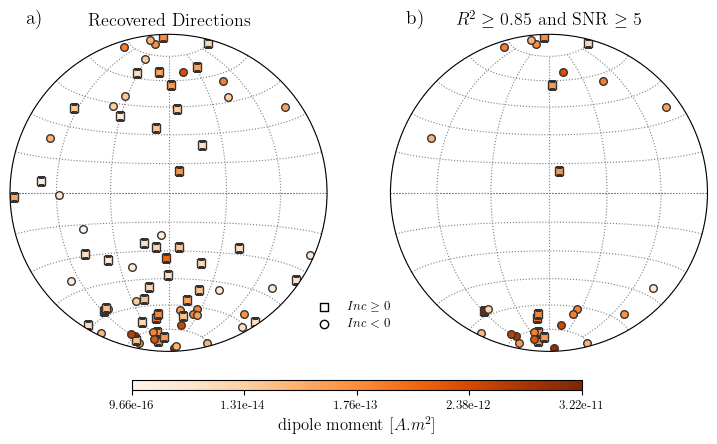

In [34]:
with plt.rc_context(mpl_rc):
    fig, axes = mplstereonet.subplots(1, 2, figsize=(9, 5))

    estimated = mg.vector_to_angles(estimated_dipole_moments)

    scatter_args = dict(
        vmin=np.log10(np.min(estimated[2])),
        vmax=np.log10(np.max(estimated[2])),
        cmap="Oranges",
        edgecolors="#333333",
        linewidths=1,
        s=30,
        zorder=2,
    )

    ticks=np.linspace( np.log10(np.min(estimated[2])),
                       np.log10(np.max(estimated[2])), 5)
    
    ax = axes[0]       
    for i in range(len(estimated_dipole_moments)):
        estimated = mg.vector_to_angles(estimated_dipole_moments[i])
        pos_inc = estimated[0] > 0
        tmp = ax.scatter(
            *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
            c=np.log10(estimated[2][pos_inc]),
            marker="s",
            **scatter_args,
        )
        tmp = ax.scatter(
            *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
            c=np.log10(estimated[2][~pos_inc]),
            marker="o",
            **scatter_args,
        )

    ax = axes[1]
    count_r2 = 0         
    for i in range(len(calculated_r2)):
        if calculated_r2[i] >= 0.8 and calculated_SNR[i] >= 3:
            
#         if calculated_SNR[i] >= 20:
            count_r2 += 1
            estimated = mg.vector_to_angles(estimated_dipole_moments[i])
            pos_inc = estimated[0] > 0
            tmp = ax.scatter(
                *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
                c=np.log10(estimated[2][pos_inc]),
                marker="s",
                **scatter_args,
            )
            tmp = ax.scatter(
                *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
                c=np.log10(estimated[2][~pos_inc]),
                marker="o",
                **scatter_args,
            )

    tick_labels = []
    for i in (ticks):
        tick_labels.append("{:.2e}".format(10**i))


    clb = fig.colorbar(
        tmp, 
        cax=fig.add_axes([0.26, 0.10, 0.5, 0.02]), 
        orientation="horizontal", 
        format="%.2e",
        ticks = ticks)
    clb.set_label(label="dipole moment [$A.m^2$]", fontsize=12)
    clb.set_ticklabels(tick_labels)

    plt.scatter([],[], marker='s', color='white', edgecolors='k', label=r'$Inc \geq 0° $')
    plt.scatter([],[], marker='o', color='white', edgecolors='k', label=r'$Inc < 0° $')

    legend = plt.legend(bbox_to_anchor=(0.6, 10.0), frameon=1, framealpha=1.0)
    frame = legend.get_frame()
    frame.set_facecolor('w')
    frame.set_edgecolor('w')


    titles = ('Recovered Directions', '$R^2 \geq 0.85$ and SNR $\geq 5$')

    for ax, letter, title in zip(axes, "a b".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
        ax.set_azimuth_ticks([])
        ax.grid(linestyle=':', color='gray')
        ax.set_title(title, fontsize=13)
    fig.subplots_adjust(wspace=0.2)

    
    fig.savefig(fig_dir / "real-data-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

In [24]:
print(count_r2)

28


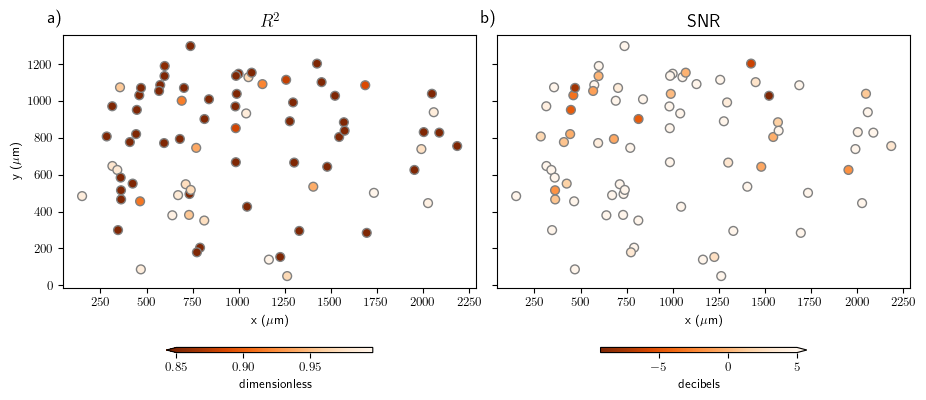

In [25]:
vmax=+10000
vmin=-10000

with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.5)
        
    ax = axes[0]   
    ax.set_aspect("equal")
    ax.set_title(f"$R^2$", fontsize=13)
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")

    scale = 0.85
    tmp = ax.scatter(*positions[:2], c=calculated_r2, s=40, cmap="Oranges_r", vmin=scale, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label="dimensionless", **cbar_kwargs, extend='min') 
    
    ax = axes[1]  
    ax.set_aspect("equal")
    ax.set_title(f"SNR", fontsize=13)
    ax.set_xlabel("x ($\mu$m)")
    
    scale = 5
    tmp = ax.scatter(*positions[:2], c=calculated_SNR, s=40, cmap="Oranges_r", edgecolor='gray', vmax=scale)
    fig.colorbar(tmp, ax=ax, label="decibels", **cbar_kwargs, extend='max') 

    for ax, letter in zip(axes, "a b".split()):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
#         ax.scatter(*dipole_coordinates[:2], color='k', marker='x', zorder=-1)
        
    plt.tight_layout(pad=0, h_pad=0, w_pad=0.7)

28


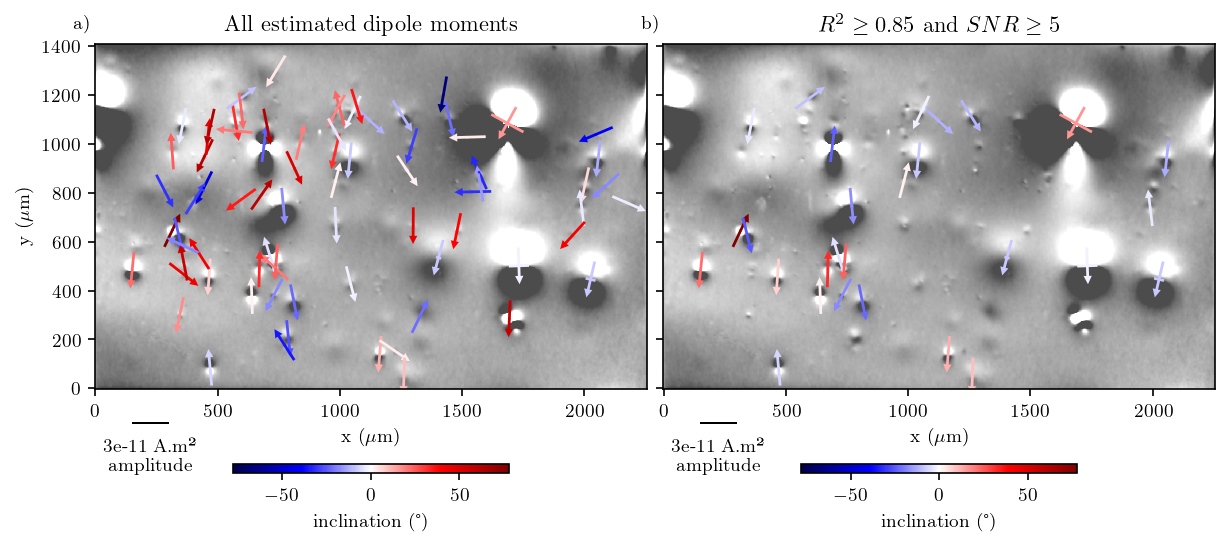

In [41]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 2, figsize=(8, 5), sharey=True, dpi=150)
    
    for ax in axes:
        scale = 500
        data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, add_colorbar=False, add_labels=False, alpha=0.7)
        ax.set_aspect("equal")
        
    cbar_kwargs = dict(orientation="horizontal", aspect=30, pad=0.1, shrink=0.5, label="inclination (°)")
    
    good = (np.array(calculated_r2) >= 0.85) & (np.array(calculated_SNR) >= 3)
    print(np.sum(good))
    
    ax = axes[0]
    inc, amp = mg.plot_dipole_moment(positions, estimated_dipole_moments, ax=ax, add_colorbar=False)
    plt.colorbar(inc, ax=ax, **cbar_kwargs)
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    ax.set_title("All estimated dipole moments")
    
    ax = axes[1]
    inc, amp = mg.plot_dipole_moment(positions.T[good].T, np.array(estimated_dipole_moments)[good], ax=ax, add_colorbar=False)
    plt.colorbar(inc, ax=ax, **cbar_kwargs)
    ax.set_xlabel("x ($\mu$m)")
    ax.set_title("$R^2 \ge 0.85$ and $SNR \ge 5$")
    
    
    for ax, letter in zip(axes, "a b c d e f".split()):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes)

    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    #fig.savefig(fig_dir / "real-data-dipole-moments.png", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()